
### Entrada
- x1: Local da Coleta em km
- x2: Nivel da Mare em m
- x3: Umidade do Ar (%)
- x4: Índice Pluvimétrico (mm)¹
- x5: Temperatura (°C)

### Saida
- y1: pH
- y2: Condutividade Elétrica (mS.cmˉ¹)
- y3: Oxigênio Dissolvido (mg.Lˉ¹)
- y4: Sólidos Totais Dissolvidos (ppm)


In [1]:
!pip install --upgrade pip
!pip install tensorflow 
!pip install openpyxl

In [2]:
import os

os.chdir("./content")

lm_dir = "tf-levenberg-marquardt"
if not os.path.exists(lm_dir):
  !git clone https://github.com/fabiodimarco/$lm_dir

os.chdir(lm_dir)

/tmp/ipykernel_234659/638584088.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


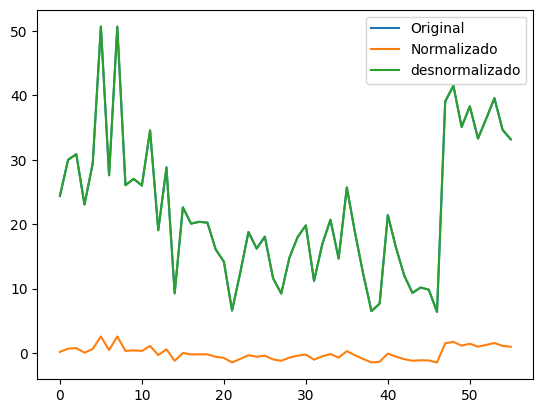

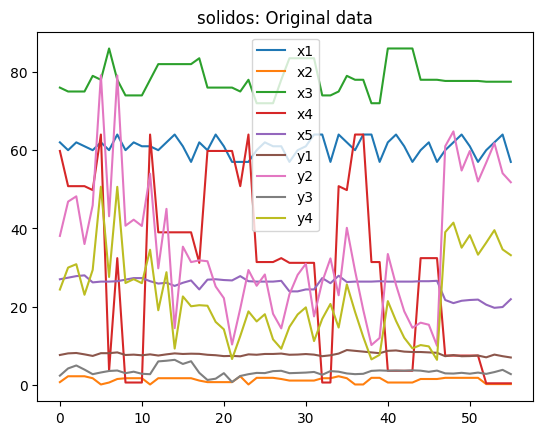

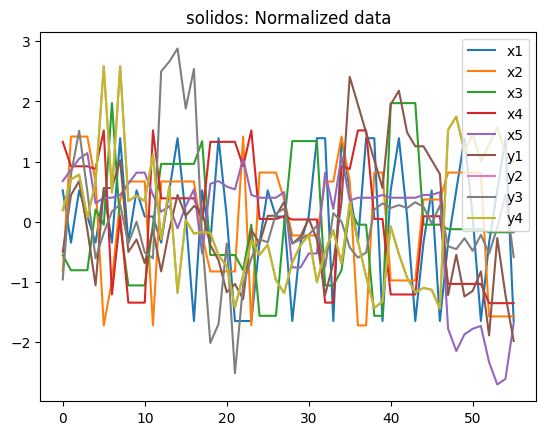

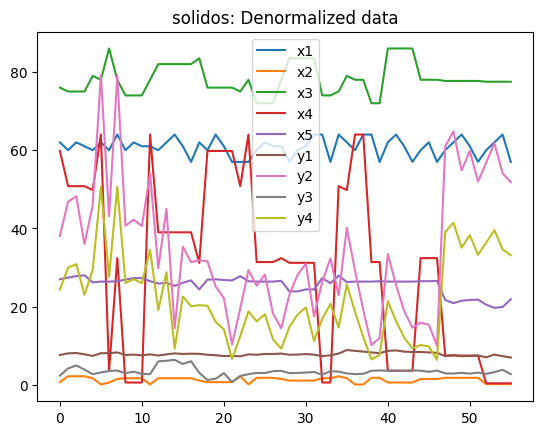

In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

scaler = StandardScaler()
out_scaler = StandardScaler()

def getData():
    df_orig = pd.read_excel("../../../data.xlsx")    
    df = pd.DataFrame(scaler.fit_transform(df_orig), columns=df_orig.columns)
    df_denorm = pd.DataFrame(scaler.inverse_transform(df), columns=df.columns)
    return (df_orig, df, df_denorm)

def create_dataframe(df, output):
    x1, x2, x3, x4, x5  = df['x1'], df['x2'], df['x3'], df['x4'], df['x5']

    input = np.vstack([x1, x2, x3, x4, x5 ]).T
    output = np.array(df[output])
    scaler.fit(output.reshape(-1, 1))
    return output, input

def test_out_scaler():
    out = df_orig["y4"].values.reshape(-1, 1)  
    plt.plot(out, label='Original')
    out_scaler.fit(out)
    norm = out_scaler.transform(out)
    plt.plot(norm, label='Normalizado')
    plt.plot(out_scaler.inverse_transform(norm), label='desnormalizado')
    plt.legend()
    plt.show()

def show_norm(label):
    df_orig.plot(title=f"{label}: Original data")
    df.plot(title=f"{label}: Normalized data")
    df_denorm.plot(title=f"{label}: Denormalized data")

df_orig, df, df_denorm = getData()
output, input = create_dataframe(df, output="y4")
test_out_scaler()
show_norm(label="solidos")


In [4]:
import tensorflow as tf
import numpy as np
from keras import regularizers
from keras import initializers
import levenberg_marquardt as lm

# layers, neurons
class ShuffleArchitecture:
    def __init__(self, input_size, hidden_sizes, output_size, act_h, act_o, param_reg):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.act_h = act_h
        self.act_o = act_o
        self.regularizer = regularizers.L2(param_reg)
        self.initializer = initializers.RandomUniform(minval=-0.5, maxval=0.5, seed=np.random.randint(1, 10000))

    def set_architecture(self):
        self.model = tf.keras.Sequential()
        self.model.add(tf.keras.layers.Dense(self.hidden_sizes[0],
                        input_shape=(self.input_size,),
                        activation=self.act_h,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,                        
                        ))  # input layer
        
        for size in self.hidden_sizes[1:]:  # hidden layers
            self.model.add(tf.keras.layers.Dense(size,
                            activation=self.act_h,
                            kernel_regularizer=self.regularizer,
                            kernel_initializer=self.initializer,  
                        ))

        self.model.add(tf.keras.layers.Dense(self.output_size,
                        activation=self.act_o,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,  
                        ))  # output layer

    def create_model(self, _learning_rate):
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=_learning_rate),
            loss=tf.keras.losses.MeanSquaredError())

        self.lm_model = lm.ModelWrapper(
            tf.keras.models.clone_model(self.model))

        self.lm_model.compile(
            optimizer=tf.keras.optimizers.SGD(learning_rate=_learning_rate),
            loss=lm.MeanSquaredError())
        return(self.lm_model)

2024-04-04 23:43:26.816621: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-04 23:43:26.868725: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-04 23:43:26.868781: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-04 23:43:26.870296: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-04 23:43:26.879307: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-04 23:43:26.881023: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [5]:
import tensorflow as tf
import time
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_squared_error

class TrainWithSmallDataset:
    def __init__(self, batch_size=1000):
        self.batch_size = batch_size
        self.betters = []
    
    def create_dataset(self, input, output):
      input = tf.expand_dims(tf.cast(input, tf.float32), axis=-1)
      output = tf.expand_dims(tf.cast(output, tf.float32), axis=-1)

      dataset = tf.data.Dataset.from_tensor_slices((input, output))
      dataset = dataset.shuffle(len(input))
      dataset = dataset.batch(self.batch_size).cache()
      dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
      return (dataset, input, output)

    def split_dataset(self, input, output):
      input_train, input_vt, output_train, output_vt = train_test_split(input, output, test_size=0.3, shuffle = True)
      input_val, input_test, output_val, output_test = train_test_split(input_vt, output_vt, test_size=0.5, shuffle = True)

      self.train_dataset, self.train_input, self.train_output = self.create_dataset(input_train, output_train)
      self.val_dataset, self.val_input, self.val_output = self.create_dataset(input_val, output_val)
      self.test_dataset, self.test_input, self.test_output = self.create_dataset(input_test, output_test)
      self.vt_dataset, self.vt_input, self.vt_output = self.create_dataset(input_vt, output_vt)
      self.dataset, self.input, self.output = self.create_dataset(input, output)

      self._data = (input, output)
      self._train = (input_train, output_train)
      self._vt = (input_vt, output_vt)
      self._val = (input_val, output_val)
      self._test = (input_test, output_test)
    
    def train_using_lm(self, train_dataset, epochs=1000):
      early_stopping_monitor = EarlyStopping(monitor='val_loss',
                                              patience=6,
                                              restore_best_weights=True)

      t2_start = time.perf_counter()
      self.results = self.lm_model.fit(train_dataset,
                                            epochs=epochs,
                                            validation_data=self.val_dataset,
                                            callbacks=[early_stopping_monitor],
                                            verbose=0)
      t2_stop = time.perf_counter()
      print("Elapsed time: ", t2_stop - t2_start)
      print ("Stopped at epoch: ", early_stopping_monitor.stopped_epoch)

    def get_metrics(self):
    # Calculando a saida com os dados normalizados
      pred = self.lm_model.predict(self.input).flatten()
      test_pred = self.lm_model.predict(self.test_input).flatten()
      val_pred = self.lm_model.predict(self.val_input).flatten()
      vt_pred = self.lm_model.predict(self.vt_input).flatten()
  
    # Calculando as metricas com a saida desnormalizada
      self.pred_denorm = out_scaler.inverse_transform(pred.reshape(-1, 1))
      test_pred_denorm = out_scaler.inverse_transform(test_pred.reshape(-1, 1))
      val_pred_denorm = out_scaler.inverse_transform(val_pred.reshape(-1, 1))
      vt_pred_denorm = out_scaler.inverse_transform(vt_pred.reshape(-1, 1))

      self.out_denorm = out_scaler.inverse_transform(self._data[1].reshape(-1, 1))
      test_denorm = out_scaler.inverse_transform(self._test[1].reshape(-1, 1))
      val_denorm = out_scaler.inverse_transform(self._val[1].reshape(-1, 1))
      vt_denorm = out_scaler.inverse_transform(self._vt[1].reshape(-1, 1))      

      r2 = r2_score(self.out_denorm, self.pred_denorm)
      r2_test = r2_score(test_denorm, test_pred_denorm)
      r2_val = r2_score(val_denorm, val_pred_denorm)
      r2_vt = r2_score(vt_denorm,  vt_pred_denorm)

      mse = mean_squared_error(self.out_denorm, self.pred_denorm)
      mse_test = mean_squared_error(test_denorm, test_pred_denorm)
      mse_val = mean_squared_error(val_denorm, val_pred_denorm)
      mse_vt = mean_squared_error(vt_denorm,  vt_pred_denorm)

      metrics = {
                      'r2': r2,
                      'r2_test': r2_test,
                      'r2_val': r2_val,
                      'r2_vt': r2_vt,
                      'mse': mse,
                      'mse_test': mse_test,
                      'mse_val': mse_val,
                      'mse_vt': mse_vt
                      }

      return metrics

In [6]:
from itertools import product
import pickle

class Tester:
  def __init__(self, input, output, run_times=500, dataset_run_times=10):
    self.run_times = run_times
    self.better_metrics = {}
    self.dataset_run_times = dataset_run_times
    self.input, self.output = input, output
  
  def setArchitecure(self, trainer, _hidden_sizes, _pg, _lr):
    shuffler = ShuffleArchitecture(input_size=5,
                                    hidden_sizes=_hidden_sizes,
                                    output_size=1,
                                    act_h='tanh',
                                    act_o='linear',
                                    param_reg=_pg)
    shuffler.set_architecture()    
    trainer.lm_model = shuffler.create_model(_lr)

  def Train(self, trainer, epochs=1000):
    trainer.train_using_lm(trainer.train_dataset, epochs=epochs)
    return(trainer.get_metrics(), trainer.lm_model)

  def SaveModelWeights(self, model, fileName):
    path = f"../models/{fileName}.keras"
    open(path,'w').close()
    model.save_weights(path) 

  def SaveDataset(self, trainer, fileName):
    path = f"../dataset/{fileName}.pkl" 
    with open(path, 'wb') as f:
      pickle.dump((trainer._data, trainer._train, trainer._vt, trainer._val, trainer._test), f)

  def LoopWeights(self, sort_by, boundarie, trainer, idx):
    better_model = 0
    save = False

    for i in range(self.run_times):
      print (f"+++++++++++ [{idx}] | {i + 1} ++++++++++++++++++")
      metrics, model = self.Train(trainer)
      if (metrics[sort_by] >= boundarie): # should be <= to descending metrics
        fileName = f"model_{idx}_{better_model}"
        self.SaveModelWeights(model, fileName)
        self.better_metrics[fileName] = metrics
        better_model += 1
        save = True
    
    return(save)

# Init
  def Loop(self, sort_by, boundarie, hidden_sizes, regularizers, learning_rate):
    trainer = TrainWithSmallDataset()

    for count, (hidden_size, reg, lr) in enumerate(product(hidden_sizes, regularizers, learning_rate), start=1):
      header =  f"Hidden Size={hidden_size}, regularizer={reg}, learning_rate={lr}"
      print(f"Testando combinação {count}: {header}")
      self.setArchitecure(trainer, hidden_size, reg, lr)
      for j in range(self.dataset_run_times):
        trainer.split_dataset(self.input, self.output)
        if (self.LoopWeights(sort_by, boundarie, trainer, f"{count}_{j}") == True):
          self.SaveDataset(trainer, f"dataset_{count}_{j}")
          self.DisplayBetterResults(sort_by, header, f"{count}_{j}")
        self.better_metrics = {}

  def DisplayBetterResults(self, sort_by, header, dataset=0):
    df = pd.DataFrame.from_dict(self.better_metrics, orient='index')
    df = df.sort_values([sort_by])
    display(df)
    path = f'../results/metrics_{dataset}'
    df.to_excel(f"{path}.xlsx", index=True)
    print(f"DataFrame salvo em {path}")
    with open(f"{path}.txt", 'w') as arquivo:
      arquivo.write(header)

In [7]:
tester = Tester(input, output, run_times=25, dataset_run_times=10)

In [8]:
tester.Loop(sort_by='r2',
            boundarie=0.8,
            hidden_sizes = [[5], [10], [15], [20], [25], [30], [35], [40], [45]],
            regularizers=[0.01, 0.1],
            learning_rate=[0.1])

Testando combinação 1: Hidden Size=[5], regularizer=0.01, learning_rate=0.1
+++++++++++ [1_0] | 1 ++++++++++++++++++
Elapsed time:  1.1178669629998694
Stopped at epoch:  9
1/1 [==============================] - 0s 15ms/step
+++++++++++ [1_0] | 2 ++++++++++++++++++
Elapsed time:  0.4155843730000015
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [1_0] | 3 ++++++++++++++++++
Elapsed time:  0.4780838970000332
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [1_0] | 4 ++++++++++++++++++
Elapsed time:  0.4370904950001204
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [1_0] | 5 ++++++++++++++++++
Elapsed time:  0.37047607699992113
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [1_0] | 6 ++++++++++++++++++
Elapsed time:  0.40388746900021033
Stopped at epoch:  6
1/1 [==============================] - 0s 33ms/step
+++++++++++ [1_0] | 7 ++++++++++++

2024-04-04 23:45:05.654850: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Elapsed time:  0.5438811080000505
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [1_4] | 8 ++++++++++++++++++
Elapsed time:  0.365287373000001
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [1_4] | 9 ++++++++++++++++++
Elapsed time:  0.5231643820000045
Stopped at epoch:  7
1/1 [==============================] - 0s 26ms/step
+++++++++++ [1_4] | 10 ++++++++++++++++++
Elapsed time:  0.4892886439999984
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [1_4] | 11 ++++++++++++++++++
Elapsed time:  0.4910763869997936
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [1_4] | 12 ++++++++++++++++++
Elapsed time:  0.6051107739999679
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [1_4] | 13 ++++++++++++++++++
Elapsed time:  0.361103594000042
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_2_0,0.808700,0.861952,0.800546,0.866905,23.070840,8.392226,10.318149,9.298543
model_3_2_1,0.842433,0.887233,0.796234,0.877049,19.002652,6.855338,10.541240,8.589883
model_3_2_2,0.867916,0.896301,0.779229,0.875301,15.929372,6.304102,11.420914,8.712020
model_3_2_3,0.886890,0.892778,0.753308,0.864646,13.641124,6.518219,12.761875,9.456407
model_3_2_4,0.900770,0.879816,0.721585,0.847620,11.967166,7.306252,14.402975,10.645892
model_3_2_5,0.910700,0.860107,0.686532,0.826327,10.769619,8.504380,16.216333,12.133535
model_3_2_22,0.910950,0.484406,0.255369,0.503013,10.739456,31.344049,38.521260,34.721546
model_3_2_21,0.912340,0.496801,0.267982,0.513118,10.571794,30.590501,37.868766,34.015561
model_3_2_20,0.913811,0.510371,0.281836,0.524197,10.394417,29.765593,37.152029,33.241551
model_3_2_19,0.915354,0.525198,0.297033,0.536323,10.208339,28.864233,36.365889,32.394429


DataFrame salvo em ../results/metrics_3_2
+++++++++++ [3_3] | 1 ++++++++++++++++++
Elapsed time:  0.4003953840001486
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [3_3] | 2 ++++++++++++++++++
Elapsed time:  0.3670845410001675
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [3_3] | 3 ++++++++++++++++++
Elapsed time:  0.387214170000334
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [3_3] | 4 ++++++++++++++++++
Elapsed time:  0.36388016199998674
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [3_3] | 5 ++++++++++++++++++
Elapsed time:  0.34010219499987215
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [3_3] | 6 ++++++++++++++++++
Elapsed time:  0.33850145800033715
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [3_3] | 7 ++++++++++++++++++
Elapsed time:  0.3241762260

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_3_23,0.801780,0.200485,0.029975,0.198994,23.905433,121.226961,30.605006,78.581341
model_3_3_22,0.806187,0.219127,0.049723,0.217236,23.373945,118.400385,29.981942,76.791708
model_3_3_21,0.811014,0.239631,0.071272,0.237275,22.791724,115.291463,29.302060,74.825873
model_3_3_20,0.816291,0.262140,0.094734,0.259243,22.155411,111.878509,28.561834,72.670661
model_3_3_19,0.822041,0.286795,0.120212,0.283273,21.461901,108.140185,27.757973,70.313246
model_3_3_18,0.828287,0.313724,0.147796,0.309482,20.708665,104.057102,26.887669,67.742082
model_3_3_17,0.835043,0.343038,0.177557,0.337973,19.893825,99.612254,25.948687,64.947046
model_3_3_16,0.842315,0.374814,0.209542,0.368814,19.016826,94.794300,24.939549,61.921470
model_3_3_15,0.850095,0.409082,0.243763,0.402033,18.078627,89.598304,23.859847,58.662557
model_3_3_14,0.858354,0.445805,0.280184,0.437593,17.082560,84.030170,22.710746,55.173966


DataFrame salvo em ../results/metrics_3_3
+++++++++++ [3_4] | 1 ++++++++++++++++++
Elapsed time:  0.4765641760000108
Stopped at epoch:  7
1/1 [==============================] - 0s 22ms/step
+++++++++++ [3_4] | 2 ++++++++++++++++++
Elapsed time:  0.36825636399998984
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [3_4] | 3 ++++++++++++++++++
Elapsed time:  0.37475613800006613
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [3_4] | 4 ++++++++++++++++++
Elapsed time:  0.35253216000000975
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [3_4] | 5 ++++++++++++++++++
Elapsed time:  0.33192389599980743
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [3_4] | 6 ++++++++++++++++++
Elapsed time:  0.39205577999973684
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [3_4] | 7 ++++++++++++++++++
Elapsed time:  0.2620414

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_4_0,0.859376,0.574986,0.937883,0.823596,16.959261,13.252579,3.926524,8.863852
model_3_4_1,0.881116,0.570118,0.934215,0.819825,14.337485,13.404369,4.158404,9.053318
model_3_4_2,0.898132,0.565112,0.923334,0.811739,12.285278,13.560448,4.846210,9.459637
model_3_4_3,0.911221,0.558735,0.905962,0.799359,10.706826,13.759307,5.944318,10.081669
model_3_4_4,0.921052,0.549506,0.883321,0.782924,9.521194,14.047057,7.375497,10.907496
model_3_4_24,0.921580,-0.095193,0.570772,0.386088,9.457420,34.149745,27.132319,30.847439
model_3_4_23,0.922626,-0.073006,0.574842,0.395787,9.331300,33.457916,26.875075,30.360111
model_3_4_22,0.923751,-0.048833,0.579434,0.406447,9.195624,32.704153,26.584782,29.824455
model_3_4_21,0.924955,-0.022572,0.584625,0.418148,9.050395,31.885303,26.256635,29.236521
model_3_4_20,0.926237,0.005858,0.590505,0.430969,8.895873,30.998819,25.884960,28.592289


DataFrame salvo em ../results/metrics_3_4
+++++++++++ [3_5] | 1 ++++++++++++++++++
Elapsed time:  0.444287069999973
Stopped at epoch:  7
1/1 [==============================] - 0s 43ms/step
+++++++++++ [3_5] | 2 ++++++++++++++++++
Elapsed time:  0.33848469200029285
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [3_5] | 3 ++++++++++++++++++
Elapsed time:  0.3762280850000934
Stopped at epoch:  6
1/1 [==============================] - 0s 38ms/step
+++++++++++ [3_5] | 4 ++++++++++++++++++
Elapsed time:  0.3475712710001062
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [3_5] | 5 ++++++++++++++++++
Elapsed time:  0.3840777129998969
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [3_5] | 6 ++++++++++++++++++
Elapsed time:  0.3685735859999113
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [3_5] | 7 ++++++++++++++++++
Elapsed time:  0.379817526999

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_5_24,0.882157,0.687627,0.516171,0.705082,14.211850,69.456954,21.102395,46.701870
model_3_5_23,0.883872,0.692530,0.522540,0.709552,14.005044,68.366799,20.824604,45.993997
model_3_5_22,0.885762,0.697950,0.529635,0.714501,13.777109,67.161497,20.515160,45.210290
model_3_5_21,0.887843,0.703939,0.537536,0.719977,13.526194,65.829955,20.170561,44.343194
model_3_5_20,0.890129,0.710547,0.546334,0.726030,13.250420,64.360630,19.786824,43.384714
model_3_5_19,0.892638,0.717830,0.556128,0.732713,12.947876,62.741164,19.359655,42.326339
model_3_5_18,0.895384,0.725846,0.567021,0.740084,12.616687,60.958782,18.884572,41.159164
model_3_5_17,0.898382,0.734652,0.579122,0.748199,12.255138,59.000708,18.356746,39.874155
model_3_5_16,0.901644,0.744305,0.592549,0.757115,11.861736,56.854341,17.771126,38.462243
model_3_5_15,0.905179,0.754859,0.607413,0.766886,11.435448,54.507817,17.122861,36.914890


DataFrame salvo em ../results/metrics_3_5
+++++++++++ [3_6] | 1 ++++++++++++++++++
Elapsed time:  0.379861307000283
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [3_6] | 2 ++++++++++++++++++
Elapsed time:  0.36378708100028234
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [3_6] | 3 ++++++++++++++++++
Elapsed time:  0.3800423440002305
Stopped at epoch:  6
1/1 [==============================] - 0s 43ms/step
+++++++++++ [3_6] | 4 ++++++++++++++++++
Elapsed time:  0.39945921099979387
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [3_6] | 5 ++++++++++++++++++
Elapsed time:  0.322258764000253
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [3_6] | 6 ++++++++++++++++++
Elapsed time:  0.44059409600004074
Stopped at epoch:  6
1/1 [==============================] - 0s 33ms/step
+++++++++++ [3_6] | 7 ++++++++++++++++++
Elapsed time:  0.30038655700

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_6_0,0.903319,0.908673,0.974430,0.945887,11.659699,6.017414,2.430912,4.329649
model_3_6_1,0.919952,0.916798,0.972650,0.948434,9.653759,5.482074,2.600119,4.125856
model_3_6_24,0.929885,0.847044,0.501603,0.654644,8.455875,10.078077,47.381164,27.632482
model_3_6_23,0.931623,0.850630,0.515401,0.663922,8.246325,9.841807,46.069415,26.890103
model_3_6_2,0.932878,0.922817,0.966490,0.947614,8.094967,5.085480,3.185698,4.191466
model_3_6_22,0.933492,0.854480,0.530438,0.674009,8.020859,9.588103,44.639917,26.083078
model_3_6_21,0.935494,0.858599,0.546777,0.684940,7.779445,9.316728,43.086646,25.208453
model_3_6_20,0.937625,0.862983,0.564470,0.696744,7.522475,9.027885,41.404585,24.263983
model_3_6_19,0.939878,0.867626,0.583558,0.709441,7.250782,8.721946,39.589940,23.248059
model_3_6_18,0.942239,0.872515,0.604056,0.723034,6.965943,8.399834,37.641274,22.160514


DataFrame salvo em ../results/metrics_3_6
+++++++++++ [3_7] | 1 ++++++++++++++++++
Elapsed time:  0.3817837199999303
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [3_7] | 2 ++++++++++++++++++
Elapsed time:  0.3688950929999919
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [3_7] | 3 ++++++++++++++++++
Elapsed time:  0.3271670029998859
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [3_7] | 4 ++++++++++++++++++
Elapsed time:  0.25489411000035034
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [3_7] | 5 ++++++++++++++++++
Elapsed time:  0.36811833100000513
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_7] | 6 ++++++++++++++++++
Elapsed time:  0.34658645000035904
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [3_7] | 7 ++++++++++++++++++
Elapsed time:  0.348871191

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_7_0,0.942529,0.949016,0.996089,0.990414,6.930985,2.020695,0.855770,1.472495
model_3_7_24,0.944224,0.426933,0.902876,0.856624,6.726585,22.712765,21.250151,22.024475
model_3_7_23,0.944933,0.434530,0.904367,0.858660,6.641138,22.411706,20.924056,21.711637
model_3_7_22,0.945707,0.442934,0.906016,0.860914,6.547807,22.078585,20.563176,21.365460
model_3_7_21,0.946550,0.452231,0.907840,0.863406,6.446102,21.710135,20.164139,20.982604
model_3_7_20,0.947466,0.462508,0.909855,0.866161,6.335560,21.302813,19.723102,20.559417
model_3_7_19,0.948459,0.473860,0.912081,0.869203,6.215816,20.852882,19.236105,20.092051
model_3_7_18,0.949531,0.486392,0.914537,0.872561,6.086567,20.356194,18.698833,19.576251
model_3_7_17,0.950683,0.500216,0.917243,0.876263,5.947697,19.808308,18.106828,19.007614
model_3_7_1,0.951331,0.930062,0.993921,0.986372,5.869539,2.771895,1.330049,2.093381


DataFrame salvo em ../results/metrics_3_7
+++++++++++ [3_8] | 1 ++++++++++++++++++
Elapsed time:  0.37996328200006246
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [3_8] | 2 ++++++++++++++++++
Elapsed time:  0.3977569769999718
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [3_8] | 3 ++++++++++++++++++
Elapsed time:  0.3364623029997347
Stopped at epoch:  6
1/1 [==============================] - 0s 30ms/step
+++++++++++ [3_8] | 4 ++++++++++++++++++
Elapsed time:  0.45363851500042074
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [3_8] | 5 ++++++++++++++++++
Elapsed time:  0.38503637600024376
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [3_8] | 6 ++++++++++++++++++
Elapsed time:  0.3801367119999668
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [3_8] | 7 ++++++++++++++++++
Elapsed time:  0.339756825

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_8_0,0.954435,0.961357,0.994839,0.971590,5.495145,5.797838,0.150944,3.140477
model_3_8_1,0.962147,0.965609,0.985416,0.973472,4.565048,5.159833,0.426500,2.932382
model_3_8_2,0.967922,0.967648,0.972519,0.973331,3.868636,4.853940,0.803688,2.947937
model_3_8_3,0.972188,0.968104,0.957298,0.971764,3.354133,4.785494,1.248815,3.121176
model_3_8_4,0.975280,0.967435,0.940617,0.969207,2.981226,4.885872,1.736646,3.403882
model_3_8_24,0.975290,0.929347,0.701357,0.912049,2.979991,10.600411,8.733828,9.722028
model_3_8_23,0.975611,0.930334,0.706532,0.913403,2.941300,10.452361,8.582477,9.572418
model_3_8_22,0.975956,0.931416,0.712229,0.914890,2.899695,10.289898,8.415883,9.408010
model_3_8_21,0.976325,0.932603,0.718493,0.916523,2.855171,10.111911,8.232683,9.227572
model_3_8_20,0.976718,0.933900,0.725372,0.918311,2.807808,9.917275,8.031509,9.029857


DataFrame salvo em ../results/metrics_3_8
+++++++++++ [3_9] | 1 ++++++++++++++++++
Elapsed time:  0.3296473599998535
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [3_9] | 2 ++++++++++++++++++
Elapsed time:  0.4359000610002113
Stopped at epoch:  6
1/1 [==============================] - 0s 54ms/step
+++++++++++ [3_9] | 3 ++++++++++++++++++
Elapsed time:  0.449478850000105
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [3_9] | 4 ++++++++++++++++++
Elapsed time:  0.368942294000135
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [3_9] | 5 ++++++++++++++++++
Elapsed time:  0.4194657129996813
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [3_9] | 6 ++++++++++++++++++
Elapsed time:  0.3385139890001483
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [3_9] | 7 ++++++++++++++++++
Elapsed time:  0.30078716299976

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_9_24,0.965786,0.938639,0.381951,0.878607,4.126179,11.497597,15.847163,13.544460
model_3_9_23,0.966258,0.939666,0.389961,0.880386,4.069322,11.305292,15.641773,13.345991
model_3_9_22,0.966774,0.940795,0.398829,0.882349,4.007011,11.093629,15.414400,13.126937
model_3_9_21,0.967340,0.942037,0.408636,0.884514,3.938847,10.860872,15.162942,12.885366
model_3_9_20,0.967957,0.943402,0.419482,0.886900,3.864413,10.605208,14.884841,12.619153
model_3_9_19,0.968629,0.944898,0.431462,0.889526,3.783351,10.324843,14.577666,12.326173
model_3_9_18,0.969359,0.946536,0.444688,0.892413,3.695308,10.017946,14.238550,12.004117
model_3_9_17,0.970149,0.948326,0.459272,0.895581,3.599990,9.682585,13.864606,11.650593
model_3_9_16,0.971002,0.950277,0.475338,0.899053,3.497207,9.317039,13.452656,11.263216
model_3_9_15,0.971917,0.952398,0.493012,0.902851,3.386862,8.919505,12.999476,10.839493


DataFrame salvo em ../results/metrics_3_9
Testando combinação 4: Hidden Size=[10], regularizer=0.1, learning_rate=0.1
+++++++++++ [4_0] | 1 ++++++++++++++++++
Elapsed time:  0.6247296579999784
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [4_0] | 2 ++++++++++++++++++
Elapsed time:  0.43271582600027614
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [4_0] | 3 ++++++++++++++++++
Elapsed time:  0.2953319220000594
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [4_0] | 4 ++++++++++++++++++
Elapsed time:  0.3280682159997923
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [4_0] | 5 ++++++++++++++++++
Elapsed time:  0.43788550099998247
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [4_0] | 6 ++++++++++++++++++
Elapsed time:  0.4106827649998195
Stopped at epoch:  6
1/1 [==============================] - 0s 23

2024-04-04 23:53:30.857166: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Elapsed time:  0.3259750070001246
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [4_3] | 22 ++++++++++++++++++
Elapsed time:  0.31981818599979306
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [4_3] | 23 ++++++++++++++++++
Elapsed time:  0.3870254409998779
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [4_3] | 24 ++++++++++++++++++
Elapsed time:  0.3397367120001036
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [4_3] | 25 ++++++++++++++++++
Elapsed time:  0.4578680310000891
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step


,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_4_3_0,0.800673,0.196316,0.257412,0.311357,24.038950,93.807814,55.838965,75.940118
model_4_3_1,0.801358,0.210709,0.222605,0.308254,23.956287,92.127774,58.456339,76.282383
model_4_3_2,0.801910,0.224706,0.190278,0.305723,23.889660,90.494092,60.887113,76.561412
model_4_3_3,0.802348,0.238095,0.160378,0.303632,23.836939,88.931234,63.135437,76.792044
model_4_3_4,0.802684,0.250733,0.132821,0.301871,23.796371,87.456130,65.207636,76.986248
model_4_3_5,0.802932,0.262530,0.107494,0.300354,23.766465,86.079219,67.112116,77.153525
model_4_3_6,0.803103,0.273439,0.084277,0.299017,23.745792,84.805813,68.857866,77.300893
model_4_3_11,0.803184,0.315243,-0.004745,0.293877,23.736012,79.926383,75.551915,77.867813
model_4_3_7,0.803209,0.283456,0.063040,0.297816,23.733007,83.636631,70.454779,77.433414
model_4_3_10,0.803240,0.308443,0.009883,0.294760,23.729299,80.720079,74.451954,77.770384


DataFrame salvo em ../results/metrics_4_3
+++++++++++ [4_4] | 1 ++++++++++++++++++


2024-04-04 23:53:34.400351: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Elapsed time:  0.4339061450000372
Stopped at epoch:  7
1/1 [==============================] - 0s 27ms/step
+++++++++++ [4_4] | 2 ++++++++++++++++++
Elapsed time:  0.33977380200030893
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [4_4] | 3 ++++++++++++++++++
Elapsed time:  0.2755497049997757
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [4_4] | 4 ++++++++++++++++++
Elapsed time:  0.2535465840001052
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [4_4] | 5 ++++++++++++++++++
Elapsed time:  0.3472748849999334
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [4_4] | 6 ++++++++++++++++++
Elapsed time:  0.31769473900021694
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [4_4] | 7 ++++++++++++++++++
Elapsed time:  0.27963760600005116
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
++

2024-04-04 23:53:49.486734: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


1/1 [==============================] - 0s 38ms/step
+++++++++++ [4_4] | 23 ++++++++++++++++++
Elapsed time:  0.4206233490003797
Stopped at epoch:  6
1/1 [==============================] - 0s 31ms/step
+++++++++++ [4_4] | 24 ++++++++++++++++++
Elapsed time:  0.4508213499998419
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [4_4] | 25 ++++++++++++++++++
Elapsed time:  0.4140112009999939
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step


,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_4_4_0,0.854176,0.291317,0.936831,0.734139,17.586396,34.838595,4.207180,20.423814
model_4_4_1,0.871930,0.308106,0.923180,0.734257,15.445332,34.013250,5.116363,20.414714
model_4_4_2,0.885697,0.320879,0.904661,0.731029,13.784977,33.385367,6.349768,20.662724
model_4_4_3,0.896101,0.329092,0.881621,0.724411,12.530259,32.981624,7.884260,21.171093
model_4_4_4,0.903900,0.333518,0.856417,0.715628,11.589654,32.764025,9.562913,21.845852
model_4_4_24,0.906163,0.128134,0.542387,0.517927,11.316795,42.860623,30.477933,37.033499
model_4_4_23,0.907368,0.138294,0.551063,0.524909,11.171433,42.361155,29.900067,36.497117
model_4_4_22,0.908640,0.149126,0.560455,0.532411,11.018048,41.828651,29.274531,35.920829
model_4_4_5,0.909744,0.334948,0.831359,0.705889,10.884855,32.693715,11.231818,22.593996
model_4_4_21,0.909971,0.160618,0.570583,0.540436,10.857510,41.263744,28.600003,35.304335


DataFrame salvo em ../results/metrics_4_4
+++++++++++ [4_5] | 1 ++++++++++++++++++
Elapsed time:  0.42426097399993523
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [4_5] | 2 ++++++++++++++++++
Elapsed time:  0.31100197200021285
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [4_5] | 3 ++++++++++++++++++
Elapsed time:  0.40178570499983834
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [4_5] | 4 ++++++++++++++++++
Elapsed time:  0.30376899800012325
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [4_5] | 5 ++++++++++++++++++
Elapsed time:  0.3844645020003554
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [4_5] | 6 ++++++++++++++++++
Elapsed time:  0.412940922999951
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [4_5] | 7 ++++++++++++++++++
Elapsed time:  0.353205360

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_4_5_24,0.893201,0.801352,0.729009,0.773454,12.879995,40.497013,44.553685,42.406036
model_4_5_23,0.893421,0.801661,0.729778,0.773950,12.853400,40.434091,44.427249,42.313222
model_4_5_22,0.893665,0.802003,0.730631,0.774501,12.824083,40.364196,44.286988,42.210222
model_4_5_21,0.893932,0.802384,0.731577,0.775111,12.791776,40.286496,44.131433,42.095871
model_4_5_20,0.894227,0.802808,0.732627,0.775790,12.756209,40.200124,43.958804,41.968912
model_4_5_19,0.894552,0.803279,0.733791,0.776542,12.717109,40.104106,43.767409,41.828018
model_4_5_18,0.894908,0.803803,0.735082,0.777378,12.674185,39.997415,43.555266,41.671692
model_4_5_17,0.895297,0.804384,0.736511,0.778304,12.627153,39.878816,43.320292,41.498331
model_4_5_16,0.895724,0.805030,0.738094,0.779330,12.575717,39.747135,43.060017,41.306132
model_4_5_15,0.896189,0.805748,0.739846,0.780468,12.519581,39.600817,42.771946,41.093108


DataFrame salvo em ../results/metrics_4_5
+++++++++++ [4_6] | 1 ++++++++++++++++++
Elapsed time:  0.40755463699997563
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [4_6] | 2 ++++++++++++++++++
Elapsed time:  0.39798368599986134
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [4_6] | 3 ++++++++++++++++++
Elapsed time:  0.40851657300027
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [4_6] | 4 ++++++++++++++++++
Elapsed time:  0.29107741200004966
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [4_6] | 5 ++++++++++++++++++
Elapsed time:  0.3245890809998855
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [4_6] | 6 ++++++++++++++++++
Elapsed time:  0.38404883000021073
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [4_6] | 7 ++++++++++++++++++
Elapsed time:  0.3955697569

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_4_6_24,0.908237,0.849521,0.308038,0.651151,11.066590,13.530292,61.788506,36.240033
model_4_6_23,0.911591,0.854180,0.335665,0.664460,10.662152,13.111395,59.321566,34.857353
model_4_6_0,0.912829,0.994897,0.995191,0.995716,10.512797,0.458875,0.429381,0.444996
model_4_6_22,0.915170,0.859117,0.365389,0.678746,10.230540,12.667515,56.667363,33.373311
model_4_6_21,0.918964,0.864309,0.397204,0.693994,9.773000,12.200628,53.826405,31.789224
model_4_6_20,0.922954,0.869723,0.431055,0.710168,9.291785,11.713834,50.803726,30.109077
model_4_6_1,0.927106,0.983862,0.986530,0.987157,8.791058,1.451032,1.202788,1.334208
model_4_6_19,0.927110,0.875311,0.466808,0.727190,8.790566,11.211439,47.611205,28.340743
model_4_6_18,0.931390,0.881011,0.504256,0.744950,8.274440,10.698879,44.267234,26.495743
model_4_6_17,0.935735,0.886750,0.543098,0.763291,7.750329,10.182877,40.798916,24.590434


DataFrame salvo em ../results/metrics_4_6
+++++++++++ [4_7] | 1 ++++++++++++++++++
Elapsed time:  0.4011380609999833
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [4_7] | 2 ++++++++++++++++++
Elapsed time:  0.4656167180000921
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [4_7] | 3 ++++++++++++++++++
Elapsed time:  0.44846536600016407
Stopped at epoch:  6
1/1 [==============================] - 0s 32ms/step
+++++++++++ [4_7] | 4 ++++++++++++++++++
Elapsed time:  0.3578917649997493
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [4_7] | 5 ++++++++++++++++++
Elapsed time:  0.3816123480000897
Stopped at epoch:  6
1/1 [==============================] - 0s 31ms/step
+++++++++++ [4_7] | 6 ++++++++++++++++++
Elapsed time:  0.33391476099996
Stopped at epoch:  6
1/1 [==============================] - 0s 30ms/step
+++++++++++ [4_7] | 7 ++++++++++++++++++
Elapsed time:  0.3431696500001

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_4_7_0,0.923162,0.906464,0.938679,0.934336,9.266743,6.961643,4.728016,5.910521
model_4_7_1,0.934994,0.909483,0.935568,0.934403,7.839775,6.736974,4.967921,5.904482
model_4_7_2,0.944333,0.912651,0.929937,0.933520,6.713452,6.501188,5.402078,5.983955
model_4_7_3,0.951632,0.915820,0.921986,0.931702,5.833143,6.265332,6.015103,6.147583
model_4_7_4,0.957253,0.918845,0.911931,0.928973,5.155246,6.040205,6.790452,6.393256
model_4_7_24,0.961465,0.924834,0.664082,0.831687,4.647302,5.594395,25.900369,15.150157
model_4_7_5,0.961495,0.921611,0.900050,0.925395,4.643766,5.834332,7.706453,6.715339
model_4_7_23,0.962068,0.925485,0.670998,0.834759,4.574619,5.545960,25.367163,14.873602
model_4_7_22,0.962709,0.926157,0.678545,0.838095,4.497361,5.495994,24.785262,14.573293
model_4_7_21,0.963385,0.926841,0.686762,0.841707,4.415834,5.445085,24.151733,14.248203


DataFrame salvo em ../results/metrics_4_7
+++++++++++ [4_8] | 1 ++++++++++++++++++
Elapsed time:  0.3470611769998868
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [4_8] | 2 ++++++++++++++++++
Elapsed time:  0.3258687689999533
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [4_8] | 3 ++++++++++++++++++
Elapsed time:  0.3500686269999278
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [4_8] | 4 ++++++++++++++++++
Elapsed time:  0.3682328419999976
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [4_8] | 5 ++++++++++++++++++
Elapsed time:  0.34459615300011137
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [4_8] | 6 ++++++++++++++++++
Elapsed time:  0.37708647700037545
Stopped at epoch:  6
1/1 [==============================] - 0s 37ms/step
+++++++++++ [4_8] | 7 ++++++++++++++++++
Elapsed time:  0.3683444540

2024-04-04 23:55:00.301779: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Elapsed time:  0.3854679250002846
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [4_8] | 21 ++++++++++++++++++
Elapsed time:  0.35143962199981615
Stopped at epoch:  6
1/1 [==============================] - 0s 54ms/step
+++++++++++ [4_8] | 22 ++++++++++++++++++
Elapsed time:  0.4296431319999101
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [4_8] | 23 ++++++++++++++++++
Elapsed time:  0.3108751830000074
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [4_8] | 24 ++++++++++++++++++
Elapsed time:  0.2965821929997219
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [4_8] | 25 ++++++++++++++++++
Elapsed time:  0.2907623629998852
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step


,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_4_8_0,0.965035,0.896377,0.975149,0.947677,4.216783,11.729844,4.780067,8.459365
model_4_8_24,0.966970,0.876861,0.936943,0.919054,3.983428,13.938914,12.128880,13.087138
model_4_8_23,0.967226,0.877653,0.937634,0.919734,3.952507,13.849257,11.995975,12.977132
model_4_8_22,0.967504,0.878517,0.938393,0.920479,3.919008,13.751537,11.850044,12.856720
model_4_8_1,0.967716,0.899509,0.973480,0.947904,3.893461,11.375308,5.101098,8.422732
model_4_8_21,0.967804,0.879456,0.939225,0.921293,3.882828,13.645177,11.690056,12.725122
model_4_8_20,0.968127,0.880476,0.940135,0.922180,3.843922,13.529794,11.514950,12.581632
model_4_8_19,0.968472,0.881579,0.941130,0.923146,3.802261,13.404890,11.323626,12.425473
model_4_8_18,0.968840,0.882768,0.942214,0.924194,3.757915,13.270287,11.114996,12.256032
model_4_8_17,0.969229,0.884044,0.943394,0.925328,3.711028,13.125823,10.888047,12.072743


DataFrame salvo em ../results/metrics_4_8
+++++++++++ [4_9] | 1 ++++++++++++++++++
Elapsed time:  0.45666102699988187
Stopped at epoch:  8
1/1 [==============================] - 0s 21ms/step
+++++++++++ [4_9] | 2 ++++++++++++++++++
Elapsed time:  0.33130383499974414
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [4_9] | 3 ++++++++++++++++++
Elapsed time:  0.3486702749996766
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [4_9] | 4 ++++++++++++++++++
Elapsed time:  0.30752129400025296
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [4_9] | 5 ++++++++++++++++++
Elapsed time:  0.3609499140002299
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [4_9] | 6 ++++++++++++++++++
Elapsed time:  0.36908441700006733
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [4_9] | 7 ++++++++++++++++++
Elapsed time:  0.33314194

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_4_9_24,0.972130,0.910766,0.967066,0.939000,3.361125,15.217326,6.331636,11.035822
model_4_9_23,0.972189,0.910972,0.967212,0.939175,3.354050,15.182258,6.303544,11.004042
model_4_9_22,0.972251,0.911198,0.967376,0.939371,3.346492,15.143634,6.271870,10.968690
model_4_9_21,0.972318,0.911447,0.967563,0.939588,3.338477,15.101219,6.236066,10.929377
model_4_9_20,0.972388,0.911721,0.967774,0.939830,3.330014,15.054553,6.195441,10.885558
model_4_9_19,0.972461,0.912020,0.968014,0.940100,3.321182,15.003473,6.149274,10.836788
model_4_9_18,0.972537,0.912349,0.968288,0.940401,3.312015,14.947358,6.096609,10.782302
model_4_9_17,0.972615,0.912709,0.968602,0.940737,3.302643,14.885963,6.036339,10.721439
model_4_9_16,0.972694,0.913104,0.968962,0.941115,3.293169,14.818692,5.967051,10.653215
model_4_9_15,0.972771,0.913536,0.969378,0.941538,3.283766,14.744986,5.887027,10.576538


DataFrame salvo em ../results/metrics_4_9
Testando combinação 5: Hidden Size=[15], regularizer=0.01, learning_rate=0.1
+++++++++++ [5_0] | 1 ++++++++++++++++++
Elapsed time:  1.4127085740001348
Stopped at epoch:  10
1/1 [==============================] - 0s 24ms/step
+++++++++++ [5_0] | 2 ++++++++++++++++++
Elapsed time:  0.36750197099991055
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [5_0] | 3 ++++++++++++++++++
Elapsed time:  0.3517839470000581
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [5_0] | 4 ++++++++++++++++++
Elapsed time:  0.2974870699999883
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [5_0] | 5 ++++++++++++++++++
Elapsed time:  0.33811863700020695
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [5_0] | 6 ++++++++++++++++++
Elapsed time:  0.30022184600011315
Stopped at epoch:  6
1/1 [==============================] - 0s

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_3_0,0.827951,0.866964,0.968139,0.932632,20.749211,14.824913,7.143102,11.209940
model_5_3_1,0.854895,0.862397,0.967772,0.930780,17.499758,15.333854,7.225353,11.518090
model_5_3_2,0.876136,0.856367,0.966938,0.928113,14.938023,16.005840,7.412489,11.961909
model_5_3_3,0.892743,0.848951,0.965656,0.924671,12.935286,16.832235,7.699782,12.534610
model_5_3_4,0.905581,0.840372,0.963974,0.920563,11.387014,17.788207,8.076949,13.218203
model_5_3_5,0.915378,0.830885,0.961975,0.915932,10.205451,18.845379,8.525148,13.988795
model_5_3_6,0.922745,0.820737,0.959760,0.910929,9.316931,19.976283,9.021705,14.821190
model_5_3_7,0.928187,0.810153,0.957425,0.905696,8.660632,21.155659,9.545233,15.691937
model_5_3_8,0.932114,0.799339,0.955049,0.900356,8.187102,22.360686,10.077951,16.580574
model_5_3_22,0.933167,0.681221,0.931758,0.843710,8.060026,35.523215,15.299729,26.006289


DataFrame salvo em ../results/metrics_5_3
+++++++++++ [5_4] | 1 ++++++++++++++++++
Elapsed time:  0.5492910810003195
Stopped at epoch:  8
1/1 [==============================] - 0s 24ms/step
+++++++++++ [5_4] | 2 ++++++++++++++++++
Elapsed time:  0.26922035200004757
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [5_4] | 3 ++++++++++++++++++
Elapsed time:  0.346064239000043
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [5_4] | 4 ++++++++++++++++++
Elapsed time:  0.3807914260000871
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [5_4] | 5 ++++++++++++++++++
Elapsed time:  0.3495809660003033
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [5_4] | 6 ++++++++++++++++++
Elapsed time:  0.5038160150002113
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [5_4] | 7 ++++++++++++++++++
Elapsed time:  0.408405256000

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_4_24,0.929006,0.123146,0.547139,0.443420,8.561911,34.059986,21.465520,28.133165
model_5_4_23,0.929781,0.128611,0.556654,0.449842,8.468412,33.847712,21.014498,27.808555
model_5_4_22,0.930628,0.134703,0.567048,0.456907,8.366237,33.611082,20.521866,27.451452
model_5_4_21,0.931552,0.141500,0.578373,0.464670,8.254819,33.347067,19.985057,27.059077
model_5_4_20,0.932557,0.149082,0.590685,0.473188,8.133606,33.052545,19.401446,26.628488
model_5_4_19,0.933648,0.157546,0.604033,0.482522,8.002120,32.723775,18.768741,26.156695
model_5_4_18,0.934826,0.166991,0.618458,0.492730,7.859981,32.356905,18.085037,25.640718
model_5_4_17,0.936095,0.177534,0.633987,0.503872,7.706912,31.947364,17.348951,25.077531
model_5_4_16,0.937456,0.189303,0.650635,0.516007,7.542820,31.490221,16.559820,24.464149
model_5_4_15,0.938907,0.202438,0.668396,0.529188,7.367866,30.980041,15.717986,23.797887


DataFrame salvo em ../results/metrics_5_4
+++++++++++ [5_5] | 1 ++++++++++++++++++
Elapsed time:  0.38596161800023765
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [5_5] | 2 ++++++++++++++++++
Elapsed time:  0.3016758349999691
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [5_5] | 3 ++++++++++++++++++
Elapsed time:  0.3819530189998659
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [5_5] | 4 ++++++++++++++++++
Elapsed time:  0.4601323480001156
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [5_5] | 5 ++++++++++++++++++
Elapsed time:  0.30468272699999943
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [5_5] | 6 ++++++++++++++++++
Elapsed time:  0.36070738099988375
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [5_5] | 7 ++++++++++++++++++
Elapsed time:  0.406862571

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_5_0,0.936471,0.846698,0.630723,0.859187,7.661654,20.162495,9.849120,15.309142
model_5_5_1,0.942433,0.855394,0.620415,0.863567,6.942617,19.018732,10.124052,14.832998
model_5_5_2,0.947164,0.863055,0.605706,0.866775,6.372081,18.011199,10.516355,14.484215
model_5_5_3,0.950889,0.869714,0.587999,0.868996,5.922825,17.135289,10.988627,14.242742
model_5_5_4,0.953796,0.875446,0.568374,0.870401,5.572180,16.381418,11.512034,14.089943
model_5_5_5,0.956042,0.880341,0.547657,0.871145,5.301364,15.737636,12.064591,14.009144
model_5_5_6,0.957755,0.884498,0.526482,0.871362,5.094782,15.190890,12.629366,13.985464
model_5_5_7,0.959042,0.888016,0.505322,0.871173,4.939597,14.728231,13.193711,14.006102
model_5_5_8,0.959989,0.890986,0.484534,0.870675,4.825301,14.337645,13.748169,14.060245
model_5_5_24,0.960574,0.906298,0.276917,0.856513,4.754806,12.323742,19.285582,15.599901


DataFrame salvo em ../results/metrics_5_5
+++++++++++ [5_6] | 1 ++++++++++++++++++
Elapsed time:  0.3992072940000071
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [5_6] | 2 ++++++++++++++++++
Elapsed time:  0.376956256000085
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [5_6] | 3 ++++++++++++++++++
Elapsed time:  0.3617072609999923
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [5_6] | 4 ++++++++++++++++++
Elapsed time:  0.3609822489997896
Stopped at epoch:  6
1/1 [==============================] - 0s 29ms/step
+++++++++++ [5_6] | 5 ++++++++++++++++++
Elapsed time:  0.3530088370002886
Stopped at epoch:  6
1/1 [==============================] - 0s 37ms/step
+++++++++++ [5_6] | 6 ++++++++++++++++++
Elapsed time:  0.36885711900004026
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [5_6] | 7 ++++++++++++++++++
Elapsed time:  0.344957239999

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_6_24,0.905749,0.549504,0.760057,0.716664,11.366661,33.747885,41.464797,37.379373
model_5_6_23,0.906845,0.552235,0.764262,0.720078,11.234484,33.543253,40.737982,36.929017
model_5_6_22,0.908035,0.555279,0.768819,0.723801,11.090966,33.315237,39.950639,36.437787
model_5_6_21,0.909323,0.558680,0.773732,0.727853,10.935636,33.060477,39.101566,35.903338
model_5_6_20,0.910712,0.562495,0.778999,0.732247,10.768192,32.774648,38.191295,35.323639
model_5_6_19,0.912202,0.566798,0.784609,0.736998,10.588446,32.452337,37.221827,34.696821
model_5_6_18,0.913795,0.571687,0.790531,0.742118,10.396394,32.086098,36.198469,34.021339
model_5_6_17,0.915488,0.577295,0.796717,0.747617,10.192215,31.665951,35.129569,33.295897
model_5_6_16,0.917280,0.583809,0.803095,0.753507,9.976107,31.177977,34.027283,32.518838
model_5_6_15,0.919170,0.591479,0.809577,0.759809,9.748132,30.603402,32.907094,31.687491


DataFrame salvo em ../results/metrics_5_6
+++++++++++ [5_7] | 1 ++++++++++++++++++
Elapsed time:  0.35114814100006697
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [5_7] | 2 ++++++++++++++++++
Elapsed time:  0.3324872510002024
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [5_7] | 3 ++++++++++++++++++
Elapsed time:  0.4043732439999985
Stopped at epoch:  6
1/1 [==============================] - 0s 41ms/step
+++++++++++ [5_7] | 4 ++++++++++++++++++
Elapsed time:  0.2999499540001125
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [5_7] | 5 ++++++++++++++++++
Elapsed time:  0.3392007829997965
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [5_7] | 6 ++++++++++++++++++
Elapsed time:  0.48514931799991245
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [5_7] | 7 ++++++++++++++++++
Elapsed time:  0.3855082929

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_7_0,0.921562,0.977833,0.836832,0.922624,9.459627,1.352254,7.694101,4.336655
model_5_7_1,0.934044,0.974985,0.833309,0.919588,7.954316,1.526004,7.860225,4.506815
model_5_7_2,0.943860,0.970324,0.828981,0.915189,6.770507,1.810329,8.064322,4.753380
model_5_7_3,0.951547,0.964481,0.824042,0.909866,5.843504,2.166835,8.297203,5.051715
model_5_7_4,0.957535,0.957925,0.818667,0.903960,5.121252,2.566740,8.550695,5.382720
model_5_7_5,0.962174,0.951007,0.813010,0.897734,4.561876,2.988804,8.817441,5.731686
model_5_7_6,0.965740,0.943977,0.807211,0.891387,4.131753,3.417607,9.090883,6.087388
model_5_7_7,0.968459,0.937018,0.801389,0.885072,3.803906,3.842168,9.365389,6.441333
model_5_7_8,0.970508,0.930254,0.795643,0.878899,3.556750,4.254794,9.636349,6.787291
model_5_7_9,0.972031,0.923770,0.790051,0.872949,3.373015,4.650368,9.900036,7.120800


DataFrame salvo em ../results/metrics_5_7
+++++++++++ [5_8] | 1 ++++++++++++++++++
Elapsed time:  0.5957332019997921
Stopped at epoch:  7
1/1 [==============================] - 0s 22ms/step
+++++++++++ [5_8] | 2 ++++++++++++++++++
Elapsed time:  0.37491624499989484
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [5_8] | 3 ++++++++++++++++++
Elapsed time:  0.3755225130003055
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [5_8] | 4 ++++++++++++++++++
Elapsed time:  0.34319072400012374
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [5_8] | 5 ++++++++++++++++++
Elapsed time:  0.30373271600001317
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [5_8] | 6 ++++++++++++++++++
Elapsed time:  0.3162769440000375
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [5_8] | 7 ++++++++++++++++++
Elapsed time:  0.346097749

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_8_24,0.920086,0.582677,0.681538,0.611755,9.637702,46.293290,15.330893,31.722736
model_5_8_23,0.920783,0.586101,0.685146,0.615216,9.553635,45.913470,15.157216,31.439947
model_5_8_22,0.921556,0.589913,0.689138,0.619062,9.460427,45.490648,14.965044,31.125667
model_5_8_21,0.922412,0.594157,0.693553,0.623337,9.357110,45.019817,14.752519,30.776388
model_5_8_20,0.923361,0.598883,0.698434,0.628087,9.242638,44.495568,14.517534,30.388267
model_5_8_19,0.924413,0.604148,0.703824,0.633366,9.115837,43.911528,14.258028,29.956937
model_5_8_18,0.925577,0.610015,0.709774,0.639232,8.975446,43.260737,13.971616,29.477640
model_5_8_17,0.926865,0.616554,0.716333,0.645751,8.820069,42.535419,13.655849,28.945022
model_5_8_16,0.928290,0.623845,0.723556,0.652994,8.648199,41.726550,13.308141,28.353193
model_5_8_15,0.929866,0.631979,0.731498,0.661042,8.458196,40.824321,12.925807,27.695600


DataFrame salvo em ../results/metrics_5_8
+++++++++++ [5_9] | 1 ++++++++++++++++++
Elapsed time:  0.6014660870000625
Stopped at epoch:  8
1/1 [==============================] - 0s 30ms/step
+++++++++++ [5_9] | 2 ++++++++++++++++++
Elapsed time:  0.3235625990000699
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [5_9] | 3 ++++++++++++++++++
Elapsed time:  0.37799281800016615
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [5_9] | 4 ++++++++++++++++++
Elapsed time:  0.5380339359999198
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [5_9] | 5 ++++++++++++++++++
Elapsed time:  0.3481779959997766
Stopped at epoch:  6
1/1 [==============================] - 0s 29ms/step
+++++++++++ [5_9] | 6 ++++++++++++++++++
Elapsed time:  0.39462980899998
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [5_9] | 7 ++++++++++++++++++
Elapsed time:  0.3561553560002

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_9_0,0.955212,0.990125,0.959293,0.980077,5.401456,1.226700,2.959697,2.042230
model_5_9_1,0.962218,0.987451,0.958042,0.977943,4.556563,1.558971,3.050697,2.260962
model_5_9_2,0.967651,0.984473,0.955876,0.975310,3.901329,1.928901,3.208136,2.530890
model_5_9_3,0.971839,0.981338,0.953103,0.972373,3.396235,2.318293,3.409800,2.831940
model_5_9_4,0.975043,0.978155,0.949950,0.969278,3.009810,2.713806,3.639036,3.149202
model_5_9_5,0.977471,0.974999,0.946588,0.966132,2.716984,3.105788,3.883461,3.471750
model_5_9_6,0.979289,0.971927,0.943143,0.963011,2.497784,3.487447,4.133924,3.791670
model_5_9_7,0.980628,0.968976,0.939708,0.959970,2.336293,3.854061,4.383737,4.103319
model_5_9_8,0.981593,0.966170,0.936345,0.957048,2.219864,4.202606,4.628185,4.402883
model_5_9_24,0.981781,0.941380,0.904053,0.930364,2.197259,7.282270,6.976097,7.138184


DataFrame salvo em ../results/metrics_5_9
Testando combinação 6: Hidden Size=[15], regularizer=0.1, learning_rate=0.1
+++++++++++ [6_0] | 1 ++++++++++++++++++
Elapsed time:  0.8672137290000137
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [6_0] | 2 ++++++++++++++++++
Elapsed time:  0.37603912199983824
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [6_0] | 3 ++++++++++++++++++
Elapsed time:  0.3918681690001904
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [6_0] | 4 ++++++++++++++++++
Elapsed time:  0.37181368799974734
Stopped at epoch:  6
1/1 [==============================] - 0s 32ms/step
+++++++++++ [6_0] | 5 ++++++++++++++++++
Elapsed time:  0.32599583699993673
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [6_0] | 6 ++++++++++++++++++
Elapsed time:  0.3767410469999959
Stopped at epoch:  6
1/1 [==============================] - 0s 2

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_5_0,0.820682,0.991480,0.922223,0.960366,21.625828,1.538656,14.330770,7.558474
model_6_5_22,0.834153,0.920310,0.335435,0.657898,20.001168,14.390870,122.449536,65.242010
model_6_5_21,0.836997,0.922307,0.348004,0.664613,19.658220,14.030333,120.133605,63.961285
model_6_5_20,0.840035,0.924422,0.361741,0.671920,19.291827,13.648303,117.602495,62.567922
model_6_5_1,0.842350,0.989480,0.885148,0.942507,19.012690,1.899808,21.162149,10.964438
model_6_5_19,0.843264,0.926656,0.376726,0.679853,18.902407,13.244865,114.841350,61.054975
model_6_5_18,0.846677,0.929009,0.393047,0.688452,18.490795,12.820021,111.834219,59.414937
model_6_5_17,0.850259,0.931482,0.410778,0.697754,18.058801,12.373456,108.567210,57.641101
model_6_5_16,0.853986,0.934080,0.429984,0.707789,17.609309,11.904318,105.028266,55.727356
model_6_5_15,0.857822,0.936812,0.450710,0.718582,17.146734,11.410859,101.209388,53.668992


DataFrame salvo em ../results/metrics_6_5
+++++++++++ [6_6] | 1 ++++++++++++++++++
Elapsed time:  0.6471502949998467
Stopped at epoch:  12
1/1 [==============================] - 0s 50ms/step
+++++++++++ [6_6] | 2 ++++++++++++++++++
Elapsed time:  0.4185469789999843
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [6_6] | 3 ++++++++++++++++++
Elapsed time:  0.3338127900001382
Stopped at epoch:  6
1/1 [==============================] - 0s 29ms/step
+++++++++++ [6_6] | 4 ++++++++++++++++++
Elapsed time:  0.45571316199993817
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [6_6] | 5 ++++++++++++++++++
Elapsed time:  0.3647221710002668
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [6_6] | 6 ++++++++++++++++++
Elapsed time:  0.4075190690000454
Stopped at epoch:  6
1/1 [==============================] - 0s 31ms/step
+++++++++++ [6_6] | 7 ++++++++++++++++++
Elapsed time:  0.4088098289

2024-04-05 00:00:31.434544: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Elapsed time:  0.5750213920000533
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [6_6] | 22 ++++++++++++++++++
Elapsed time:  0.38299453600029665
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [6_6] | 23 ++++++++++++++++++
Elapsed time:  0.3630377790000239
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [6_6] | 24 ++++++++++++++++++
Elapsed time:  0.31553858000006585
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [6_6] | 25 ++++++++++++++++++
Elapsed time:  0.33564753900009237
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step


,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_6_24,0.927370,0.481097,0.806696,0.641059,8.759249,43.493170,12.193879,28.764094
model_6_6_23,0.927741,0.484180,0.807775,0.643165,8.714399,43.234724,12.125854,28.595255
model_6_6_22,0.928147,0.487597,0.808972,0.645501,8.665489,42.948338,12.050302,28.408086
model_6_6_21,0.928588,0.491384,0.810302,0.648090,8.612263,42.630945,11.966421,28.200582
model_6_6_20,0.929067,0.495579,0.811779,0.650961,8.554497,42.279298,11.873237,27.970566
model_6_6_19,0.929585,0.500226,0.813420,0.654142,8.492012,41.889825,11.769759,27.715676
model_6_6_18,0.930144,0.505370,0.815241,0.657665,8.424695,41.458670,11.654846,27.433341
model_6_6_17,0.930742,0.511063,0.817264,0.661567,8.352476,40.981435,11.527233,27.120630
model_6_6_16,0.931381,0.517364,0.819510,0.665887,8.275422,40.453368,11.385563,26.774404
model_6_6_0,0.931503,0.768352,0.914075,0.839899,8.260761,19.416162,5.420305,12.829872


DataFrame salvo em ../results/metrics_6_6
+++++++++++ [6_7] | 1 ++++++++++++++++++
Elapsed time:  0.428490468000291
Stopped at epoch:  6
1/1 [==============================] - 0s 29ms/step
+++++++++++ [6_7] | 2 ++++++++++++++++++
Elapsed time:  0.38597186300012254
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [6_7] | 3 ++++++++++++++++++
Elapsed time:  0.3905658210001093
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [6_7] | 4 ++++++++++++++++++
Elapsed time:  0.3762822009998672
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [6_7] | 5 ++++++++++++++++++
Elapsed time:  0.3472258199999487
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [6_7] | 6 ++++++++++++++++++
Elapsed time:  0.29100207699957537
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [6_7] | 7 ++++++++++++++++++
Elapsed time:  0.32181544700

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_7_0,0.932244,0.809887,0.987110,0.891238,8.171371,32.765632,2.100883,18.335162
model_6_7_1,0.936002,0.810264,0.984859,0.890419,7.718128,32.700589,2.467745,18.473369
model_6_7_2,0.938878,0.810304,0.982481,0.889359,7.371325,32.693697,2.855233,18.652060
model_6_7_3,0.941057,0.810095,0.980067,0.888147,7.108547,32.729882,3.248747,18.856406
model_6_7_4,0.942688,0.809705,0.977678,0.886849,6.911879,32.797025,3.638045,19.075151
model_6_7_5,0.943888,0.809190,0.975358,0.885515,6.767098,32.885861,4.016132,19.300104
model_6_7_24,0.944612,0.799709,0.952092,0.869798,6.679827,34.519727,7.808146,21.949564
model_6_7_23,0.944729,0.799958,0.952572,0.870151,6.665648,34.476829,7.729935,21.890056
model_6_7_6,0.944753,0.808591,0.973136,0.884179,6.662846,32.988979,4.378402,19.525180
model_6_7_22,0.944855,0.800232,0.953102,0.870540,6.650535,34.429753,7.643534,21.824469


DataFrame salvo em ../results/metrics_6_7
+++++++++++ [6_8] | 1 ++++++++++++++++++
Elapsed time:  0.3103877070002454
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [6_8] | 2 ++++++++++++++++++
Elapsed time:  0.269810482000139
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [6_8] | 3 ++++++++++++++++++
Elapsed time:  0.42935309299991786
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [6_8] | 4 ++++++++++++++++++
Elapsed time:  0.4641643509999085
Stopped at epoch:  6
1/1 [==============================] - 0s 34ms/step
+++++++++++ [6_8] | 5 ++++++++++++++++++
Elapsed time:  0.3370245139999497
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [6_8] | 6 ++++++++++++++++++
Elapsed time:  0.31896391000009316
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [6_8] | 7 ++++++++++++++++++
Elapsed time:  0.43452745200

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_8_24,0.934164,0.859894,0.762531,0.810245,7.939795,9.082419,45.125797,26.044005
model_6_8_23,0.935323,0.862277,0.767051,0.813786,7.800122,8.927953,44.266759,25.557977
model_6_8_22,0.936581,0.864878,0.772000,0.817661,7.648394,8.759352,43.326324,25.026164
model_6_8_21,0.937944,0.867710,0.777409,0.821893,7.484030,8.575718,42.298442,24.445231
model_6_8_20,0.939415,0.870789,0.783310,0.826508,7.306566,8.376145,41.177118,23.811895
model_6_8_19,0.940998,0.874128,0.789734,0.831528,7.115645,8.159706,39.956330,23.122820
model_6_8_18,0.942694,0.877739,0.796712,0.836977,6.911140,7.925600,38.630395,22.374915
model_6_8_17,0.944501,0.881634,0.804271,0.842877,6.693164,7.673148,37.193900,21.565265
model_6_8_16,0.946416,0.885820,0.812437,0.849244,6.462188,7.401754,35.642183,20.691368
model_6_8_15,0.948432,0.890306,0.821229,0.856094,6.219101,7.110959,33.971382,19.751160


DataFrame salvo em ../results/metrics_6_8
+++++++++++ [6_9] | 1 ++++++++++++++++++
Elapsed time:  0.41274251300001197
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [6_9] | 2 ++++++++++++++++++
Elapsed time:  0.3984581340000659
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [6_9] | 3 ++++++++++++++++++
Elapsed time:  0.3855622830001266
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [6_9] | 4 ++++++++++++++++++
Elapsed time:  0.4396003820002079
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [6_9] | 5 ++++++++++++++++++
Elapsed time:  0.39566667700000835
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [6_9] | 6 ++++++++++++++++++
Elapsed time:  0.3585734359999151
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [6_9] | 7 ++++++++++++++++++
Elapsed time:  0.3336483620

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_9_0,0.944951,0.860756,0.998142,0.952564,6.638889,6.825556,0.192359,3.704052
model_6_9_1,0.953290,0.864340,0.993368,0.950778,5.633227,6.649871,0.686445,3.843553
model_6_9_2,0.959694,0.867276,0.986669,0.947575,4.860953,6.505961,1.379837,4.093670
model_6_9_3,0.964578,0.869536,0.978867,0.943460,4.271849,6.395208,2.187309,4.415020
model_6_9_4,0.968277,0.871131,0.970584,0.938823,3.825747,6.317017,3.044711,4.777102
model_6_9_5,0.971054,0.872105,0.962255,0.933951,3.490881,6.269263,3.906764,5.157497
model_6_9_6,0.973115,0.872519,0.954169,0.929045,3.242353,6.248969,4.743715,5.540618
model_6_9_7,0.974621,0.872446,0.946501,0.924237,3.060701,6.252547,5.537391,5.916005
model_6_9_8,0.975699,0.871962,0.939346,0.919614,2.930749,6.276278,6.277935,6.277058
model_6_9_24,0.975707,0.850010,0.884178,0.877906,2.929774,7.352321,11.988075,9.533858


DataFrame salvo em ../results/metrics_6_9
Testando combinação 7: Hidden Size=[20], regularizer=0.01, learning_rate=0.1
+++++++++++ [7_0] | 1 ++++++++++++++++++
Elapsed time:  0.8347711309997976
Stopped at epoch:  7
1/1 [==============================] - 0s 31ms/step
+++++++++++ [7_0] | 2 ++++++++++++++++++
Elapsed time:  0.4976982319999479
Stopped at epoch:  7
1/1 [==============================] - 0s 27ms/step
+++++++++++ [7_0] | 3 ++++++++++++++++++
Elapsed time:  0.37614385500000935
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [7_0] | 4 ++++++++++++++++++
Elapsed time:  0.38439455100024134
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [7_0] | 5 ++++++++++++++++++
Elapsed time:  0.3496077019999575
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [7_0] | 6 ++++++++++++++++++
Elapsed time:  0.4146943570003714
Stopped at epoch:  6
1/1 [==============================] - 0s 2

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_3_8,0.800507,0.135085,0.680653,0.411545,24.058886,101.913753,32.325926,69.166547
model_7_3_7,0.806555,0.193876,0.703712,0.452092,23.329553,94.986337,29.991762,64.400656
model_7_3_0,0.808953,0.749254,0.874860,0.816207,23.040275,29.545570,12.667285,21.602848
model_7_3_6,0.812190,0.258162,0.727755,0.495954,22.649882,87.411462,27.558034,59.245152
model_7_3_5,0.817091,0.328118,0.752566,0.543138,22.058861,79.168420,25.046452,53.699259
model_7_3_1,0.818091,0.659473,0.852404,0.759457,21.938224,40.124544,14.940413,28.273189
model_7_3_4,0.820820,0.403746,0.777860,0.593526,21.609113,70.257125,22.486121,47.776651
model_7_3_2,0.822235,0.570486,0.828303,0.702463,21.438496,50.609975,17.379978,34.972330
model_7_3_3,0.822795,0.484773,0.803262,0.646824,21.370930,60.709599,19.914754,41.512025


DataFrame salvo em ../results/metrics_7_3
+++++++++++ [7_4] | 1 ++++++++++++++++++
Elapsed time:  0.3957768939999369
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [7_4] | 2 ++++++++++++++++++
Elapsed time:  0.3707006259996888
Stopped at epoch:  6
1/1 [==============================] - 0s 39ms/step
+++++++++++ [7_4] | 3 ++++++++++++++++++


2024-04-05 00:02:45.215158: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Elapsed time:  0.5846075780000319
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [7_4] | 4 ++++++++++++++++++
Elapsed time:  0.262870109999767
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [7_4] | 5 ++++++++++++++++++
Elapsed time:  0.3582291540001279
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [7_4] | 6 ++++++++++++++++++
Elapsed time:  0.3264839119997305
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [7_4] | 7 ++++++++++++++++++
Elapsed time:  0.37787600600040605
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [7_4] | 8 ++++++++++++++++++
Elapsed time:  0.42089018400019995
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [7_4] | 9 ++++++++++++++++++
Elapsed time:  0.29990372899965223
Stopped at epoch:  6
1/1 [==============================] - 0s 29ms/step
+++

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_4_0,0.802163,-0.151661,0.733106,0.387976,23.859239,107.594167,24.586998,68.531964
model_7_4_1,0.806525,-0.144381,0.720656,0.386372,23.333134,106.914049,25.733856,68.711610
model_7_4_2,0.809905,-0.138452,0.709138,0.384532,22.925493,106.360065,26.794944,68.917657
model_7_4_3,0.812500,-0.133674,0.698532,0.382536,22.612547,105.913696,27.772042,69.141143
model_7_4_4,0.814470,-0.129865,0.688805,0.380453,22.374963,105.557828,28.668126,69.374435
model_7_4_5,0.815944,-0.126865,0.679910,0.378334,22.197175,105.277551,29.487503,69.611654
model_7_4_6,0.817027,-0.124532,0.671799,0.376225,22.066562,105.059580,30.234743,69.847894
model_7_4_7,0.817803,-0.122744,0.664415,0.374156,21.973000,104.892572,30.914916,70.079555
model_7_4_19,0.818194,-0.119211,0.615103,0.356625,21.925848,104.562535,35.457684,72.042600
model_7_4_8,0.818339,-0.121400,0.657707,0.372152,21.908358,104.767011,31.532959,70.303928


DataFrame salvo em ../results/metrics_7_4
+++++++++++ [7_5] | 1 ++++++++++++++++++
Elapsed time:  0.6240818769997531
Stopped at epoch:  11
1/1 [==============================] - 0s 23ms/step
+++++++++++ [7_5] | 2 ++++++++++++++++++
Elapsed time:  0.3343787449998672
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [7_5] | 3 ++++++++++++++++++
Elapsed time:  0.25312993299985465
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [7_5] | 4 ++++++++++++++++++
Elapsed time:  0.2335706889998619
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [7_5] | 5 ++++++++++++++++++
Elapsed time:  0.34861626199972306
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [7_5] | 6 ++++++++++++++++++
Elapsed time:  0.3370368820001204
Stopped at epoch:  6
1/1 [==============================] - 0s 55ms/step
+++++++++++ [7_5] | 7 ++++++++++++++++++
Elapsed time:  0.598766473

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_5_0,0.921550,0.847135,0.724757,0.830004,9.461081,16.436491,15.444269,15.969561
model_7_5_1,0.928361,0.844113,0.724225,0.828023,8.639718,16.761382,15.474135,16.155608
model_7_5_2,0.933588,0.840011,0.723067,0.825212,8.009261,17.202435,15.539096,16.419685
model_7_5_3,0.937555,0.835142,0.721467,0.821811,7.530919,17.726018,15.628896,16.739139
model_7_5_4,0.940520,0.829765,0.719565,0.818019,7.173256,18.304112,15.735569,17.095388
model_7_5_5,0.942696,0.824094,0.717475,0.813995,6.910844,18.913935,15.852889,17.473442
model_7_5_24,0.943288,0.750576,0.688117,0.761194,6.839470,26.818823,17.500156,22.433558
model_7_5_23,0.943530,0.752324,0.688838,0.762456,6.810349,26.630841,17.459704,22.315008
model_7_5_22,0.943787,0.754246,0.689630,0.763843,6.779281,26.424224,17.415296,22.184724
model_7_5_21,0.944060,0.756356,0.690497,0.765365,6.746339,26.197343,17.366642,22.041718


DataFrame salvo em ../results/metrics_7_5
+++++++++++ [7_6] | 1 ++++++++++++++++++
Elapsed time:  0.34497585300005085
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [7_6] | 2 ++++++++++++++++++
Elapsed time:  0.31240985500016905
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [7_6] | 3 ++++++++++++++++++
Elapsed time:  0.3763731869998992
Stopped at epoch:  6
1/1 [==============================] - 0s 68ms/step
+++++++++++ [7_6] | 4 ++++++++++++++++++
Elapsed time:  0.38945393599988165
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [7_6] | 5 ++++++++++++++++++
Elapsed time:  0.38478147800014995
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [7_6] | 6 ++++++++++++++++++
Elapsed time:  0.3255927770001108
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [7_6] | 7 ++++++++++++++++++
Elapsed time:  0.36847348

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_6_0,0.949896,0.795833,0.994459,0.930838,6.042606,16.896161,0.485346,9.173420
model_7_6_1,0.954734,0.797556,0.989731,0.929937,5.459084,16.753631,0.899499,9.292851
model_7_6_24,0.956044,0.763439,0.829450,0.868858,5.301053,19.577027,14.938559,17.394209
model_7_6_23,0.956380,0.764195,0.832266,0.869983,5.260618,19.514439,14.691942,17.245042
model_7_6_22,0.956744,0.765025,0.835368,0.871221,5.216731,19.445744,14.420174,17.080753
model_7_6_21,0.957137,0.765937,0.838786,0.872584,5.169231,19.370263,14.120814,16.899937
model_7_6_20,0.957562,0.766936,0.842545,0.874083,5.118032,19.287579,13.791577,16.701225
model_7_6_19,0.958018,0.768029,0.846674,0.875727,5.063090,19.197126,13.429863,16.483129
model_7_6_2,0.958195,0.797830,0.982688,0.927839,5.041729,16.730924,1.516371,9.571123
model_7_6_18,0.958504,0.769223,0.851203,0.877529,5.004459,19.098373,13.033175,16.244170


DataFrame salvo em ../results/metrics_7_6
+++++++++++ [7_7] | 1 ++++++++++++++++++
Elapsed time:  0.36283575000015844
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [7_7] | 2 ++++++++++++++++++
Elapsed time:  0.375784129999829
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [7_7] | 3 ++++++++++++++++++
Elapsed time:  0.3518444839996846
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [7_7] | 4 ++++++++++++++++++
Elapsed time:  0.3363411810000798
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [7_7] | 5 ++++++++++++++++++
Elapsed time:  0.36611209000011513
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [7_7] | 6 ++++++++++++++++++
Elapsed time:  0.4378305889999865
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [7_7] | 7 ++++++++++++++++++
Elapsed time:  0.36912238100

2024-04-05 00:03:47.091069: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


1/1 [==============================] - 0s 16ms/step
+++++++++++ [7_7] | 13 ++++++++++++++++++
Elapsed time:  0.2889785219999794
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [7_7] | 14 ++++++++++++++++++
Elapsed time:  0.3310203719997844
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [7_7] | 15 ++++++++++++++++++
Elapsed time:  0.4674843590000819
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [7_7] | 16 ++++++++++++++++++
Elapsed time:  0.31428671399999075
Stopped at epoch:  6
1/1 [==============================] - 0s 41ms/step
+++++++++++ [7_7] | 17 ++++++++++++++++++
Elapsed time:  0.38799719199960236
Stopped at epoch:  6
1/1 [==============================] - 0s 31ms/step
+++++++++++ [7_7] | 18 ++++++++++++++++++
Elapsed time:  0.349158652999904
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [7_7] | 19 ++++++++++++++++++
Elapsed tim

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_7_24,0.963053,0.976910,0.669050,0.877847,4.455824,3.419721,27.158480,14.590879
model_7_7_0,0.963419,0.992583,0.990381,0.992022,4.411725,1.098395,0.789359,0.952966
model_7_7_23,0.963597,0.977200,0.674583,0.879826,4.390255,3.376694,26.704452,14.354460
model_7_7_22,0.964188,0.977519,0.680676,0.882005,4.318890,3.329430,26.204435,14.094156
model_7_7_21,0.964831,0.977869,0.687377,0.884401,4.241451,3.277593,25.654578,13.807927
model_7_7_20,0.965525,0.978252,0.694739,0.887033,4.157681,3.220838,25.050370,13.493561
model_7_7_19,0.966273,0.978672,0.702814,0.889919,4.067438,3.158759,24.387713,13.148855
model_7_7_18,0.967076,0.979129,0.711659,0.893079,3.970636,3.091030,23.661894,12.771427
model_7_7_17,0.967932,0.979626,0.721328,0.896531,3.867384,3.017341,22.868423,12.359036
model_7_7_1,0.968743,0.992056,0.979697,0.988222,3.769586,1.176474,1.666136,1.406901


DataFrame salvo em ../results/metrics_7_7
+++++++++++ [7_8] | 1 ++++++++++++++++++
Elapsed time:  0.3736317309999322
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [7_8] | 2 ++++++++++++++++++
Elapsed time:  0.32197640600043087
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [7_8] | 3 ++++++++++++++++++
Elapsed time:  0.35618328499958807
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [7_8] | 4 ++++++++++++++++++
Elapsed time:  0.5070126470000105
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [7_8] | 5 ++++++++++++++++++
Elapsed time:  0.46764307400007965
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [7_8] | 6 ++++++++++++++++++
Elapsed time:  0.3443210850000469
Stopped at epoch:  6
1/1 [==============================] - 0s 31ms/step
+++++++++++ [7_8] | 7 ++++++++++++++++++
Elapsed time:  0.461895066

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_8_24,0.956762,0.406247,0.957895,0.738161,5.214485,29.353203,3.435850,17.156804
model_7_8_23,0.956947,0.408605,0.958328,0.739356,5.192147,29.236635,3.400493,17.078451
model_7_8_22,0.957151,0.411215,0.958805,0.740678,5.167636,29.107599,3.361570,16.991821
model_7_8_21,0.957373,0.414101,0.959329,0.742138,5.140805,28.964938,3.318796,16.896166
model_7_8_20,0.957616,0.417291,0.959904,0.743750,5.111472,28.807212,3.271840,16.790566
model_7_8_19,0.957882,0.420815,0.960535,0.745527,5.079488,28.633003,3.220390,16.674123
model_7_8_18,0.958170,0.424706,0.961225,0.747485,5.044684,28.440651,3.164078,16.545793
model_7_8_17,0.958483,0.428997,0.961978,0.749641,5.006938,28.228507,3.102612,16.404557
model_7_8_16,0.958822,0.433727,0.962799,0.752011,4.966129,27.994682,3.035672,16.249265
model_7_8_15,0.959186,0.438934,0.963690,0.754613,4.922185,27.737249,2.962944,16.078750


DataFrame salvo em ../results/metrics_7_8
+++++++++++ [7_9] | 1 ++++++++++++++++++
Elapsed time:  0.3644162549999237
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [7_9] | 2 ++++++++++++++++++
Elapsed time:  0.2654389619997346
Stopped at epoch:  6
1/1 [==============================] - 0s 34ms/step
+++++++++++ [7_9] | 3 ++++++++++++++++++
Elapsed time:  0.32639942800005883
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [7_9] | 4 ++++++++++++++++++
Elapsed time:  0.44516712200038455
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [7_9] | 5 ++++++++++++++++++
Elapsed time:  0.3908190850002029
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [7_9] | 6 ++++++++++++++++++
Elapsed time:  0.2533144910003102
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [7_9] | 7 ++++++++++++++++++
Elapsed time:  0.2602669789

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_9_0,0.964466,0.994405,0.997676,0.996124,4.285428,0.848646,0.382967,0.629503
model_7_9_24,0.965547,0.941937,0.884705,0.916257,4.155031,8.807490,18.995661,13.601923
model_7_9_23,0.966085,0.942895,0.886727,0.917695,4.090171,8.662195,18.662609,13.368273
model_7_9_22,0.966670,0.943948,0.888952,0.919278,4.019627,8.502441,18.296081,13.111202
model_7_9_21,0.967304,0.945104,0.891398,0.921017,3.943117,8.327075,17.893024,12.828695
model_7_9_20,0.967990,0.946372,0.894083,0.922926,3.860433,8.134828,17.450554,12.518694
model_7_9_19,0.968728,0.947759,0.897028,0.925017,3.771420,7.924450,16.965391,12.179012
model_7_9_18,0.969519,0.949274,0.900251,0.927305,3.676045,7.694605,16.434448,11.807475
model_7_9_1,0.970049,0.993038,0.994485,0.993925,3.612049,1.055988,0.908661,0.986658
model_7_9_17,0.970361,0.950926,0.903770,0.929801,3.574437,7.444043,15.854592,11.401949


DataFrame salvo em ../results/metrics_7_9
Testando combinação 8: Hidden Size=[20], regularizer=0.1, learning_rate=0.1
+++++++++++ [8_0] | 1 ++++++++++++++++++
Elapsed time:  0.6508666320000884
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [8_0] | 2 ++++++++++++++++++
Elapsed time:  0.4331724399999075
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [8_0] | 3 ++++++++++++++++++
Elapsed time:  0.36465959499992096
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [8_0] | 4 ++++++++++++++++++
Elapsed time:  0.3395822960001169
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [8_0] | 5 ++++++++++++++++++
Elapsed time:  0.3084179010002117
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [8_0] | 6 ++++++++++++++++++
Elapsed time:  0.3573876250002286
Stopped at epoch:  6
1/1 [==============================] - 0s 20m

2024-04-05 00:05:36.565088: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Elapsed time:  0.3730065980003019
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [8_3] | 16 ++++++++++++++++++
Elapsed time:  0.3589458169999489
Stopped at epoch:  6
1/1 [==============================] - 0s 38ms/step
+++++++++++ [8_3] | 17 ++++++++++++++++++
Elapsed time:  0.37503588800018406
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [8_3] | 18 ++++++++++++++++++
Elapsed time:  0.325058590000026
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [8_3] | 19 ++++++++++++++++++
Elapsed time:  0.41651767299981657
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [8_3] | 20 ++++++++++++++++++
Elapsed time:  0.4861825380003211
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [8_3] | 21 ++++++++++++++++++
Elapsed time:  0.338720698999623
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_5_7,0.800114,0.606553,0.266025,0.453267,24.106344,53.275598,95.516745,73.153794
model_8_5_6,0.803721,0.627764,0.288594,0.474960,23.671335,50.403513,92.579759,70.251152
model_8_5_0,0.805031,0.761223,0.462588,0.626100,23.513307,32.332113,69.936749,50.028422
model_8_5_5,0.806884,0.649782,0.312982,0.497919,23.289853,47.422149,89.405945,67.179237
model_8_5_1,0.809240,0.740264,0.429115,0.599550,23.005769,35.170136,74.292879,53.580826
model_8_5_4,0.809365,0.672386,0.339234,0.522045,22.990623,44.361394,85.989687,63.951193
model_8_5_3,0.810859,0.695279,0.367359,0.547183,22.810451,41.261481,82.329566,60.587631
model_8_5_2,0.810980,0.718071,0.397340,0.573117,22.795925,38.175214,78.427880,57.117659


DataFrame salvo em ../results/metrics_8_5
+++++++++++ [8_6] | 1 ++++++++++++++++++
Elapsed time:  0.41692662500008737
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [8_6] | 2 ++++++++++++++++++
Elapsed time:  0.3003306860000521
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [8_6] | 3 ++++++++++++++++++
Elapsed time:  0.3389178190000166
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [8_6] | 4 ++++++++++++++++++
Elapsed time:  0.3106688289999511
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [8_6] | 5 ++++++++++++++++++
Elapsed time:  0.3455221590002111
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [8_6] | 6 ++++++++++++++++++
Elapsed time:  0.3474040219998642
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [8_6] | 7 ++++++++++++++++++
Elapsed time:  0.45203083199

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_6_8,0.801164,-0.528887,0.734897,0.477482,23.979637,96.187464,49.846538,74.379975
model_8_6_0,0.803461,-0.127719,0.823370,0.626342,23.702709,70.948589,33.211255,53.189853
model_8_6_7,0.804389,-0.487072,0.745856,0.494078,23.590791,93.556687,47.786038,72.017566
model_8_6_6,0.807339,-0.442200,0.757303,0.511693,23.234939,90.733634,45.633684,69.510150
model_8_6_1,0.808871,-0.181758,0.814533,0.608205,23.050219,74.348398,34.872882,55.771695
model_8_6_5,0.809827,-0.394378,0.769098,0.530214,22.934968,87.725008,43.415813,66.873627
model_8_6_4,0.811599,-0.343854,0.781040,0.549459,22.721157,84.546402,41.170419,64.134172
model_8_6_2,0.811601,-0.236690,0.804171,0.588912,22.720924,77.804331,36.821094,58.518107
model_8_6_3,0.812332,-0.291061,0.792853,0.569154,22.632835,81.225007,38.949192,61.330508


DataFrame salvo em ../results/metrics_8_6
+++++++++++ [8_7] | 1 ++++++++++++++++++
Elapsed time:  0.38534955300019647
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [8_7] | 2 ++++++++++++++++++
Elapsed time:  0.3512815529998079
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [8_7] | 3 ++++++++++++++++++
Elapsed time:  0.2900684649998766
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [8_7] | 4 ++++++++++++++++++
Elapsed time:  0.33217529100011234
Stopped at epoch:  6
1/1 [==============================] - 0s 45ms/step
+++++++++++ [8_7] | 5 ++++++++++++++++++
Elapsed time:  0.36239972000021226
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [8_7] | 6 ++++++++++++++++++
Elapsed time:  0.31492604699997173
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [8_7] | 7 ++++++++++++++++++
Elapsed time:  0.35956978

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_7_0,0.802982,0.965405,0.851082,0.897953,23.760399,2.362510,16.757630,9.136693
model_8_7_24,0.830876,0.454317,0.111950,0.254415,20.396409,37.265290,99.931315,66.755187
model_8_7_1,0.830876,0.956174,0.816620,0.873843,20.396350,2.992898,20.635492,11.295299
model_8_7_23,0.832999,0.464277,0.122998,0.264971,20.140337,36.585078,98.688042,65.810015
model_8_7_22,0.835307,0.475218,0.135208,0.276611,19.862075,35.837906,97.314080,64.767890
model_8_7_21,0.837806,0.487218,0.148691,0.289431,19.560664,35.018400,95.796854,63.620021
model_8_7_20,0.840503,0.500359,0.163569,0.303537,19.235371,34.121043,94.122646,62.357074
model_8_7_19,0.843401,0.514722,0.179968,0.319036,18.885852,33.140145,92.277275,60.969357
model_8_7_18,0.846499,0.530389,0.198024,0.336042,18.512258,32.070216,90.245429,59.446804
model_8_7_17,0.849789,0.547439,0.217876,0.354668,18.115437,30.905896,88.011539,57.779129


DataFrame salvo em ../results/metrics_8_7
+++++++++++ [8_8] | 1 ++++++++++++++++++
Elapsed time:  0.5842155569998795
Stopped at epoch:  10
1/1 [==============================] - 0s 24ms/step
+++++++++++ [8_8] | 2 ++++++++++++++++++
Elapsed time:  0.3467553499999667
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [8_8] | 3 ++++++++++++++++++
Elapsed time:  0.5113648560000001
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [8_8] | 4 ++++++++++++++++++
Elapsed time:  0.3152863210002579
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [8_8] | 5 ++++++++++++++++++
Elapsed time:  0.3301953019999928
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [8_8] | 6 ++++++++++++++++++
Elapsed time:  0.3889695739999297
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [8_8] | 7 ++++++++++++++++++
Elapsed time:  0.32174598899

2024-04-05 00:07:07.797669: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


1/1 [==============================] - 0s 24ms/step
+++++++++++ [8_8] | 15 ++++++++++++++++++
Elapsed time:  0.3148095689998627
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [8_8] | 16 ++++++++++++++++++
Elapsed time:  0.3219482859999516
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [8_8] | 17 ++++++++++++++++++
Elapsed time:  0.3072854729998653
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [8_8] | 18 ++++++++++++++++++
Elapsed time:  0.7073121369999171
Stopped at epoch:  6
1/1 [==============================] - 0s 30ms/step
+++++++++++ [8_8] | 19 ++++++++++++++++++
Elapsed time:  0.28863334099969506
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [8_8] | 20 ++++++++++++++++++
Elapsed time:  0.2957699989997309
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [8_8] | 21 ++++++++++++++++++
Elapsed tim

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_8_24,0.871436,-0.534681,0.894845,0.563595,15.504840,78.491502,19.970511,50.952225
model_8_8_23,0.872567,-0.517647,0.895032,0.567689,15.368475,77.620303,19.935007,50.474270
model_8_8_22,0.873805,-0.498844,0.895235,0.572205,15.219184,76.658639,19.896387,49.946991
model_8_8_21,0.875158,-0.478103,0.895456,0.577185,15.056000,75.597808,19.854411,49.365619
model_8_8_20,0.876633,-0.455244,0.895696,0.582669,14.878042,74.428706,19.808956,48.725289
model_8_8_19,0.878239,-0.430076,0.895954,0.588703,14.684450,73.141499,19.759909,48.020757
model_8_8_18,0.879980,-0.402397,0.896231,0.595335,14.474451,71.725814,19.707273,47.246500
model_8_8_17,0.881863,-0.371992,0.896528,0.602613,14.247406,70.170773,19.650944,46.396719
model_8_8_16,0.883890,-0.338647,0.896843,0.610588,14.002947,68.465311,19.591040,45.465660
model_8_8_15,0.886063,-0.302129,0.897176,0.619312,13.740895,66.597624,19.527814,44.447125


DataFrame salvo em ../results/metrics_8_8
+++++++++++ [8_9] | 1 ++++++++++++++++++
Elapsed time:  0.3231187490000593
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [8_9] | 2 ++++++++++++++++++
Elapsed time:  0.3028784540001652
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [8_9] | 3 ++++++++++++++++++
Elapsed time:  0.341359279000244
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [8_9] | 4 ++++++++++++++++++
Elapsed time:  0.3609941150002669
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [8_9] | 5 ++++++++++++++++++
Elapsed time:  0.31046954499970525
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [8_9] | 6 ++++++++++++++++++
Elapsed time:  0.36578364100023464
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_9] | 7 ++++++++++++++++++
Elapsed time:  0.33990118399

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_9_0,0.886602,0.978539,0.425702,0.861076,13.675846,3.574858,29.402772,15.729168
model_8_9_1,0.897743,0.981306,0.367440,0.850833,12.332262,3.114016,32.385652,16.888899
model_8_9_2,0.905809,0.982547,0.308352,0.839226,11.359483,2.907206,35.410790,18.203008
model_8_9_24,0.906769,0.952397,-0.355322,0.674514,11.243667,7.929602,69.389446,36.851862
model_8_9_23,0.907428,0.953197,-0.345574,0.677212,11.164206,7.796337,68.890368,36.546455
model_8_9_22,0.908141,0.954073,-0.334790,0.680189,11.078249,7.650450,68.338237,36.209407
model_8_9_21,0.908909,0.955030,-0.322861,0.683473,10.985578,7.491008,67.727521,35.837606
model_8_9_20,0.909734,0.956073,-0.309676,0.687091,10.886139,7.317203,67.052448,35.427897
model_8_9_19,0.910614,0.957208,-0.295108,0.691075,10.779985,7.128114,66.306583,34.976808
model_8_9_3,0.911523,0.982703,0.250238,0.826981,10.670365,2.881318,38.386104,19.589448


DataFrame salvo em ../results/metrics_8_9
Testando combinação 9: Hidden Size=[25], regularizer=0.01, learning_rate=0.1
+++++++++++ [9_0] | 1 ++++++++++++++++++
Elapsed time:  0.8585656420000305
Stopped at epoch:  9
1/1 [==============================] - 0s 20ms/step
+++++++++++ [9_0] | 2 ++++++++++++++++++
Elapsed time:  0.3185760050000681
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [9_0] | 3 ++++++++++++++++++
Elapsed time:  0.3346720089998598
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [9_0] | 4 ++++++++++++++++++
Elapsed time:  0.3137395550002111
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [9_0] | 5 ++++++++++++++++++
Elapsed time:  0.46725631199979034
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [9_0] | 6 ++++++++++++++++++
Elapsed time:  0.3761001299999407
Stopped at epoch:  6
1/1 [==============================] - 0s 22

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_4_0,0.816673,0.941897,0.866082,0.902692,22.109312,5.312799,16.872327,10.752575
model_9_4_22,0.820573,0.639156,0.102650,0.360446,21.638957,32.994577,113.057381,70.671194
model_9_4_21,0.823122,0.646251,0.116351,0.370905,21.331502,32.345775,111.331199,69.515373
model_9_4_20,0.825886,0.654014,0.131506,0.382438,20.998243,31.635963,109.421759,68.241029
model_9_4_19,0.828870,0.662490,0.148256,0.395138,20.638372,30.860929,107.311436,66.837648
model_9_4_18,0.832078,0.671724,0.166754,0.409108,20.251400,30.016659,104.980892,65.293935
model_9_4_17,0.835510,0.681757,0.187157,0.424451,19.837513,29.099204,102.410303,63.598552
model_9_4_1,0.838345,0.927980,0.824853,0.874474,19.495643,6.585312,22.066798,13.870719
model_9_4_16,0.839158,0.692627,0.209631,0.441272,19.397652,28.105275,99.578780,61.739861
model_9_4_15,0.843003,0.704366,0.234345,0.459675,18.933837,27.031944,96.465010,59.706330


DataFrame salvo em ../results/metrics_9_4
+++++++++++ [9_5] | 1 ++++++++++++++++++
Elapsed time:  0.40742883899974913
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [9_5] | 2 ++++++++++++++++++
Elapsed time:  0.41667160299994066
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [9_5] | 3 ++++++++++++++++++
Elapsed time:  0.40182844799983286
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [9_5] | 4 ++++++++++++++++++
Elapsed time:  0.3701983509999991
Stopped at epoch:  6
1/1 [==============================] - 0s 48ms/step
+++++++++++ [9_5] | 5 ++++++++++++++++++
Elapsed time:  0.7607296380001571
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [9_5] | 6 ++++++++++++++++++
Elapsed time:  0.3563197369999216
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [9_5] | 7 ++++++++++++++++++
Elapsed time:  0.392774417

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_5_0,0.844204,0.398263,0.992048,0.830951,18.789022,32.782680,1.244265,17.941075
model_9_5_24,0.846056,-0.623465,0.809145,0.426374,18.565714,88.446573,29.864756,60.878644
model_9_5_23,0.847751,-0.605758,0.812244,0.433337,18.361268,87.481875,29.379829,60.139734
model_9_5_22,0.849598,-0.586293,0.815683,0.441013,18.138487,86.421444,28.841647,59.325082
model_9_5_21,0.851606,-0.564926,0.819500,0.449467,17.896365,85.257372,28.244493,58.427783
model_9_5_20,0.853781,-0.541501,0.823731,0.458769,17.634055,83.981160,27.582426,57.440582
model_9_5_19,0.856128,-0.515865,0.828417,0.468988,17.350982,82.584522,26.849178,56.356122
model_9_5_18,0.858650,-0.487861,0.833600,0.480195,17.046854,81.058828,26.038009,55.166679
model_9_5_17,0.861344,-0.457337,0.839326,0.492463,16.721919,79.395879,25.142137,53.864713
model_9_5_1,0.861502,0.353500,0.988773,0.816514,16.702954,35.221375,1.756771,19.473325


DataFrame salvo em ../results/metrics_9_5
+++++++++++ [9_6] | 1 ++++++++++++++++++
Elapsed time:  0.39658949100021346
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [9_6] | 2 ++++++++++++++++++
Elapsed time:  0.3787207039999885
Stopped at epoch:  6
1/1 [==============================] - 0s 31ms/step
+++++++++++ [9_6] | 3 ++++++++++++++++++
Elapsed time:  0.4757715470000221
Stopped at epoch:  6
1/1 [==============================] - 0s 33ms/step
+++++++++++ [9_6] | 4 ++++++++++++++++++
Elapsed time:  0.3500722759999917
Stopped at epoch:  6
1/1 [==============================] - 0s 37ms/step
+++++++++++ [9_6] | 5 ++++++++++++++++++
Elapsed time:  0.314422974000081
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [9_6] | 6 ++++++++++++++++++
Elapsed time:  0.26417983100009224
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [9_6] | 7 ++++++++++++++++++
Elapsed time:  0.28239848700

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_6_0,0.864139,0.758078,0.815760,0.778705,16.384912,31.085595,9.392501,20.877084
model_9_6_1,0.877805,0.759353,0.775676,0.769431,14.736750,30.921771,11.435945,21.751970
model_9_6_2,0.887996,0.758390,0.734635,0.758301,13.507694,31.045479,13.528203,22.802050
model_9_6_3,0.895459,0.755719,0.693801,0.745991,12.607703,31.388705,15.609909,23.963370
model_9_6_24,0.896610,0.659525,0.262101,0.566848,12.468906,43.749037,37.617849,40.863767
model_9_6_23,0.897294,0.661879,0.268810,0.570252,12.386400,43.446494,37.275827,40.542654
model_9_6_22,0.898031,0.664457,0.276249,0.574003,12.297467,43.115243,36.896607,40.188821
model_9_6_21,0.898823,0.667276,0.284494,0.578132,12.202035,42.753033,36.476294,39.799276
model_9_6_20,0.899667,0.670352,0.293631,0.582673,12.100154,42.357813,36.010498,39.370854
model_9_6_19,0.900563,0.673699,0.303752,0.587661,11.992095,41.927692,35.494532,38.900334


DataFrame salvo em ../results/metrics_9_6
+++++++++++ [9_7] | 1 ++++++++++++++++++
Elapsed time:  0.4421260940002867
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [9_7] | 2 ++++++++++++++++++
Elapsed time:  0.440181658000256
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [9_7] | 3 ++++++++++++++++++
Elapsed time:  0.3500148170001012
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [9_7] | 4 ++++++++++++++++++
Elapsed time:  0.34708567600000606
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [9_7] | 5 ++++++++++++++++++
Elapsed time:  0.37389923000000636
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [9_7] | 6 ++++++++++++++++++
Elapsed time:  0.3364485259999128
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [9_7] | 7 ++++++++++++++++++
Elapsed time:  0.37246128700

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_7_0,0.909256,0.639090,0.940632,0.867812,10.943775,24.391927,8.984596,17.141419
model_9_7_24,0.912100,0.461426,0.781897,0.731613,10.600764,36.399280,33.007068,34.802951
model_9_7_23,0.912679,0.465045,0.783693,0.733597,10.530990,36.154705,32.735380,34.545606
model_9_7_22,0.913308,0.469026,0.785679,0.735786,10.455114,35.885630,32.434818,34.261707
model_9_7_21,0.913990,0.473400,0.787876,0.738200,10.372832,35.589994,32.102284,33.948734
model_9_7_20,0.914728,0.478201,0.790306,0.740859,10.283862,35.265531,31.734544,33.603891
model_9_7_19,0.915522,0.483461,0.792991,0.743785,10.188081,34.910033,31.328162,33.224459
model_9_7_18,0.916373,0.489216,0.795958,0.747003,10.085382,34.521105,30.879156,32.807229
model_9_7_17,0.917282,0.495500,0.799236,0.750537,9.975842,34.096364,30.383086,32.348931
model_9_7_1,0.917778,0.647929,0.932405,0.865733,9.916019,23.794525,10.229623,17.411043


DataFrame salvo em ../results/metrics_9_7
+++++++++++ [9_8] | 1 ++++++++++++++++++
Elapsed time:  0.3865491149999798
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [9_8] | 2 ++++++++++++++++++
Elapsed time:  0.3457040319999578
Stopped at epoch:  6
1/1 [==============================] - 0s 40ms/step
+++++++++++ [9_8] | 3 ++++++++++++++++++
Elapsed time:  0.6438886229998388
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [9_8] | 4 ++++++++++++++++++
Elapsed time:  0.36139775900028326
Stopped at epoch:  6
1/1 [==============================] - 0s 40ms/step
+++++++++++ [9_8] | 5 ++++++++++++++++++
Elapsed time:  0.4298500670001886
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [9_8] | 6 ++++++++++++++++++
Elapsed time:  0.35955664099992646
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [9_8] | 7 ++++++++++++++++++
Elapsed time:  0.2614111310

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_8_24,0.908576,0.369734,0.558063,0.449570,11.025710,45.832169,25.450297,36.240698
model_9_8_23,0.909046,0.373088,0.560866,0.452685,10.969101,45.588212,25.288916,36.035608
model_9_8_22,0.909558,0.376785,0.563971,0.456125,10.907323,45.319370,25.110087,35.809118
model_9_8_21,0.910116,0.380858,0.567411,0.459922,10.840042,45.023244,24.911975,35.559108
model_9_8_20,0.910722,0.385336,0.571222,0.464109,10.767000,44.697596,24.692531,35.283451
model_9_8_19,0.911377,0.390258,0.575439,0.468723,10.687921,44.339677,24.449669,34.979673
model_9_8_18,0.912084,0.395659,0.580105,0.473801,10.602638,43.946928,24.180965,34.645299
model_9_8_17,0.912844,0.401578,0.585263,0.479385,10.511064,43.516517,23.883912,34.277637
model_9_8_16,0.913655,0.408055,0.590962,0.485519,10.413221,43.045480,23.555702,33.873817
model_9_8_15,0.914516,0.415129,0.597254,0.492245,10.309346,42.531068,23.193363,33.430975


DataFrame salvo em ../results/metrics_9_8
+++++++++++ [9_9] | 1 ++++++++++++++++++
Elapsed time:  0.32889971700024034
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [9_9] | 2 ++++++++++++++++++
Elapsed time:  0.3707324699998935
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [9_9] | 3 ++++++++++++++++++
Elapsed time:  0.4062677810002242
Stopped at epoch:  6
1/1 [==============================] - 0s 36ms/step
+++++++++++ [9_9] | 4 ++++++++++++++++++
Elapsed time:  0.527127850999932
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [9_9] | 5 ++++++++++++++++++
Elapsed time:  0.3119172060000892
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [9_9] | 6 ++++++++++++++++++
Elapsed time:  0.35329657300007966
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [9_9] | 7 ++++++++++++++++++
Elapsed time:  0.32507904300

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_9_0,0.921938,0.676499,0.997003,0.923087,9.414263,16.522923,0.572447,9.016817
model_9_9_1,0.932480,0.681613,0.995291,0.922954,8.142907,16.261722,0.899422,9.032403
model_9_9_2,0.940730,0.685432,0.992839,0.921955,7.147937,16.066645,1.367746,9.149516
model_9_9_3,0.947114,0.687387,0.989945,0.920188,6.378032,15.966780,1.920392,9.356717
model_9_9_4,0.951985,0.687292,0.986819,0.917769,5.790664,15.971650,2.517510,9.640291
model_9_9_5,0.955635,0.685226,0.983609,0.914831,5.350393,16.077157,3.130723,9.984721
model_9_9_6,0.958311,0.681420,0.980419,0.911508,5.027746,16.271563,3.739983,10.374347
model_9_9_24,0.958472,0.563995,0.949172,0.860467,5.008273,22.269082,9.708136,16.358050
model_9_9_23,0.958828,0.568154,0.949856,0.861951,4.965398,22.056680,9.577316,16.184039
model_9_9_22,0.959205,0.572674,0.950616,0.863576,4.919842,21.825820,9.432215,15.993528


DataFrame salvo em ../results/metrics_9_9
Testando combinação 10: Hidden Size=[25], regularizer=0.1, learning_rate=0.1
+++++++++++ [10_0] | 1 ++++++++++++++++++
Elapsed time:  0.5661716469999192
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [10_0] | 2 ++++++++++++++++++
Elapsed time:  0.32122033699988606
Stopped at epoch:  6
1/1 [==============================] - 0s 30ms/step
+++++++++++ [10_0] | 3 ++++++++++++++++++
Elapsed time:  0.32751982399986446
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [10_0] | 4 ++++++++++++++++++
Elapsed time:  0.35743958000011844
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [10_0] | 5 ++++++++++++++++++
Elapsed time:  0.34749744799955806
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [10_0] | 6 ++++++++++++++++++
Elapsed time:  0.3948961619998954
Stopped at epoch:  6
1/1 [==============================

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_3_13,0.803490,0.326447,0.579794,0.435843,23.699152,98.396175,46.901250,74.163275
model_10_3_12,0.807685,0.351289,0.592397,0.455494,23.193233,94.767093,45.494572,71.580034
model_10_3_0,0.808012,0.881169,0.872463,0.879132,23.153833,17.359524,14.235034,15.889167
model_10_3_11,0.812059,0.378787,0.606556,0.477329,22.665690,90.750018,43.914176,68.709622
model_10_3_10,0.816588,0.409312,0.622513,0.501663,22.119580,86.290796,42.133126,65.510712
model_10_3_9,0.821235,0.443321,0.640543,0.528875,21.559159,81.322555,40.120740,61.933464
model_10_3_8,0.825953,0.481412,0.660926,0.559428,20.990125,75.758093,37.845660,57.916945
model_10_3_1,0.827079,0.850299,0.847774,0.851106,20.854280,21.869046,16.990665,19.573337
model_10_3_7,0.830670,0.524332,0.683900,0.593858,20.421271,69.488075,35.281477,53.390840
model_10_3_6,0.835211,0.572718,0.709553,0.632574,19.873638,62.419633,32.418214,48.301326


DataFrame salvo em ../results/metrics_10_3
+++++++++++ [10_4] | 1 ++++++++++++++++++
Elapsed time:  0.6641435679998722
Stopped at epoch:  11
1/1 [==============================] - 0s 17ms/step
+++++++++++ [10_4] | 2 ++++++++++++++++++
Elapsed time:  0.38270395500012455
Stopped at epoch:  6
1/1 [==============================] - 0s 33ms/step
+++++++++++ [10_4] | 3 ++++++++++++++++++
Elapsed time:  0.4785072939998827
Stopped at epoch:  6
1/1 [==============================] - 0s 45ms/step
+++++++++++ [10_4] | 4 ++++++++++++++++++
Elapsed time:  0.4134241319998182
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [10_4] | 5 ++++++++++++++++++
Elapsed time:  0.38145441100004973
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [10_4] | 6 ++++++++++++++++++
Elapsed time:  0.3043991829999868
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [10_4] | 7 ++++++++++++++++++
Elapsed time:  0.3

2024-04-05 00:12:00.032535: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Elapsed time:  0.6574640490002821
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [10_4] | 13 ++++++++++++++++++
Elapsed time:  0.34248683199984953
Stopped at epoch:  6
1/1 [==============================] - 0s 30ms/step
+++++++++++ [10_4] | 14 ++++++++++++++++++
Elapsed time:  0.3686428660003003
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [10_4] | 15 ++++++++++++++++++
Elapsed time:  0.32626831400011724
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [10_4] | 16 ++++++++++++++++++
Elapsed time:  0.3426120939998327
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [10_4] | 17 ++++++++++++++++++
Elapsed time:  0.3451341400000274
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [10_4] | 18 ++++++++++++++++++
Elapsed time:  0.3742455289998361
Stopped at epoch:  6
1/1 [==============================] - 0s 3

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_4_0,0.857585,0.814653,0.642065,0.758531,17.175319,37.120642,49.095669,42.755964
model_10_4_24,0.858401,0.716358,0.595782,0.682799,17.076910,56.806726,55.444057,56.165476
model_10_4_23,0.858797,0.717432,0.596777,0.683804,17.029116,56.591705,55.307593,55.987425
model_10_4_22,0.859228,0.718623,0.597868,0.684916,16.977115,56.353162,55.157859,55.790679
model_10_4_21,0.859696,0.719943,0.599063,0.686142,16.920744,56.088819,54.993923,55.573571
model_10_4_20,0.860201,0.721406,0.600371,0.687494,16.859811,55.795834,54.814596,55.334064
model_10_4_19,0.860745,0.723027,0.601796,0.688985,16.794235,55.471147,54.619053,55.070163
model_10_4_18,0.861327,0.724822,0.603350,0.690626,16.723974,55.111661,54.405996,54.779600
model_10_4_1,0.861753,0.805463,0.642104,0.753042,16.672631,38.961205,49.090383,43.727879
model_10_4_17,0.861948,0.726809,0.605035,0.692430,16.649127,54.713664,54.174781,54.460062


DataFrame salvo em ../results/metrics_10_4
+++++++++++ [10_5] | 1 ++++++++++++++++++
Elapsed time:  0.5660678180001923
Stopped at epoch:  8
1/1 [==============================] - 0s 46ms/step
+++++++++++ [10_5] | 2 ++++++++++++++++++
Elapsed time:  0.5776855449998948
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [10_5] | 3 ++++++++++++++++++
Elapsed time:  0.376884882000013
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [10_5] | 4 ++++++++++++++++++
Elapsed time:  0.2858746679999058
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [10_5] | 5 ++++++++++++++++++
Elapsed time:  0.287816396999915
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [10_5] | 6 ++++++++++++++++++
Elapsed time:  0.3603836520001096
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [10_5] | 7 ++++++++++++++++++
Elapsed time:  0.359483

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_5_0,0.896280,0.926657,0.561999,0.733465,12.508633,2.926701,48.719420,24.476217
model_10_5_1,0.902996,0.898650,0.563912,0.728113,11.698750,4.044279,48.506580,24.967712
model_10_5_2,0.907814,0.868260,0.563764,0.721037,11.117627,5.256949,48.523046,25.617467
model_10_5_24,0.908394,0.531783,0.495776,0.604877,11.047682,18.683763,56.085467,36.284564
model_10_5_23,0.908756,0.535931,0.497328,0.606716,11.004087,18.518247,55.912799,36.115686
model_10_5_22,0.909148,0.540556,0.499032,0.608752,10.956816,18.333674,55.723264,35.928776
model_10_5_21,0.909571,0.545713,0.500900,0.611003,10.905749,18.127874,55.515511,35.722054
model_10_5_20,0.910027,0.551468,0.502944,0.613492,10.850793,17.898237,55.288170,35.493498
model_10_5_19,0.910515,0.557889,0.505176,0.616241,10.791953,17.642008,55.039904,35.241013
model_10_5_18,0.911034,0.565055,0.507608,0.619276,10.729333,17.356048,54.769417,34.962337


DataFrame salvo em ../results/metrics_10_5
+++++++++++ [10_6] | 1 ++++++++++++++++++
Elapsed time:  0.6020092849998946
Stopped at epoch:  11
1/1 [==============================] - 0s 24ms/step
+++++++++++ [10_6] | 2 ++++++++++++++++++
Elapsed time:  0.36804090400028144
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [10_6] | 3 ++++++++++++++++++
Elapsed time:  0.3193318639996505
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [10_6] | 4 ++++++++++++++++++
Elapsed time:  0.38509079200002816
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [10_6] | 5 ++++++++++++++++++
Elapsed time:  0.36134365199995955
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [10_6] | 6 ++++++++++++++++++
Elapsed time:  0.38646574499989583
Stopped at epoch:  6
1/1 [==============================] - 0s 78ms/step
+++++++++++ [10_6] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_6_0,0.954243,0.944960,0.816886,0.923209,5.518264,9.291362,13.789616,11.408186
model_10_6_1,0.957280,0.944082,0.816648,0.922624,5.152004,9.439599,13.807507,11.495091
model_10_6_2,0.959662,0.943193,0.816111,0.921960,4.864725,9.589761,13.848010,11.593645
model_10_6_3,0.961524,0.942315,0.815361,0.921253,4.640200,9.737982,13.904451,11.698671
model_10_6_4,0.962972,0.941462,0.814471,0.920528,4.465537,9.881831,13.971496,11.806380
model_10_6_5,0.964092,0.940645,0.813494,0.919803,4.330484,10.019906,14.045065,11.914102
model_10_6_6,0.964952,0.939866,0.812471,0.919091,4.226836,10.151300,14.122067,12.019897
model_10_6_7,0.965605,0.939130,0.811435,0.918402,4.148045,10.275491,14.200077,12.122354
model_10_6_8,0.966095,0.938439,0.810409,0.917740,4.088895,10.392300,14.277415,12.220584
model_10_6_9,0.966458,0.937791,0.809408,0.917112,4.045184,10.501603,14.352749,12.313905


DataFrame salvo em ../results/metrics_10_6
+++++++++++ [10_7] | 1 ++++++++++++++++++
Elapsed time:  0.810327093000069
Stopped at epoch:  13
1/1 [==============================] - 0s 22ms/step
+++++++++++ [10_7] | 2 ++++++++++++++++++
Elapsed time:  0.35039065000000846
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [10_7] | 3 ++++++++++++++++++
Elapsed time:  0.3321717959997841
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [10_7] | 4 ++++++++++++++++++
Elapsed time:  0.36844716699988567
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [10_7] | 5 ++++++++++++++++++
Elapsed time:  0.34110583600022437
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [10_7] | 6 ++++++++++++++++++
Elapsed time:  0.36754638200000045
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [10_7] | 7 ++++++++++++++++++
Elapsed time:  0.

2024-04-05 00:13:01.786672: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Elapsed time:  0.3964879380000639
Stopped at epoch:  6
1/1 [==============================] - 0s 33ms/step
+++++++++++ [10_7] | 23 ++++++++++++++++++
Elapsed time:  0.37596625500009395
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [10_7] | 24 ++++++++++++++++++
Elapsed time:  0.5933677709999756
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [10_7] | 25 ++++++++++++++++++
Elapsed time:  0.3232716709999295
Stopped at epoch:  6
1/1 [==============================] - 0s 45ms/step


,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_7_24,0.960078,0.881961,0.842838,0.870872,4.814624,9.916568,22.529588,15.852114
model_10_7_23,0.960292,0.882461,0.843795,0.871579,4.788821,9.874527,22.392356,15.765277
model_10_7_22,0.960528,0.883015,0.844855,0.872362,4.760336,9.828054,22.240447,15.669180
model_10_7_21,0.960788,0.883625,0.846027,0.873227,4.728949,9.776789,22.072448,15.562986
model_10_7_20,0.961075,0.884298,0.847323,0.874183,4.694372,9.720268,21.886666,15.445634
model_10_7_19,0.961390,0.885039,0.848754,0.875238,4.656341,9.657996,21.681422,15.316091
model_10_7_18,0.961737,0.885854,0.850335,0.876402,4.614561,9.589507,21.454860,15.173196
model_10_7_17,0.962117,0.886750,0.852079,0.877685,4.568726,9.514251,21.204844,15.015708
model_10_7_16,0.962533,0.887734,0.854002,0.879098,4.518493,9.431562,20.929139,14.842207
model_10_7_15,0.962989,0.888811,0.856119,0.880652,4.463593,9.341084,20.625618,14.651453


DataFrame salvo em ../results/metrics_10_7
+++++++++++ [10_8] | 1 ++++++++++++++++++
Elapsed time:  0.4741923060000772
Stopped at epoch:  9
1/1 [==============================] - 0s 18ms/step
+++++++++++ [10_8] | 2 ++++++++++++++++++
Elapsed time:  0.30604010999968523
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [10_8] | 3 ++++++++++++++++++
Elapsed time:  0.29669353500003126
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [10_8] | 4 ++++++++++++++++++
Elapsed time:  0.38376160400002846
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [10_8] | 5 ++++++++++++++++++
Elapsed time:  0.4718098979997194
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [10_8] | 6 ++++++++++++++++++
Elapsed time:  0.3313839959996585
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [10_8] | 7 ++++++++++++++++++
Elapsed time:  0.3

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_8_24,0.956274,0.814693,0.913111,0.868007,5.273360,23.899942,9.984221,17.351367
model_10_8_23,0.956502,0.815135,0.914314,0.868732,5.245837,23.842879,9.845945,17.256085
model_10_8_22,0.956752,0.815625,0.915639,0.869531,5.215673,23.779713,9.693721,17.151017
model_10_8_21,0.957026,0.816168,0.917095,0.870413,5.182638,23.709634,9.526375,17.035160
model_10_8_20,0.957326,0.816770,0.918695,0.871383,5.146540,23.631966,9.342593,16.907556
model_10_8_19,0.957652,0.817437,0.920449,0.872451,5.107190,23.546016,9.141048,16.767206
model_10_8_18,0.958007,0.818175,0.922369,0.873624,5.064390,23.450836,8.920390,16.612978
model_10_8_17,0.958392,0.818991,0.924468,0.874911,5.017978,23.345571,8.679210,16.443750
model_10_8_16,0.958808,0.819894,0.926757,0.876322,4.967806,23.229111,8.416158,16.258306
model_10_8_15,0.959256,0.820892,0.929249,0.877865,4.913776,23.100435,8.129782,16.055422


DataFrame salvo em ../results/metrics_10_8
+++++++++++ [10_9] | 1 ++++++++++++++++++
Elapsed time:  0.3316185530002258
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [10_9] | 2 ++++++++++++++++++
Elapsed time:  0.40972055600013846
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [10_9] | 3 ++++++++++++++++++
Elapsed time:  0.4461572370000795
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_9] | 4 ++++++++++++++++++
Elapsed time:  0.5578324340003746
Stopped at epoch:  6
1/1 [==============================] - 0s 31ms/step
+++++++++++ [10_9] | 5 ++++++++++++++++++
Elapsed time:  0.33761679899998853
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [10_9] | 6 ++++++++++++++++++
Elapsed time:  0.3382702760000029
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [10_9] | 7 ++++++++++++++++++
Elapsed time:  0.44

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_9_24,0.934037,0.732479,0.649599,0.708541,7.955195,31.760692,19.884256,26.171798
model_10_9_23,0.934772,0.734572,0.655906,0.711881,7.866531,31.512289,19.526378,25.871859
model_10_9_22,0.935576,0.736867,0.662837,0.715549,7.769499,31.239804,19.133053,25.542509
model_10_9_21,0.936455,0.739380,0.670443,0.719570,7.663521,30.941388,18.701411,25.181413
model_10_9_20,0.937413,0.742128,0.678779,0.723973,7.548005,30.615149,18.228390,24.786081
model_10_9_19,0.938454,0.745126,0.687899,0.728783,7.422425,30.259235,17.710883,24.354126
model_10_9_18,0.939583,0.748390,0.697854,0.734028,7.286300,29.871786,17.145940,23.883146
model_10_9_17,0.940803,0.751933,0.708702,0.739734,7.139221,29.451165,16.530354,23.370788
model_10_9_16,0.942115,0.755767,0.720491,0.745924,6.980923,28.995876,15.861363,22.814943
model_10_9_15,0.943521,0.759904,0.733266,0.752619,6.811328,28.504837,15.136401,22.213811


DataFrame salvo em ../results/metrics_10_9
Testando combinação 11: Hidden Size=[30], regularizer=0.01, learning_rate=0.1
+++++++++++ [11_0] | 1 ++++++++++++++++++
Elapsed time:  1.0035661169999912
Stopped at epoch:  12
1/1 [==============================] - 0s 22ms/step
+++++++++++ [11_0] | 2 ++++++++++++++++++
Elapsed time:  0.3356639290000203
Stopped at epoch:  6
1/1 [==============================] - 0s 33ms/step
+++++++++++ [11_0] | 3 ++++++++++++++++++
Elapsed time:  0.3358057839996036
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [11_0] | 4 ++++++++++++++++++
Elapsed time:  0.3323030579999795
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [11_0] | 5 ++++++++++++++++++
Elapsed time:  0.3355081009999594
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [11_0] | 6 ++++++++++++++++++
Elapsed time:  0.44429768999998487
Stopped at epoch:  6
1/1 [==============================

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_3_0,0.895325,0.921420,0.877586,0.901069,12.623792,9.375788,20.896203,14.797167
model_11_3_1,0.905955,0.911201,0.875213,0.895479,11.341831,10.595030,21.301179,15.633210
model_11_3_24,0.907964,0.802414,0.702346,0.756695,11.099589,23.575014,50.809691,36.391334
model_11_3_23,0.908697,0.803770,0.705407,0.758911,11.011188,23.413255,50.287156,36.059796
model_11_3_22,0.909490,0.805269,0.708770,0.761350,10.915556,23.234363,49.713165,35.694971
model_11_3_21,0.910345,0.806927,0.712459,0.764032,10.812454,23.036470,49.083421,35.293860
model_11_3_20,0.911262,0.808760,0.716501,0.766977,10.701793,22.817847,48.393521,34.853441
model_11_3_19,0.912242,0.810784,0.720922,0.770206,10.583609,22.576310,47.638857,34.370455
model_11_3_18,0.913283,0.813019,0.725750,0.773743,10.458112,22.309655,46.814625,33.841408
model_11_3_2,0.913291,0.901224,0.868281,0.887543,10.457088,11.785497,22.484468,16.820306


DataFrame salvo em ../results/metrics_11_3
+++++++++++ [11_4] | 1 ++++++++++++++++++
Elapsed time:  0.3963727220002511
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [11_4] | 2 ++++++++++++++++++
Elapsed time:  0.31056751000005534
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [11_4] | 3 ++++++++++++++++++
Elapsed time:  0.39022475699994175
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [11_4] | 4 ++++++++++++++++++
Elapsed time:  0.3818534609999915
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [11_4] | 5 ++++++++++++++++++
Elapsed time:  0.36879824800007555
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [11_4] | 6 ++++++++++++++++++
Elapsed time:  0.2691844430000856
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [11_4] | 7 ++++++++++++++++++
Elapsed time:  0.3

2024-04-05 00:15:09.364171: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


1/1 [==============================] - 0s 22ms/step
+++++++++++ [11_4] | 19 ++++++++++++++++++
Elapsed time:  0.35868449800000235
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [11_4] | 20 ++++++++++++++++++
Elapsed time:  0.3538305179999952
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [11_4] | 21 ++++++++++++++++++
Elapsed time:  0.3321680409999317
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [11_4] | 22 ++++++++++++++++++
Elapsed time:  0.33307796200006123
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [11_4] | 23 ++++++++++++++++++
Elapsed time:  0.27977088399984495
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [11_4] | 24 ++++++++++++++++++
Elapsed time:  0.36921840700006214
Stopped at epoch:  6
1/1 [==============================] - 0s 44ms/step
+++++++++++ [11_4] | 25 ++++++++++++++++++
E

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_4_0,0.924725,0.999042,0.985454,0.990455,9.078171,0.053505,1.742313,0.848241
model_11_4_1,0.937907,0.996834,0.980439,0.986539,7.488388,0.176806,2.343093,1.196237
model_11_4_2,0.948249,0.993795,0.974949,0.982045,6.241213,0.346510,3.000644,1.595518
model_11_4_3,0.956342,0.990246,0.969310,0.977288,5.265152,0.544714,3.676028,2.018273
model_11_4_4,0.962666,0.986408,0.963803,0.972517,4.502438,0.759081,4.335729,2.442208
model_11_4_5,0.967605,0.982439,0.958628,0.967915,3.906886,0.980719,4.955529,2.851213
model_11_4_6,0.971458,0.978454,0.953903,0.963592,3.442216,1.203260,5.521536,3.235391
model_11_4_7,0.974459,0.974530,0.949665,0.959598,3.080250,1.422421,6.029167,3.590304
model_11_4_8,0.976789,0.970716,0.945898,0.955940,2.799238,1.635421,6.480335,3.915381
model_11_4_9,0.978588,0.967042,0.942557,0.952598,2.582340,1.840579,6.880569,4.212338


DataFrame salvo em ../results/metrics_11_4
+++++++++++ [11_5] | 1 ++++++++++++++++++
Elapsed time:  0.31495571699997527
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [11_5] | 2 ++++++++++++++++++
Elapsed time:  0.31608682900014173
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [11_5] | 3 ++++++++++++++++++
Elapsed time:  0.3123546800002259
Stopped at epoch:  6
1/1 [==============================] - 0s 29ms/step
+++++++++++ [11_5] | 4 ++++++++++++++++++
Elapsed time:  0.31331204400021306
Stopped at epoch:  6
1/1 [==============================] - 0s 41ms/step
+++++++++++ [11_5] | 5 ++++++++++++++++++
Elapsed time:  0.4127811009998368
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [11_5] | 6 ++++++++++++++++++
Elapsed time:  0.30269589899990024
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [11_5] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_5_0,0.985887,0.992819,0.996480,0.994670,1.702013,0.970960,0.461289,0.731114
model_11_5_1,0.988339,0.993128,0.996888,0.995014,1.406371,0.929155,0.407867,0.683842
model_11_5_2,0.990282,0.993237,0.997111,0.995171,1.171999,0.914422,0.378585,0.662264
model_11_5_3,0.991817,0.993195,0.997193,0.995186,0.986867,0.920064,0.367903,0.660222
model_11_5_4,0.993025,0.993043,0.997167,0.995095,0.841230,0.940720,0.371320,0.672768
model_11_5_5,0.993970,0.992810,0.997061,0.994926,0.727213,0.972127,0.385197,0.695922
model_11_5_6,0.994706,0.992524,0.996898,0.994703,0.638462,1.010897,0.406611,0.726530
model_11_5_7,0.995275,0.992202,0.996694,0.994444,0.569853,1.054416,0.433256,0.762105
model_11_5_8,0.995711,0.991860,0.996465,0.994162,0.517259,1.100660,0.463296,0.800725
model_11_5_9,0.996042,0.991509,0.996221,0.993869,0.477350,1.148038,0.495330,0.840882


DataFrame salvo em ../results/metrics_11_5
+++++++++++ [11_6] | 1 ++++++++++++++++++
Elapsed time:  0.33755104600004415
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [11_6] | 2 ++++++++++++++++++
Elapsed time:  0.36275643500039223
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [11_6] | 3 ++++++++++++++++++
Elapsed time:  0.3454137060002722
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [11_6] | 4 ++++++++++++++++++
Elapsed time:  0.43515848700008064
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [11_6] | 5 ++++++++++++++++++
Elapsed time:  0.3930296050002653
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [11_6] | 6 ++++++++++++++++++
Elapsed time:  0.32960482499993304
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [11_6] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_6_24,0.996420,0.988432,0.990713,0.990150,0.431722,1.165848,1.696869,1.415743
model_11_6_23,0.996479,0.988627,0.990882,0.990324,0.424618,1.146232,1.666033,1.390844
model_11_6_22,0.996543,0.988841,0.991067,0.990514,0.416864,1.124618,1.632133,1.363447
model_11_6_21,0.996613,0.989077,0.991271,0.990724,0.408421,1.100845,1.594912,1.333347
model_11_6_20,0.996689,0.989336,0.991494,0.990953,0.399252,1.074714,1.554131,1.300320
model_11_6_19,0.996772,0.989621,0.991739,0.991205,0.389324,1.046024,1.509500,1.264132
model_11_6_18,0.996861,0.989933,0.992005,0.991481,0.378616,1.014597,1.460751,1.224553
model_11_6_17,0.996956,0.990274,0.992296,0.991781,0.367117,0.980227,1.407641,1.181361
model_11_6_16,0.997058,0.990646,0.992612,0.992108,0.354831,0.942704,1.349918,1.134331
model_11_6_15,0.997166,0.991052,0.992954,0.992463,0.341790,0.901840,1.287393,1.083278


DataFrame salvo em ../results/metrics_11_6
+++++++++++ [11_7] | 1 ++++++++++++++++++
Elapsed time:  0.3394978930000434
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [11_7] | 2 ++++++++++++++++++
Elapsed time:  0.2881398829999853
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [11_7] | 3 ++++++++++++++++++
Elapsed time:  0.2788042829997721
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [11_7] | 4 ++++++++++++++++++
Elapsed time:  0.3050509820000116
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [11_7] | 5 ++++++++++++++++++
Elapsed time:  0.32086465300017153
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [11_7] | 6 ++++++++++++++++++
Elapsed time:  0.45236539799998354
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [11_7] | 7 ++++++++++++++++++
Elapsed time:  0.38

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_7_0,0.997051,0.999867,0.998352,0.999361,0.355664,0.015221,0.141552,0.074670
model_11_7_1,0.997523,0.999785,0.997950,0.999180,0.298764,0.024535,0.176000,0.095811
model_11_7_2,0.997870,0.999669,0.997355,0.998914,0.256923,0.037794,0.227089,0.126873
model_11_7_24,0.997955,0.997142,0.984344,0.993103,0.246663,0.326610,1.344399,0.805569
model_11_7_23,0.997983,0.997190,0.984589,0.993213,0.243256,0.321059,1.323316,0.792709
model_11_7_22,0.998013,0.997244,0.984859,0.993334,0.239576,0.314955,1.300140,0.778571
model_11_7_21,0.998046,0.997302,0.985156,0.993467,0.235611,0.308246,1.274638,0.763018
model_11_7_20,0.998082,0.997367,0.985483,0.993613,0.231361,0.300890,1.246626,0.745942
model_11_7_3,0.998119,0.999530,0.996631,0.998591,0.226856,0.053742,0.289325,0.164604
model_11_7_19,0.998119,0.997437,0.985840,0.993774,0.226832,0.292827,1.215915,0.727220


DataFrame salvo em ../results/metrics_11_7
+++++++++++ [11_8] | 1 ++++++++++++++++++
Elapsed time:  0.3835842369999227
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [11_8] | 2 ++++++++++++++++++
Elapsed time:  0.37591297399967516
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [11_8] | 3 ++++++++++++++++++
Elapsed time:  0.37176957999963633
Stopped at epoch:  6
1/1 [==============================] - 0s 41ms/step
+++++++++++ [11_8] | 4 ++++++++++++++++++
Elapsed time:  0.40939412399984576
Stopped at epoch:  6
1/1 [==============================] - 0s 40ms/step
+++++++++++ [11_8] | 5 ++++++++++++++++++
Elapsed time:  0.3652327830000104
Stopped at epoch:  6
1/1 [==============================] - 0s 40ms/step
+++++++++++ [11_8] | 6 ++++++++++++++++++
Elapsed time:  0.36690790400007245
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [11_8] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_8_0,0.998132,0.999089,0.993179,0.997128,0.225253,0.142094,0.667611,0.389395
model_11_8_1,0.998270,0.999078,0.992930,0.997037,0.208675,0.143847,0.691994,0.401796
model_11_8_2,0.998375,0.999065,0.992686,0.996946,0.195929,0.145865,0.715831,0.414085
model_11_8_3,0.998456,0.999051,0.992452,0.996858,0.186212,0.148033,0.738796,0.426041
model_11_8_4,0.998517,0.999037,0.992228,0.996774,0.178885,0.150270,0.760662,0.437512
model_11_8_5,0.998562,0.999023,0.992017,0.996693,0.173441,0.152512,0.781306,0.448416
model_11_8_6,0.998595,0.999009,0.991820,0.996617,0.169467,0.154717,0.800643,0.458683
model_11_8_24,0.998607,0.998863,0.990073,0.995936,0.167987,0.177360,0.971617,0.551128
model_11_8_23,0.998611,0.998867,0.990111,0.995951,0.167527,0.176820,0.967886,0.549086
model_11_8_22,0.998615,0.998871,0.990153,0.995967,0.167039,0.176221,0.963758,0.546827


DataFrame salvo em ../results/metrics_11_8
+++++++++++ [11_9] | 1 ++++++++++++++++++
Elapsed time:  0.600344318000225
Stopped at epoch:  9
1/1 [==============================] - 0s 28ms/step
+++++++++++ [11_9] | 2 ++++++++++++++++++
Elapsed time:  0.8994622489999529
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [11_9] | 3 ++++++++++++++++++
Elapsed time:  0.372527343999991
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [11_9] | 4 ++++++++++++++++++
Elapsed time:  0.3269539809998605
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [11_9] | 5 ++++++++++++++++++
Elapsed time:  0.33894709700007297
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [11_9] | 6 ++++++++++++++++++
Elapsed time:  0.3601106460000665
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [11_9] | 7 ++++++++++++++++++
Elapsed time:  0.34469

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_9_24,0.996784,0.983113,0.993338,0.987119,0.387805,2.076128,0.375855,1.275999
model_11_9_23,0.996822,0.983317,0.993412,0.987272,0.383287,2.051047,0.371704,1.260768
model_11_9_22,0.996863,0.983542,0.993493,0.987442,0.378312,2.023358,0.367119,1.243951
model_11_9_21,0.996908,0.983791,0.993583,0.987629,0.372837,1.992787,0.362060,1.225386
model_11_9_20,0.996958,0.984065,0.993682,0.987836,0.366825,1.959111,0.356479,1.204931
model_11_9_19,0.997013,0.984367,0.993791,0.988063,0.360228,1.922008,0.350332,1.182396
model_11_9_18,0.997073,0.984698,0.993910,0.988314,0.353005,1.881202,0.343564,1.157607
model_11_9_17,0.997138,0.985063,0.994042,0.988589,0.345107,1.836349,0.336127,1.130362
model_11_9_16,0.997210,0.985463,0.994187,0.988891,0.336493,1.787144,0.327961,1.100470
model_11_9_15,0.997288,0.985902,0.994346,0.989221,0.327118,1.733238,0.319005,1.067716


DataFrame salvo em ../results/metrics_11_9
Testando combinação 12: Hidden Size=[30], regularizer=0.1, learning_rate=0.1
+++++++++++ [12_0] | 1 ++++++++++++++++++
Elapsed time:  0.6981024260003323
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [12_0] | 2 ++++++++++++++++++
Elapsed time:  0.4086877939998885
Stopped at epoch:  6
1/1 [==============================] - 0s 38ms/step
+++++++++++ [12_0] | 3 ++++++++++++++++++
Elapsed time:  0.45365787499986254
Stopped at epoch:  6
1/1 [==============================] - 0s 71ms/step
+++++++++++ [12_0] | 4 ++++++++++++++++++
Elapsed time:  0.6887047310001435
Stopped at epoch:  6
1/1 [==============================] - 0s 57ms/step
+++++++++++ [12_0] | 5 ++++++++++++++++++
Elapsed time:  0.3777706340001714
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [12_0] | 6 ++++++++++++++++++
Elapsed time:  0.3292420539996783
Stopped at epoch:  6
1/1 [==============================] 

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_8_0,0.827242,0.708303,0.990937,0.899884,20.834658,22.894168,1.158116,12.665443
model_12_8_1,0.850730,0.679960,0.989907,0.890086,18.001979,25.118697,1.289627,13.905022
model_12_8_2,0.869362,0.653400,0.988726,0.880801,15.755018,27.203229,1.440568,15.079624
model_12_8_3,0.884091,0.628615,0.987452,0.872055,13.978650,29.148508,1.603321,16.186064
model_12_8_4,0.895689,0.605569,0.986132,0.863858,12.579901,30.957319,1.772090,17.223086
model_12_8_5,0.904779,0.584207,0.984798,0.856207,11.483692,32.633936,1.942500,18.190908
model_12_8_6,0.911862,0.564459,0.983476,0.849093,10.629426,34.183895,2.111354,19.090939
model_12_8_7,0.917345,0.546247,0.982185,0.842498,9.968244,35.613263,2.276380,19.925314
model_12_8_8,0.921553,0.529486,0.980937,0.836399,9.460782,36.928755,2.435882,20.696813
model_12_8_9,0.924749,0.514090,0.979741,0.830774,9.075346,38.137129,2.588727,21.408467


DataFrame salvo em ../results/metrics_12_8
+++++++++++ [12_9] | 1 ++++++++++++++++++
Elapsed time:  5.029557175000264
Stopped at epoch:  99
1/1 [==============================] - 0s 21ms/step
+++++++++++ [12_9] | 2 ++++++++++++++++++
Elapsed time:  0.29378108299988526
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [12_9] | 3 ++++++++++++++++++


2024-04-05 00:19:40.563825: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Elapsed time:  0.42885686899990105
Stopped at epoch:  8
1/1 [==============================] - 0s 22ms/step
+++++++++++ [12_9] | 4 ++++++++++++++++++
Elapsed time:  0.3589155600002414
Stopped at epoch:  6
1/1 [==============================] - 0s 39ms/step
+++++++++++ [12_9] | 5 ++++++++++++++++++
Elapsed time:  0.36290281700075866
Stopped at epoch:  6
1/1 [==============================] - 0s 34ms/step
+++++++++++ [12_9] | 6 ++++++++++++++++++
Elapsed time:  0.4132902089995696
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [12_9] | 7 ++++++++++++++++++
Elapsed time:  0.3107746639998368
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [12_9] | 8 ++++++++++++++++++
Elapsed time:  0.3410397500001636
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [12_9] | 9 ++++++++++++++++++
Elapsed time:  0.34987459700005274
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/s

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_9_24,0.907205,0.428349,0.101043,0.335570,11.191087,42.481683,30.545709,36.864755
model_12_9_22,0.907205,0.428349,0.101043,0.335570,11.191087,42.481683,30.545709,36.864755
model_12_9_21,0.907205,0.428349,0.101043,0.335570,11.191087,42.481683,30.545709,36.864755
model_12_9_23,0.907205,0.428349,0.101043,0.335570,11.191087,42.481683,30.545709,36.864755
model_12_9_18,0.907205,0.428351,0.101043,0.335571,11.191061,42.481524,30.545715,36.864672
model_12_9_20,0.907205,0.428351,0.101043,0.335571,11.191061,42.481524,30.545715,36.864672
model_12_9_19,0.907205,0.428351,0.101043,0.335571,11.191061,42.481524,30.545715,36.864672
model_12_9_17,0.907205,0.428351,0.101043,0.335572,11.191056,42.481497,30.545713,36.864656
model_12_9_16,0.907206,0.428353,0.101043,0.335573,11.191041,42.481394,30.545722,36.864606
model_12_9_15,0.907206,0.428353,0.101042,0.335573,11.191033,42.481333,30.545738,36.864580


DataFrame salvo em ../results/metrics_12_9
Testando combinação 13: Hidden Size=[35], regularizer=0.01, learning_rate=0.1
+++++++++++ [13_0] | 1 ++++++++++++++++++
Elapsed time:  1.8987708349995955
Stopped at epoch:  20
1/1 [==============================] - 0s 18ms/step
+++++++++++ [13_0] | 2 ++++++++++++++++++
Elapsed time:  0.3426516660001653
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [13_0] | 3 ++++++++++++++++++
Elapsed time:  0.24900314299975435
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [13_0] | 4 ++++++++++++++++++
Elapsed time:  0.3274684799998795
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [13_0] | 5 ++++++++++++++++++
Elapsed time:  0.35902784100017016
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [13_0] | 6 ++++++++++++++++++
Elapsed time:  0.35268129100040824
Stopped at epoch:  6
1/1 [============================

2024-04-05 00:21:03.501801: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Elapsed time:  0.34436335200007306
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [13_3] | 13 ++++++++++++++++++
Elapsed time:  0.34379984899987903
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [13_3] | 14 ++++++++++++++++++
Elapsed time:  0.4490745359998982
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [13_3] | 15 ++++++++++++++++++
Elapsed time:  0.39634894199934934
Stopped at epoch:  6
1/1 [==============================] - 0s 36ms/step
+++++++++++ [13_3] | 16 ++++++++++++++++++
Elapsed time:  0.45100144800017006
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [13_3] | 17 ++++++++++++++++++
Elapsed time:  0.303378253000119
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [13_3] | 18 ++++++++++++++++++
Elapsed time:  0.3370474399998784
Stopped at epoch:  6
1/1 [==============================] - 0s 

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_3_0,0.931824,0.663276,0.920311,0.840321,8.222053,26.449765,15.345896,21.224417
model_13_3_24,0.933119,0.529422,0.923159,0.800385,8.065908,36.964120,14.797407,26.532725
model_13_3_23,0.933247,0.530705,0.923229,0.800834,8.050431,36.863264,14.783922,26.472989
model_13_3_22,0.933387,0.532134,0.923304,0.801333,8.033607,36.751076,14.769372,26.406759
model_13_3_1,0.933432,0.649166,0.921556,0.836756,8.028177,27.558136,15.106088,21.698350
model_13_3_21,0.933538,0.533722,0.923385,0.801885,8.015379,36.626341,14.753773,26.333371
model_13_3_20,0.933701,0.535487,0.923472,0.802496,7.995709,36.487645,14.737105,26.252099
model_13_3_19,0.933876,0.537453,0.923564,0.803174,7.974540,36.333242,14.719412,26.162032
model_13_3_18,0.934064,0.539639,0.923661,0.803924,7.951906,36.161553,14.700773,26.062362
model_13_3_17,0.934264,0.542070,0.923762,0.804753,7.927840,35.970539,14.681338,25.952095


DataFrame salvo em ../results/metrics_13_3
+++++++++++ [13_4] | 1 ++++++++++++++++++
Elapsed time:  0.32326763899982325
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [13_4] | 2 ++++++++++++++++++
Elapsed time:  0.35407863599994016
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [13_4] | 3 ++++++++++++++++++
Elapsed time:  0.32079715199961356
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [13_4] | 4 ++++++++++++++++++
Elapsed time:  0.3479169660004118
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [13_4] | 5 ++++++++++++++++++
Elapsed time:  0.4183445340004255
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [13_4] | 6 ++++++++++++++++++
Elapsed time:  0.3835249270005079
Stopped at epoch:  6
1/1 [==============================] - 0s 29ms/step
+++++++++++ [13_4] | 7 ++++++++++++++++++
Elapsed time:  0.4

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_4_0,0.935673,0.747451,0.957737,0.845767,7.757904,37.053039,5.985811,22.433166
model_13_4_1,0.937663,0.753403,0.953769,0.847127,7.517825,36.179752,6.547758,22.235290
model_13_4_2,0.939205,0.758591,0.949705,0.848035,7.331904,35.418710,7.123350,22.103237
model_13_4_3,0.940389,0.763116,0.945651,0.848594,7.189085,34.754728,7.697546,22.021934
model_13_4_4,0.941290,0.767070,0.941682,0.848887,7.080458,34.174586,8.259737,21.979363
model_13_4_5,0.941967,0.770532,0.937850,0.848979,6.998838,33.666759,8.802418,21.965893
model_13_4_6,0.942467,0.773567,0.934192,0.848924,6.938483,33.221454,9.320527,21.973960
model_13_4_7,0.942829,0.776234,0.930729,0.848761,6.894794,32.830211,9.810990,21.997630
model_13_4_24,0.942872,0.794257,0.899553,0.844100,6.889708,30.185904,14.226561,22.675625
model_13_4_23,0.942922,0.793894,0.900347,0.844270,6.883604,30.239198,14.113986,22.650858


DataFrame salvo em ../results/metrics_13_4
+++++++++++ [13_5] | 1 ++++++++++++++++++
Elapsed time:  0.29320003999964683
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [13_5] | 2 ++++++++++++++++++
Elapsed time:  0.3615244390002772
Stopped at epoch:  6
1/1 [==============================] - 0s 37ms/step
+++++++++++ [13_5] | 3 ++++++++++++++++++
Elapsed time:  0.7501119200005633
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [13_5] | 4 ++++++++++++++++++
Elapsed time:  0.36103968399947917
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [13_5] | 5 ++++++++++++++++++
Elapsed time:  0.40675687699967966
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [13_5] | 6 ++++++++++++++++++
Elapsed time:  0.3525200570002198
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [13_5] | 7 ++++++++++++++++++
Elapsed time:  0.2

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_5_0,0.953241,0.998752,0.991047,0.994887,5.639181,0.160633,1.371120,0.730269
model_13_5_1,0.961474,0.998461,0.989936,0.994187,4.646235,0.198097,1.541356,0.830219
model_13_5_2,0.967990,0.997804,0.988515,0.993157,3.860371,0.282621,1.759020,0.977402
model_13_5_3,0.973129,0.996874,0.986913,0.991905,3.240677,0.402301,2.004361,1.156212
model_13_5_4,0.977164,0.995751,0.985223,0.990516,2.754083,0.546835,2.263220,1.354549
model_13_5_5,0.980316,0.994501,0.983510,0.989055,2.373865,0.707683,2.525576,1.563160
model_13_5_6,0.982766,0.993179,0.981819,0.987571,2.078473,0.877899,2.784437,1.775094
model_13_5_7,0.984656,0.991825,0.980183,0.986100,1.850551,1.052051,3.035032,1.985220
model_13_5_8,0.986102,0.990474,0.978621,0.984668,1.676150,1.225919,3.274237,2.189832
model_13_5_9,0.987197,0.989150,0.977146,0.983291,1.544074,1.396384,3.500125,2.386379


DataFrame salvo em ../results/metrics_13_5
+++++++++++ [13_6] | 1 ++++++++++++++++++
Elapsed time:  0.3756878929998493
Stopped at epoch:  6
1/1 [==============================] - 0s 30ms/step
+++++++++++ [13_6] | 2 ++++++++++++++++++
Elapsed time:  0.3240893419997519
Stopped at epoch:  6
1/1 [==============================] - 0s 31ms/step
+++++++++++ [13_6] | 3 ++++++++++++++++++
Elapsed time:  0.47413096299987956
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [13_6] | 4 ++++++++++++++++++
Elapsed time:  0.3180075489999581
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [13_6] | 5 ++++++++++++++++++
Elapsed time:  0.40625014800025383
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [13_6] | 6 ++++++++++++++++++
Elapsed time:  0.4218543340002725
Stopped at epoch:  6
1/1 [==============================] - 0s 50ms/step
+++++++++++ [13_6] | 7 ++++++++++++++++++
Elapsed time:  0.48

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_6_0,0.991151,0.987583,0.998018,0.996791,1.067184,0.217282,0.168527,0.194339
model_13_6_1,0.992469,0.980294,0.997032,0.995024,0.908277,0.344815,0.252391,0.301322
model_13_6_24,0.992477,0.767997,0.979545,0.950992,0.907335,4.059636,1.739291,2.967705
model_13_6_23,0.992580,0.771765,0.979826,0.951754,0.894831,3.993713,1.715373,2.921554
model_13_6_22,0.992693,0.775913,0.980136,0.952593,0.881256,3.921124,1.688994,2.870708
model_13_6_21,0.992815,0.780477,0.980478,0.953517,0.866570,3.841269,1.659943,2.814766
model_13_6_20,0.992946,0.785489,0.980854,0.954533,0.850740,3.753554,1.627975,2.753282
model_13_6_19,0.993087,0.790989,0.981267,0.955647,0.833754,3.657326,1.592826,2.685797
model_13_6_18,0.993237,0.797012,0.981721,0.956868,0.815623,3.551935,1.554238,2.611841
model_13_6_17,0.993396,0.803596,0.982219,0.958204,0.796399,3.436718,1.511939,2.530940


DataFrame salvo em ../results/metrics_13_6
+++++++++++ [13_7] | 1 ++++++++++++++++++
Elapsed time:  0.35199905699937517
Stopped at epoch:  6
1/1 [==============================] - 0s 32ms/step
+++++++++++ [13_7] | 2 ++++++++++++++++++
Elapsed time:  0.38906800899985683
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [13_7] | 3 ++++++++++++++++++
Elapsed time:  0.33164101100010157
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [13_7] | 4 ++++++++++++++++++
Elapsed time:  0.3739007229996787
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [13_7] | 5 ++++++++++++++++++
Elapsed time:  0.3367374519993973
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [13_7] | 6 ++++++++++++++++++
Elapsed time:  0.35369930599972577
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [13_7] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_7_0,0.993900,0.998803,0.999651,0.999013,0.735717,0.273016,0.025418,0.156499
model_13_7_1,0.994974,0.998961,0.998979,0.998988,0.606103,0.236908,0.074458,0.160461
model_13_7_2,0.995773,0.998978,0.998000,0.998789,0.509727,0.233063,0.145774,0.191986
model_13_7_24,0.996232,0.994482,0.976213,0.990650,0.454373,1.258556,1.734109,1.482346
model_13_7_23,0.996292,0.994589,0.976631,0.990821,0.447135,1.234199,1.703665,1.455123
model_13_7_3,0.996356,0.998890,0.996812,0.998465,0.439525,0.253110,0.232443,0.243384
model_13_7_22,0.996357,0.994706,0.977090,0.991010,0.439326,1.207498,1.670166,1.425225
model_13_7_21,0.996427,0.994834,0.977595,0.991217,0.430934,1.178277,1.633347,1.392428
model_13_7_20,0.996501,0.994974,0.978150,0.991443,0.421962,1.146359,1.592935,1.356513
model_13_7_19,0.996580,0.995127,0.978757,0.991691,0.412428,1.111575,1.548641,1.317254


DataFrame salvo em ../results/metrics_13_7
+++++++++++ [13_8] | 1 ++++++++++++++++++
Elapsed time:  0.32489505900048243
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [13_8] | 2 ++++++++++++++++++
Elapsed time:  0.3631048979996194
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [13_8] | 3 ++++++++++++++++++
Elapsed time:  0.31593989999964833
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [13_8] | 4 ++++++++++++++++++
Elapsed time:  0.30286861500007944
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [13_8] | 5 ++++++++++++++++++
Elapsed time:  0.34175576199959323
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [13_8] | 6 ++++++++++++++++++
Elapsed time:  0.37928002900025604
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [13_8] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_8_24,0.994810,0.995045,0.959792,0.985527,0.625939,0.957923,3.290793,2.055740
model_13_8_23,0.994878,0.995125,0.960323,0.985729,0.617696,0.942500,3.247362,2.027139
model_13_8_22,0.994953,0.995213,0.960907,0.985950,0.608682,0.925556,3.199520,1.995656
model_13_8_21,0.995034,0.995309,0.961551,0.986194,0.598842,0.906978,3.146851,1.961033
model_13_8_20,0.995123,0.995414,0.962258,0.986462,0.588129,0.886629,3.088958,1.923019
model_13_8_19,0.995220,0.995529,0.963035,0.986755,0.576492,0.864379,3.025369,1.881316
model_13_8_18,0.995324,0.995655,0.963887,0.987077,0.563893,0.840109,2.955649,1.835658
model_13_8_17,0.995437,0.995791,0.964820,0.987428,0.550299,0.813698,2.879304,1.785749
model_13_8_16,0.995558,0.995939,0.965839,0.987811,0.535699,0.785030,2.795897,1.731318
model_13_8_15,0.995687,0.996100,0.966950,0.988228,0.520095,0.754023,2.704923,1.672097


DataFrame salvo em ../results/metrics_13_8
+++++++++++ [13_9] | 1 ++++++++++++++++++
Elapsed time:  0.37596154600032605
Stopped at epoch:  7
1/1 [==============================] - 0s 29ms/step
+++++++++++ [13_9] | 2 ++++++++++++++++++
Elapsed time:  0.35969992199989065
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [13_9] | 3 ++++++++++++++++++
Elapsed time:  0.383670474999235
Stopped at epoch:  6
1/1 [==============================] - 0s 40ms/step
+++++++++++ [13_9] | 4 ++++++++++++++++++
Elapsed time:  0.3674827450004159
Stopped at epoch:  6
1/1 [==============================] - 0s 36ms/step
+++++++++++ [13_9] | 5 ++++++++++++++++++
Elapsed time:  0.5874653870005204
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [13_9] | 6 ++++++++++++++++++
Elapsed time:  0.3261580889993638
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [13_9] | 7 ++++++++++++++++++
Elapsed time:  0.320

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_9_0,0.995715,0.993219,0.993528,0.993704,0.516829,0.668904,1.248188,0.941509
model_13_9_24,0.995903,0.983834,0.991424,0.989150,0.494061,1.594749,1.654045,1.622653
model_13_9_23,0.995927,0.983964,0.991466,0.989221,0.491178,1.581912,1.645892,1.612020
model_13_9_22,0.995953,0.984108,0.991513,0.989299,0.488045,1.567740,1.636922,1.600297
model_13_9_21,0.995981,0.984266,0.991564,0.989386,0.484650,1.552089,1.627091,1.587383
model_13_9_1,0.995995,0.992597,0.993521,0.993483,0.483006,0.730303,1.249645,0.974700
model_13_9_20,0.996012,0.984441,0.991620,0.989481,0.480985,1.534848,1.616293,1.573174
model_13_9_19,0.996044,0.984634,0.991681,0.989585,0.477050,1.515864,1.604498,1.557574
model_13_9_18,0.996079,0.984845,0.991748,0.989700,0.472842,1.494978,1.591617,1.540456
model_13_9_17,0.996116,0.985078,0.991820,0.989825,0.468371,1.472030,1.577591,1.521706


DataFrame salvo em ../results/metrics_13_9
Testando combinação 14: Hidden Size=[35], regularizer=0.1, learning_rate=0.1
+++++++++++ [14_0] | 1 ++++++++++++++++++
Elapsed time:  0.9435520779998114
Stopped at epoch:  10
1/1 [==============================] - 0s 22ms/step
+++++++++++ [14_0] | 2 ++++++++++++++++++
Elapsed time:  0.424428235999585
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [14_0] | 3 ++++++++++++++++++
Elapsed time:  0.34995488799995655
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [14_0] | 4 ++++++++++++++++++
Elapsed time:  0.3550559819996124
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [14_0] | 5 ++++++++++++++++++
Elapsed time:  0.38372912500017264
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [14_0] | 6 ++++++++++++++++++
Elapsed time:  0.3816927170000781
Stopped at epoch:  6
1/1 [==============================]

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_4_0,0.816483,0.798573,0.883607,0.874743,22.132253,16.534780,15.875321,16.224454
model_14_4_23,0.837910,-0.023703,0.696856,0.506321,19.548093,84.033917,41.347168,63.946042
model_14_4_22,0.839997,-0.007904,0.700716,0.513534,19.296352,82.737073,40.820748,63.011741
model_14_4_1,0.840492,0.781319,0.877215,0.865787,19.236702,17.951111,16.747212,17.384564
model_14_4_21,0.842263,0.009529,0.704954,0.521484,19.023143,81.306007,40.242649,61.982073
model_14_4_20,0.844713,0.028748,0.709600,0.530234,18.727666,79.728362,39.608961,60.848631
model_14_4_19,0.847352,0.049909,0.714686,0.539854,18.409413,77.991226,38.915352,59.602591
model_14_4_18,0.850180,0.073179,0.720240,0.550413,18.068286,76.081106,38.157723,58.234803
model_14_4_17,0.853194,0.098723,0.726294,0.561984,17.704810,73.984217,37.332039,56.736131
model_14_4_16,0.856383,0.126711,0.732874,0.574634,17.320312,71.686744,36.434563,55.097487


DataFrame salvo em ../results/metrics_14_4
+++++++++++ [14_5] | 1 ++++++++++++++++++
Elapsed time:  0.44736793599986413
Stopped at epoch:  7
1/1 [==============================] - 0s 23ms/step
+++++++++++ [14_5] | 2 ++++++++++++++++++
Elapsed time:  0.3338641099999222
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [14_5] | 3 ++++++++++++++++++
Elapsed time:  0.4160340439993888
Stopped at epoch:  6
1/1 [==============================] - 0s 38ms/step
+++++++++++ [14_5] | 4 ++++++++++++++++++
Elapsed time:  0.6075020339994808
Stopped at epoch:  6
1/1 [==============================] - 0s 68ms/step
+++++++++++ [14_5] | 5 ++++++++++++++++++
Elapsed time:  0.297974135000004
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [14_5] | 6 ++++++++++++++++++
Elapsed time:  0.4692438520005453
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [14_5] | 7 ++++++++++++++++++
Elapsed time:  0.3391

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_5_0,0.878117,0.929992,0.833914,0.916005,14.699166,9.385377,20.528750,14.629316
model_14_5_1,0.891892,0.923210,0.826774,0.910856,13.037813,10.294658,21.411268,15.526004
model_14_5_2,0.902608,0.916468,0.819344,0.905628,11.745467,11.198392,22.329633,16.436621
model_14_5_3,0.910904,0.909893,0.811918,0.900468,10.744951,12.079938,23.247493,17.335259
model_14_5_4,0.917286,0.903566,0.804686,0.895475,9.975282,12.928096,24.141489,18.204987
model_14_5_5,0.922155,0.897543,0.797763,0.890709,9.388081,13.735531,24.997174,19.035128
model_14_5_6,0.925831,0.891857,0.791219,0.886206,8.944860,14.497897,25.806012,19.819365
model_14_5_7,0.928566,0.886523,0.785088,0.881985,8.615012,15.212880,26.563812,20.554497
model_14_5_8,0.930563,0.881549,0.779384,0.878053,8.374078,15.879780,27.268849,21.239344
model_14_5_24,0.931712,0.839995,0.732617,0.845501,8.235522,21.450590,33.049416,26.908861


DataFrame salvo em ../results/metrics_14_5
+++++++++++ [14_6] | 1 ++++++++++++++++++
Elapsed time:  0.381390389000444
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [14_6] | 2 ++++++++++++++++++
Elapsed time:  0.31863370900009613
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [14_6] | 3 ++++++++++++++++++
Elapsed time:  0.29408672400040814
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [14_6] | 4 ++++++++++++++++++
Elapsed time:  0.32328888200026995
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [14_6] | 5 ++++++++++++++++++
Elapsed time:  0.3262937409999722
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [14_6] | 6 ++++++++++++++++++
Elapsed time:  0.3700710260000051
Stopped at epoch:  6
1/1 [==============================] - 0s 69ms/step
+++++++++++ [14_6] | 7 ++++++++++++++++++
Elapsed time:  0.60

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_6_0,0.943464,0.968288,0.998404,0.985986,6.818243,3.943272,0.242423,2.201698
model_14_6_24,0.948068,0.920945,0.785932,0.869496,6.262999,9.830049,32.509158,20.502563
model_14_6_23,0.948847,0.921585,0.790095,0.871658,6.169053,9.750565,31.876922,20.162969
model_14_6_22,0.949694,0.922290,0.794673,0.874036,6.066929,9.662869,31.181648,19.789356
model_14_6_21,0.950611,0.923067,0.799700,0.876649,5.956277,9.566224,30.418228,19.378926
model_14_6_20,0.951602,0.923924,0.805213,0.879515,5.836767,9.459713,29.580996,18.928548
model_14_6_1,0.952137,0.964971,0.995582,0.983312,5.772285,4.355735,0.670954,2.621722
model_14_6_19,0.952668,0.924866,0.811249,0.882656,5.708251,9.342537,28.664468,18.435204
model_14_6_18,0.953808,0.925902,0.817842,0.886089,5.570739,9.213684,27.663190,17.895816
model_14_6_17,0.955021,0.927040,0.825029,0.889835,5.424469,9.072250,26.571763,17.307308


DataFrame salvo em ../results/metrics_14_6
+++++++++++ [14_7] | 1 ++++++++++++++++++
Elapsed time:  0.5691657269999268
Stopped at epoch:  9
1/1 [==============================] - 0s 24ms/step
+++++++++++ [14_7] | 2 ++++++++++++++++++
Elapsed time:  0.41975258799993753
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [14_7] | 3 ++++++++++++++++++
Elapsed time:  0.3765014059999885
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [14_7] | 4 ++++++++++++++++++
Elapsed time:  0.30463277399940125
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [14_7] | 5 ++++++++++++++++++
Elapsed time:  0.3516623100003926
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [14_7] | 6 ++++++++++++++++++
Elapsed time:  0.39290759800041997
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [14_7] | 7 ++++++++++++++++++
Elapsed time:  0.3

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_7_24,0.966301,0.667790,0.875522,0.795287,4.064067,16.087639,10.230496,13.331347
model_14_7_23,0.966680,0.671877,0.877046,0.797801,4.018371,15.889756,10.105248,13.167645
model_14_7_22,0.967094,0.676386,0.878728,0.800575,3.968473,15.671403,9.967075,12.987013
model_14_7_21,0.967545,0.681358,0.880581,0.803633,3.914106,15.430625,9.814731,12.787847
model_14_7_20,0.968035,0.686835,0.882623,0.807002,3.855029,15.165382,9.646928,12.568458
model_14_7_19,0.968565,0.692862,0.884870,0.810709,3.791030,14.873506,9.462264,12.327042
model_14_7_18,0.969138,0.699488,0.887339,0.814784,3.721935,14.552628,9.259335,12.061670
model_14_7_17,0.969754,0.706762,0.890049,0.819257,3.647654,14.200394,9.036582,11.770359
model_14_7_16,0.970413,0.714736,0.893019,0.824160,3.568196,13.814254,8.792460,11.451057
model_14_7_15,0.971114,0.723462,0.896269,0.829526,3.483693,13.391660,8.525398,11.101653


DataFrame salvo em ../results/metrics_14_7
+++++++++++ [14_8] | 1 ++++++++++++++++++
Elapsed time:  0.7249140009998882
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [14_8] | 2 ++++++++++++++++++
Elapsed time:  0.34522662200015475
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [14_8] | 3 ++++++++++++++++++
Elapsed time:  0.35451336599999195
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [14_8] | 4 ++++++++++++++++++
Elapsed time:  0.33301589300026535
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [14_8] | 5 ++++++++++++++++++
Elapsed time:  0.44365400199967553
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [14_8] | 6 ++++++++++++++++++
Elapsed time:  0.3290035939999143
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [14_8] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_8_0,0.972288,0.985190,0.993793,0.989833,3.342102,1.883055,1.023643,1.478625
model_14_8_1,0.976922,0.987999,0.991770,0.990054,2.783254,1.525894,1.357163,1.446492
model_14_8_2,0.980482,0.989784,0.989564,0.989703,2.353836,1.298962,1.720965,1.497551
model_14_8_3,0.983194,0.990786,0.987272,0.988943,2.026837,1.171588,2.098900,1.607970
model_14_8_4,0.985235,0.991196,0.984966,0.987903,1.780680,1.119437,2.479227,1.759338
model_14_8_5,0.986749,0.991165,0.982696,0.986677,1.598101,1.123339,2.853516,1.937539
model_14_8_6,0.987850,0.990813,0.980499,0.985342,1.465317,1.168165,3.215884,2.131798
model_14_8_24,0.988081,0.977796,0.959028,0.967860,1.437404,2.823266,6.756476,4.674189
model_14_8_23,0.988216,0.978229,0.959527,0.968326,1.421139,2.768206,6.674283,4.606362
model_14_8_22,0.988359,0.978702,0.960077,0.968839,1.403855,2.708079,6.583533,4.531822


DataFrame salvo em ../results/metrics_14_8
+++++++++++ [14_9] | 1 ++++++++++++++++++
Elapsed time:  0.3731533099999069
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [14_9] | 2 ++++++++++++++++++
Elapsed time:  0.35547368399966217
Stopped at epoch:  6
1/1 [==============================] - 0s 33ms/step
+++++++++++ [14_9] | 3 ++++++++++++++++++
Elapsed time:  0.38573807299962937
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [14_9] | 4 ++++++++++++++++++
Elapsed time:  0.3537017429998741
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [14_9] | 5 ++++++++++++++++++
Elapsed time:  0.3374936799991701
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [14_9] | 6 ++++++++++++++++++
Elapsed time:  0.40746322099948884
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [14_9] | 7 ++++++++++++++++++
Elapsed time:  0.4

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_9_0,0.989393,0.993216,0.970545,0.982735,1.279266,0.565670,3.475326,1.934919
model_14_9_24,0.989898,0.981989,0.942298,0.964319,1.218345,1.501827,6.808001,3.998849
model_14_9_23,0.989984,0.982277,0.942745,0.964654,1.207987,1.477859,6.755233,3.961327
model_14_9_22,0.990077,0.982592,0.943238,0.965022,1.196738,1.451576,6.697122,3.920067
model_14_9_21,0.990178,0.982937,0.943780,0.965427,1.184556,1.422801,6.633186,3.874747
model_14_9_20,0.990287,0.983314,0.944376,0.965870,1.171408,1.391361,6.562902,3.825027
model_14_9_1,0.990348,0.993780,0.969134,0.982258,1.164062,0.518636,3.641768,1.988345
model_14_9_19,0.990404,0.983725,0.945029,0.966356,1.157280,1.357079,6.485761,3.770576
model_14_9_18,0.990529,0.984172,0.945746,0.966887,1.142174,1.319804,6.401189,3.711046
model_14_9_17,0.990662,0.984657,0.946530,0.967467,1.126117,1.279375,6.308669,3.646100


DataFrame salvo em ../results/metrics_14_9
Testando combinação 15: Hidden Size=[40], regularizer=0.01, learning_rate=0.1
+++++++++++ [15_0] | 1 ++++++++++++++++++
Elapsed time:  0.8471163219992377
Stopped at epoch:  11
1/1 [==============================] - 0s 22ms/step
+++++++++++ [15_0] | 2 ++++++++++++++++++
Elapsed time:  0.3890285080005924
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [15_0] | 3 ++++++++++++++++++
Elapsed time:  0.3289647479996347
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [15_0] | 4 ++++++++++++++++++
Elapsed time:  0.29353460499987705
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [15_0] | 5 ++++++++++++++++++
Elapsed time:  0.2580765180000526
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [15_0] | 6 ++++++++++++++++++
Elapsed time:  0.3713022199999614
Stopped at epoch:  6
1/1 [==============================

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_2_21,0.800867,0.094505,0.075254,0.088220,24.015503,98.742076,55.390853,78.341499
model_15_2_20,0.804419,0.115431,0.088899,0.106757,23.587086,96.460114,54.573568,76.748797
model_15_2_19,0.808287,0.138558,0.104006,0.127252,23.120643,93.938157,53.668637,74.987776
model_15_2_18,0.812486,0.164104,0.120729,0.149903,22.614197,91.152449,52.666956,73.041637
model_15_2_0,0.815804,0.912575,0.892067,0.905850,22.214088,9.533456,6.464997,8.089479
model_15_2_17,0.817031,0.192301,0.139239,0.174920,22.066079,88.077671,51.558268,70.892079
model_15_2_16,0.821932,0.223404,0.159724,0.202539,21.475019,84.685927,50.331214,68.519008
model_15_2_15,0.827194,0.257680,0.182407,0.233011,20.840472,80.948198,48.972560,65.900828
model_15_2_14,0.832812,0.295408,0.207539,0.266605,20.162880,76.834110,47.467199,63.014388
model_15_2_13,0.838772,0.336860,0.235418,0.303604,19.444164,72.313769,45.797250,59.835402


DataFrame salvo em ../results/metrics_15_2
+++++++++++ [15_3] | 1 ++++++++++++++++++
Elapsed time:  0.39338702499935607
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [15_3] | 2 ++++++++++++++++++
Elapsed time:  0.42211827200026164
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [15_3] | 3 ++++++++++++++++++
Elapsed time:  0.3183380569998917
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [15_3] | 4 ++++++++++++++++++
Elapsed time:  0.2683428769996681
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [15_3] | 5 ++++++++++++++++++
Elapsed time:  0.35718311500022537
Stopped at epoch:  6
1/1 [==============================] - 0s 36ms/step
+++++++++++ [15_3] | 6 ++++++++++++++++++
Elapsed time:  0.4347940990001007
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [15_3] | 7 ++++++++++++++++++
Elapsed time:  0.3

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_3_0,0.823589,0.892989,0.649689,0.862236,21.275244,16.274220,13.280504,14.865413
model_15_3_1,0.847013,0.890451,0.587100,0.849994,18.450300,16.660138,15.653276,16.186318
model_15_3_2,0.864132,0.882719,0.523340,0.833683,16.385768,17.836044,18.070470,17.946365
model_15_3_24,0.870877,0.675005,-0.389163,0.527830,15.572272,49.425280,52.664042,50.949390
model_15_3_23,0.872246,0.678899,-0.371686,0.533625,15.407167,48.832989,52.001453,50.324029
model_15_3_22,0.873722,0.683187,-0.352531,0.539992,15.229160,48.180876,51.275286,49.637066
model_15_3_21,0.875307,0.687903,-0.331568,0.546976,15.038065,47.463662,50.480583,48.883408
model_15_3_3,0.876431,0.871809,0.459670,0.815016,14.902433,19.495303,20.484255,19.960696
model_15_3_20,0.876999,0.693084,-0.308670,0.554628,14.833947,46.675762,49.612479,48.057732
model_15_3_19,0.878796,0.698767,-0.283696,0.562997,14.617239,45.811483,48.665719,47.154654


DataFrame salvo em ../results/metrics_15_3
+++++++++++ [15_4] | 1 ++++++++++++++++++
Elapsed time:  0.3769604230001278
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [15_4] | 2 ++++++++++++++++++
Elapsed time:  0.36355901500064647
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [15_4] | 3 ++++++++++++++++++
Elapsed time:  0.2751564830005009
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [15_4] | 4 ++++++++++++++++++
Elapsed time:  0.33802119199935987
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [15_4] | 5 ++++++++++++++++++
Elapsed time:  0.32934054099951027
Stopped at epoch:  6
1/1 [==============================] - 0s 31ms/step
+++++++++++ [15_4] | 6 ++++++++++++++++++
Elapsed time:  0.49692935999974
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [15_4] | 7 ++++++++++++++++++
Elapsed time:  0.288

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_4_0,0.886083,0.744895,0.980796,0.794114,13.738470,48.065807,0.970639,25.903376
model_15_4_1,0.896507,0.751453,0.971710,0.797596,12.481246,46.830217,1.429884,25.465351
model_15_4_24,0.897627,0.668474,0.685601,0.677719,12.346188,62.464714,15.890838,40.547593
model_15_4_23,0.898412,0.671197,0.688501,0.680426,12.251496,61.951624,15.744232,40.206980
model_15_4_22,0.899260,0.674162,0.691708,0.683383,12.149302,61.392993,15.582156,39.834945
model_15_4_21,0.900170,0.677381,0.695255,0.686606,12.039491,60.786469,15.402881,39.429488
model_15_4_20,0.901144,0.680865,0.699177,0.690109,11.922072,60.130084,15.204664,38.988716
model_15_4_19,0.902179,0.684621,0.703516,0.693908,11.797227,59.422365,14.985308,38.510810
model_15_4_18,0.903272,0.688653,0.708321,0.698013,11.665420,58.662631,14.742480,37.994316
model_15_4_2,0.903378,0.753664,0.951522,0.795533,11.652664,46.413550,2.450250,25.724942


DataFrame salvo em ../results/metrics_15_4
+++++++++++ [15_5] | 1 ++++++++++++++++++
Elapsed time:  1.153233703999831
Stopped at epoch:  22
1/1 [==============================] - 0s 20ms/step
+++++++++++ [15_5] | 2 ++++++++++++++++++
Elapsed time:  0.3772270370000115
Stopped at epoch:  6
1/1 [==============================] - 0s 30ms/step
+++++++++++ [15_5] | 3 ++++++++++++++++++
Elapsed time:  0.3132528639998782
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [15_5] | 4 ++++++++++++++++++
Elapsed time:  0.24244642600024235
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [15_5] | 5 ++++++++++++++++++
Elapsed time:  0.3129620209992936
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [15_5] | 6 ++++++++++++++++++
Elapsed time:  0.22994827099955728
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [15_5] | 7 ++++++++++++++++++
Elapsed time:  0.31

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_5_24,0.938909,0.638369,0.982464,0.856838,7.367638,42.282486,3.999420,24.266927
model_15_5_23,0.938929,0.638524,0.982456,0.856890,7.365193,42.264463,4.001129,24.258189
model_15_5_22,0.938951,0.638695,0.982448,0.856947,7.362509,42.244467,4.003044,24.248502
model_15_5_21,0.938976,0.638885,0.982438,0.857010,7.359564,42.222221,4.005215,24.237749
model_15_5_20,0.939002,0.639096,0.982427,0.857080,7.356350,42.197585,4.007679,24.225865
model_15_5_19,0.939031,0.639330,0.982415,0.857158,7.352834,42.170191,4.010489,24.212686
model_15_5_18,0.939063,0.639589,0.982401,0.857244,7.349020,42.139890,4.013679,24.198143
model_15_5_17,0.939097,0.639877,0.982385,0.857339,7.344871,42.106223,4.017345,24.182045
model_15_5_16,0.939135,0.640196,0.982367,0.857444,7.340385,42.068901,4.021532,24.164254
model_15_5_15,0.939175,0.640550,0.982346,0.857560,7.335552,42.027551,4.026343,24.144627


DataFrame salvo em ../results/metrics_15_5
+++++++++++ [15_6] | 1 ++++++++++++++++++
Elapsed time:  0.2573661289998199
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [15_6] | 2 ++++++++++++++++++
Elapsed time:  0.28470993700011604
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [15_6] | 3 ++++++++++++++++++
Elapsed time:  0.31466293199991924
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [15_6] | 4 ++++++++++++++++++
Elapsed time:  0.22859418700045353
Stopped at epoch:  6
1/1 [==============================] - 0s 35ms/step
+++++++++++ [15_6] | 5 ++++++++++++++++++
Elapsed time:  0.49272924900014914
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [15_6] | 6 ++++++++++++++++++
Elapsed time:  0.3506377630001225
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [15_6] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_6_24,0.920507,0.566197,0.932661,0.756440,9.586839,51.665388,8.892342,31.536898
model_15_6_23,0.921209,0.570205,0.933246,0.758673,9.502163,51.187982,8.815093,31.247798
model_15_6_22,0.921980,0.574619,0.933893,0.761133,9.409291,50.662332,8.729659,30.929306
model_15_6_21,0.922823,0.579472,0.934608,0.763839,9.307624,50.084360,8.635237,30.578888
model_15_6_20,0.923744,0.584801,0.935398,0.766813,9.196527,49.449578,8.530951,30.193751
model_15_6_19,0.924748,0.590646,0.936270,0.770078,9.075400,48.753457,8.415871,29.771064
model_15_6_18,0.925841,0.597046,0.937231,0.773656,8.943642,47.991211,8.288913,29.307772
model_15_6_17,0.927025,0.604042,0.938290,0.777570,8.800754,47.158087,8.149091,28.800916
model_15_6_16,0.928306,0.611669,0.939455,0.781844,8.646347,46.249696,7.995204,28.247581
model_15_6_15,0.929684,0.619966,0.940736,0.786499,8.480145,45.261532,7.826043,27.644832


DataFrame salvo em ../results/metrics_15_6
+++++++++++ [15_7] | 1 ++++++++++++++++++
Elapsed time:  0.34742536199973983
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [15_7] | 2 ++++++++++++++++++
Elapsed time:  0.2606736190000447
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [15_7] | 3 ++++++++++++++++++
Elapsed time:  0.30567713500022364
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [15_7] | 4 ++++++++++++++++++
Elapsed time:  0.23988205099976767
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [15_7] | 5 ++++++++++++++++++
Elapsed time:  0.31628011199973116
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [15_7] | 6 ++++++++++++++++++
Elapsed time:  0.2752739349998592
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [15_7] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_7_0,0.930814,0.819735,0.986278,0.897471,8.343814,16.484541,0.667831,9.041383
model_15_7_1,0.938921,0.814988,0.983061,0.894029,7.366201,16.918643,0.824367,9.344865
model_15_7_2,0.945359,0.811287,0.978561,0.890829,6.589762,17.257114,1.043377,9.627120
model_15_7_3,0.950481,0.808330,0.973430,0.887873,5.971952,17.527500,1.293089,9.887778
model_15_7_4,0.954548,0.805862,0.968036,0.885117,5.481494,17.753226,1.555599,10.130811
model_15_7_5,0.957762,0.803708,0.962604,0.882524,5.093875,17.950170,1.819966,10.359486
model_15_7_6,0.960288,0.801764,0.957274,0.880072,4.789272,18.127976,2.079357,10.575685
model_15_7_7,0.962260,0.799969,0.952134,0.877752,4.551487,18.292076,2.329510,10.780280
model_15_7_8,0.963787,0.798294,0.947237,0.875561,4.367246,18.445222,2.567850,10.973514
model_15_7_9,0.964961,0.796725,0.942612,0.873498,4.225729,18.588761,2.792911,11.155423


DataFrame salvo em ../results/metrics_15_7
+++++++++++ [15_8] | 1 ++++++++++++++++++
Elapsed time:  0.23313740199955646
Stopped at epoch:  6
1/1 [==============================] - 0s 45ms/step
+++++++++++ [15_8] | 2 ++++++++++++++++++
Elapsed time:  0.30209084499983874
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [15_8] | 3 ++++++++++++++++++
Elapsed time:  0.32470128099976137
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [15_8] | 4 ++++++++++++++++++
Elapsed time:  0.3301293029999215
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [15_8] | 5 ++++++++++++++++++
Elapsed time:  0.29180363299929013
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [15_8] | 6 ++++++++++++++++++
Elapsed time:  0.2823878749995856
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [15_8] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_8_0,0.972637,0.981773,0.971170,0.980371,3.299998,2.474480,1.219767,1.884029
model_15_8_1,0.976460,0.979553,0.970559,0.978581,2.838917,2.775942,1.245597,2.055777
model_15_8_2,0.979404,0.977244,0.968680,0.976463,2.483839,3.089319,1.325082,2.259092
model_15_8_3,0.981648,0.974916,0.965844,0.974131,2.213299,3.405435,1.445073,2.482913
model_15_8_4,0.983334,0.972617,0.962310,0.971676,2.009947,3.717615,1.594625,2.718561
model_15_8_5,0.984579,0.970382,0.958290,0.969169,1.859783,4.021013,1.764693,2.959217
model_15_8_24,0.985044,0.947357,0.894572,0.938709,1.803688,7.146910,4.460481,5.882711
model_15_8_23,0.985183,0.947849,0.896255,0.939427,1.786958,7.080058,4.389309,5.813821
model_15_8_22,0.985330,0.948392,0.898096,0.940216,1.769147,7.006352,4.311406,5.738144
model_15_8_6,0.985476,0.968235,0.953959,0.966663,1.751541,4.312393,1.947936,3.199712


DataFrame salvo em ../results/metrics_15_8
+++++++++++ [15_9] | 1 ++++++++++++++++++
Elapsed time:  0.3900944309998522
Stopped at epoch:  9
1/1 [==============================] - 0s 19ms/step
+++++++++++ [15_9] | 2 ++++++++++++++++++
Elapsed time:  0.24262313600047491
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [15_9] | 3 ++++++++++++++++++
Elapsed time:  0.40371567599959235
Stopped at epoch:  6
1/1 [==============================] - 0s 31ms/step
+++++++++++ [15_9] | 4 ++++++++++++++++++
Elapsed time:  0.4496282780000911
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [15_9] | 5 ++++++++++++++++++
Elapsed time:  0.277961839999989
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [15_9] | 6 ++++++++++++++++++
Elapsed time:  0.3437305899997227
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [15_9] | 7 ++++++++++++++++++
Elapsed time:  0.227

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_9_24,0.984366,0.946048,0.950754,0.947961,1.885458,7.411381,4.851249,6.206607
model_15_9_23,0.984452,0.946273,0.951157,0.948255,1.875127,7.380453,4.811584,6.171563
model_15_9_22,0.984546,0.946522,0.951600,0.948578,1.863788,7.346325,4.767916,6.132959
model_15_9_21,0.984649,0.946795,0.952088,0.948934,1.851358,7.308758,4.719895,6.090470
model_15_9_20,0.984761,0.947096,0.952623,0.949326,1.837773,7.267467,4.667211,6.043814
model_15_9_19,0.984884,0.947426,0.953209,0.949755,1.822942,7.222086,4.609438,5.992608
model_15_9_18,0.985018,0.947788,0.953851,0.950225,1.806795,7.172317,4.546224,5.936510
model_15_9_17,0.985164,0.948185,0.954552,0.950740,1.789254,7.117796,4.477150,5.875141
model_15_9_16,0.985321,0.948619,0.955315,0.951301,1.770278,7.058225,4.401928,5.808201
model_15_9_15,0.985491,0.949092,0.956145,0.951912,1.749811,6.993227,4.320163,5.735311


DataFrame salvo em ../results/metrics_15_9
Testando combinação 16: Hidden Size=[40], regularizer=0.1, learning_rate=0.1
+++++++++++ [16_0] | 1 ++++++++++++++++++
Elapsed time:  0.5426633819997733
Stopped at epoch:  8
1/1 [==============================] - 0s 22ms/step
+++++++++++ [16_0] | 2 ++++++++++++++++++
Elapsed time:  0.23479774400038878
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [16_0] | 3 ++++++++++++++++++
Elapsed time:  0.29301524099992093
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [16_0] | 4 ++++++++++++++++++
Elapsed time:  0.2693178360004822
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [16_0] | 5 ++++++++++++++++++
Elapsed time:  0.3398513809997894
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [16_0] | 6 ++++++++++++++++++
Elapsed time:  0.28459643499991216
Stopped at epoch:  6
1/1 [==============================

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_3_6,0.802399,0.517688,0.298722,0.369912,23.830777,31.201429,113.536633,69.947410
model_16_3_0,0.805732,0.765179,0.489499,0.577197,23.428781,15.190897,82.649868,46.936294
model_16_3_5,0.806970,0.564341,0.327851,0.404296,23.279450,28.183388,108.820759,66.130388
model_16_3_4,0.810530,0.611024,0.357811,0.439260,22.850128,25.163407,103.970226,62.248971
model_16_3_1,0.810990,0.736475,0.454140,0.544074,22.794654,17.047829,88.374522,50.613329
model_16_3_3,0.812706,0.656495,0.388666,0.474464,22.587698,22.221838,98.974722,58.340839
model_16_3_2,0.813051,0.699096,0.420650,0.509557,22.546144,19.465898,93.796642,54.445076


DataFrame salvo em ../results/metrics_16_3
+++++++++++ [16_4] | 1 ++++++++++++++++++
Elapsed time:  0.5034687719999056
Stopped at epoch:  9
1/1 [==============================] - 0s 26ms/step
+++++++++++ [16_4] | 2 ++++++++++++++++++
Elapsed time:  0.29830826899979
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [16_4] | 3 ++++++++++++++++++
Elapsed time:  0.22727504500016948
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [16_4] | 4 ++++++++++++++++++
Elapsed time:  0.2772130739995191
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [16_4] | 5 ++++++++++++++++++
Elapsed time:  0.27103695400001016
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [16_4] | 6 ++++++++++++++++++
Elapsed time:  0.2675474319994464
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [16_4] | 7 ++++++++++++++++++
Elapsed time:  0.3330

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_4_12,0.802627,-0.914155,0.726124,0.362852,23.803255,95.403507,53.781075,75.816482
model_16_4_11,0.808771,-0.855081,0.742270,0.388491,23.062305,92.459186,50.610358,72.765623
model_16_4_10,0.815226,-0.789999,0.759596,0.416378,22.283781,89.215452,47.208100,69.447272
model_16_4_9,0.821942,-0.718353,0.778089,0.446627,21.473859,85.644518,43.576604,65.847853
model_16_4_8,0.828840,-0.639568,0.797705,0.479331,20.641938,81.717823,39.724565,61.956283
model_16_4_7,0.835805,-0.553121,0.818359,0.514540,19.801997,77.409211,35.668722,57.766618
model_16_4_6,0.842657,-0.458731,0.839900,0.552199,18.975599,72.704676,31.438779,53.285427
model_16_4_0,0.848974,0.117849,0.958830,0.772414,18.213773,43.967314,8.084522,27.081284
model_16_4_5,0.849110,-0.356794,0.862068,0.592018,18.197420,67.624028,27.085740,48.547187
model_16_4_4,0.854679,-0.249282,0.884417,0.633215,17.525715,62.265544,22.696980,43.645047


DataFrame salvo em ../results/metrics_16_4
+++++++++++ [16_5] | 1 ++++++++++++++++++
Elapsed time:  0.30481510299978254
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [16_5] | 2 ++++++++++++++++++
Elapsed time:  0.3309721879995777
Stopped at epoch:  6
1/1 [==============================] - 0s 38ms/step
+++++++++++ [16_5] | 3 ++++++++++++++++++
Elapsed time:  0.40904736799984676
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [16_5] | 4 ++++++++++++++++++
Elapsed time:  0.27464083500035485
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [16_5] | 5 ++++++++++++++++++
Elapsed time:  0.2684222650004813
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [16_5] | 6 ++++++++++++++++++
Elapsed time:  0.2754400110006827
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [16_5] | 7 ++++++++++++++++++
Elapsed time:  0.3

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_5_20,0.801191,0.146231,0.876141,0.496116,23.976435,131.458693,18.750068,78.419339
model_16_5_0,0.801571,0.614986,0.879675,0.743259,23.930652,59.282442,18.215054,39.956609
model_16_5_19,0.803278,0.157222,0.877057,0.502292,23.724683,129.766376,18.611424,77.458153
model_16_5_18,0.805526,0.169345,0.878005,0.509076,23.453616,127.899768,18.467792,76.402365
model_16_5_17,0.807934,0.182700,0.878978,0.516516,23.163173,125.843539,18.320576,75.244490
model_16_5_16,0.810500,0.197388,0.879962,0.524660,22.853812,123.581900,18.171568,73.977038
model_16_5_15,0.813213,0.213516,0.880944,0.533557,22.526614,121.098608,18.022992,72.592451
model_16_5_1,0.815383,0.589479,0.880861,0.730442,22.264844,63.209814,18.035566,41.951325
model_16_5_14,0.816056,0.231184,0.881904,0.543251,22.183659,118.378144,17.877666,71.083815
model_16_5_13,0.819003,0.250485,0.882820,0.553779,21.828310,115.406324,17.738969,69.445216


DataFrame salvo em ../results/metrics_16_5
+++++++++++ [16_6] | 1 ++++++++++++++++++
Elapsed time:  0.3286525929997879
Stopped at epoch:  7
1/1 [==============================] - 0s 19ms/step
+++++++++++ [16_6] | 2 ++++++++++++++++++
Elapsed time:  0.241781923000417
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [16_6] | 3 ++++++++++++++++++
Elapsed time:  0.25589524899987737
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [16_6] | 4 ++++++++++++++++++
Elapsed time:  0.2694326680002632
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [16_6] | 5 ++++++++++++++++++
Elapsed time:  0.27274736300023505
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [16_6] | 6 ++++++++++++++++++
Elapsed time:  0.3057934030002798
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [16_6] | 7 ++++++++++++++++++
Elapsed time:  0.272

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_6_0,0.855311,0.656378,0.960041,0.851716,17.449545,26.307732,6.180400,16.836044
model_16_6_1,0.873993,0.649227,0.960341,0.849355,15.196441,26.855192,6.134064,17.104081
model_16_6_24,0.879268,0.225145,0.776167,0.579897,14.560343,59.322859,34.620368,47.698159
model_16_6_23,0.880480,0.232323,0.779640,0.584685,14.414140,58.773330,34.083209,47.154448
model_16_6_22,0.881801,0.240292,0.783466,0.589983,14.254825,58.163271,33.491467,46.553018
model_16_6_21,0.883237,0.249131,0.787676,0.595838,14.081707,57.486493,32.840195,45.888217
model_16_6_20,0.884791,0.258931,0.792306,0.602304,13.894233,56.736237,32.124056,45.154032
model_16_6_19,0.886468,0.269783,0.797391,0.609438,13.692041,55.905381,31.337684,44.344119
model_16_6_2,0.887386,0.634396,0.956202,0.841407,13.581305,27.990651,6.774254,18.006470
model_16_6_18,0.888267,0.281786,0.802965,0.617296,13.475064,54.986488,30.475513,43.451923


DataFrame salvo em ../results/metrics_16_6
+++++++++++ [16_7] | 1 ++++++++++++++++++
Elapsed time:  0.21687618799933261
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [16_7] | 2 ++++++++++++++++++
Elapsed time:  0.28243861200007814
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [16_7] | 3 ++++++++++++++++++
Elapsed time:  0.24137994699958654
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [16_7] | 4 ++++++++++++++++++
Elapsed time:  0.15965390599922102
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [16_7] | 5 ++++++++++++++++++
Elapsed time:  0.26358406100007414
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [16_7] | 6 ++++++++++++++++++
Elapsed time:  0.16208170100071584
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [16_7] | 7 ++++++++++++++++++
Elapsed time:  

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_7_0,0.896448,0.183678,0.983751,0.859535,12.488462,24.065969,1.189695,13.300662
model_16_7_1,0.909596,0.185482,0.980035,0.858481,10.902709,24.012774,1.461750,13.400528
model_16_7_2,0.919817,0.179690,0.975669,0.855937,9.670109,24.183548,1.781430,13.641376
model_16_7_3,0.927843,0.170459,0.971501,0.852899,8.702199,24.455675,2.086639,13.929070
model_16_7_4,0.934175,0.159819,0.967773,0.849789,7.938482,24.769352,2.359531,14.223555
model_16_7_5,0.939176,0.148780,0.964466,0.846766,7.335435,25.094782,2.601649,14.509778
model_16_7_6,0.943115,0.137852,0.961480,0.843878,6.860328,25.416953,2.820340,14.783253
model_16_7_7,0.946205,0.127303,0.958708,0.841131,6.487682,25.727960,3.023241,15.043390
model_16_7_8,0.948613,0.117273,0.956073,0.838519,6.197262,26.023658,3.216183,15.290730
model_16_7_9,0.950474,0.107834,0.953523,0.836035,5.972799,26.301919,3.402929,15.525922


DataFrame salvo em ../results/metrics_16_7
+++++++++++ [16_8] | 1 ++++++++++++++++++
Elapsed time:  0.25463439500072127
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [16_8] | 2 ++++++++++++++++++
Elapsed time:  0.18850962199940113
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [16_8] | 3 ++++++++++++++++++
Elapsed time:  0.2005971899998258
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [16_8] | 4 ++++++++++++++++++
Elapsed time:  0.21402551300070627
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [16_8] | 5 ++++++++++++++++++
Elapsed time:  0.19489609299944277
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [16_8] | 6 ++++++++++++++++++
Elapsed time:  0.20944602400049916
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [16_8] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_8_24,0.938674,-0.317044,0.751379,0.448174,7.395924,32.228103,15.467225,24.340631
model_16_8_23,0.939008,-0.313093,0.754344,0.451302,7.355637,32.131432,15.282784,24.202663
model_16_8_22,0.939375,-0.308711,0.757609,0.454756,7.311357,32.024208,15.079666,24.050309
model_16_8_21,0.939778,-0.303849,0.761201,0.458568,7.262747,31.905223,14.856235,23.882165
model_16_8_20,0.940220,-0.298457,0.765147,0.462770,7.209474,31.773278,14.610722,23.696782
model_16_8_19,0.940703,-0.292477,0.769477,0.467400,7.151186,31.626951,14.341360,23.492555
model_16_8_18,0.941231,-0.285845,0.774219,0.472495,7.087541,31.464668,14.046342,23.267814
model_16_8_17,0.941806,-0.278500,0.779404,0.478095,7.018221,31.284935,13.723728,23.020840
model_16_8_16,0.942430,-0.270365,0.785061,0.484239,6.942934,31.085881,13.371812,22.749835
model_16_8_15,0.943106,-0.261360,0.791221,0.490971,6.861400,30.865514,12.988586,22.452853


DataFrame salvo em ../results/metrics_16_8
+++++++++++ [16_9] | 1 ++++++++++++++++++
Elapsed time:  0.355811189000633
Stopped at epoch:  9
1/1 [==============================] - 0s 15ms/step
+++++++++++ [16_9] | 2 ++++++++++++++++++
Elapsed time:  0.22161711100034154
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [16_9] | 3 ++++++++++++++++++
Elapsed time:  0.20869689300070604
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [16_9] | 4 ++++++++++++++++++
Elapsed time:  0.18802692600002047
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [16_9] | 5 ++++++++++++++++++
Elapsed time:  0.18139635300030932
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [16_9] | 6 ++++++++++++++++++
Elapsed time:  0.450520585999584
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [16_9] | 7 ++++++++++++++++++
Elapsed time:  0.22

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_9_0,0.965257,0.982923,0.896476,0.928824,4.190030,0.868446,10.020434,5.175261
model_16_9_1,0.968547,0.977422,0.892501,0.924297,3.793184,1.148196,10.405197,5.504433
model_16_9_2,0.971018,0.971643,0.888352,0.919558,3.495196,1.442062,10.806819,5.849006
model_16_9_3,0.972844,0.965754,0.884158,0.914750,3.275079,1.741554,11.212807,6.198620
model_16_9_24,0.973678,0.892901,0.834942,0.856943,3.174427,5.446468,15.976586,10.401816
model_16_9_23,0.973834,0.894226,0.835800,0.857971,3.155654,5.379081,15.893516,10.327052
model_16_9_22,0.974001,0.895687,0.836747,0.859106,3.135460,5.304766,15.801837,10.244572
model_16_9_4,0.974162,0.959883,0.880011,0.909978,3.116020,2.040144,11.614158,6.545564
model_16_9_21,0.974181,0.897297,0.837792,0.860356,3.113833,5.222910,15.700689,10.153631
model_16_9_20,0.974371,0.899067,0.838944,0.861734,3.090812,5.132866,15.589179,10.053484


DataFrame salvo em ../results/metrics_16_9
Testando combinação 17: Hidden Size=[45], regularizer=0.01, learning_rate=0.1
+++++++++++ [17_0] | 1 ++++++++++++++++++
Elapsed time:  0.533071884000492
Stopped at epoch:  15
1/1 [==============================] - 0s 15ms/step
+++++++++++ [17_0] | 2 ++++++++++++++++++
Elapsed time:  0.14250042900039261
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [17_0] | 3 ++++++++++++++++++
Elapsed time:  0.14197493799929362
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [17_0] | 4 ++++++++++++++++++
Elapsed time:  0.1417755020002005
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [17_0] | 5 ++++++++++++++++++
Elapsed time:  0.14089860199965187
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [17_0] | 6 ++++++++++++++++++
Elapsed time:  0.14303719099916634
Stopped at epoch:  6
1/1 [============================

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_17_2_0,0.824237,0.818155,0.542383,0.745642,21.197047,19.850310,22.471321,21.083728
model_17_2_1,0.842481,0.799384,0.501859,0.721257,18.996794,21.899381,24.461251,23.104964
model_17_2_23,0.854239,0.466026,-0.153506,0.306135,17.578789,58.289030,56.643025,57.514436
model_17_2_22,0.855943,0.473907,-0.139936,0.315412,17.373264,57.428794,55.976654,56.745435
model_17_2_2,0.856009,0.780677,0.456482,0.695564,17.365356,23.941510,26.689512,25.234686
model_17_2_21,0.857773,0.482526,-0.125129,0.325549,17.152644,56.487877,55.249597,55.905162
model_17_2_20,0.859726,0.491937,-0.109015,0.336603,16.917045,55.460630,54.458283,54.988951
model_17_2_19,0.861799,0.502187,-0.091533,0.348623,16.667080,54.341718,53.599839,53.992601
model_17_2_18,0.863981,0.513323,-0.072636,0.361655,16.403931,53.126091,52.671895,52.912351
model_17_2_3,0.865897,0.762124,0.409989,0.669668,16.172803,25.966750,28.972538,27.381232


DataFrame salvo em ../results/metrics_17_2
+++++++++++ [17_3] | 1 ++++++++++++++++++
Elapsed time:  0.15135504699992453
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [17_3] | 2 ++++++++++++++++++
Elapsed time:  0.15030113300053927
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [17_3] | 3 ++++++++++++++++++
Elapsed time:  0.1700227729998005
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [17_3] | 4 ++++++++++++++++++
Elapsed time:  0.14214916200035077
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [17_3] | 5 ++++++++++++++++++
Elapsed time:  0.1431097819995557
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [17_3] | 6 ++++++++++++++++++
Elapsed time:  0.14412650499980373
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [17_3] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_17_3_0,0.878378,0.771462,0.903433,0.858230,14.667689,7.882548,6.793663,7.370132
model_17_3_1,0.897143,0.765071,0.897859,0.852436,12.404545,8.102988,7.185781,7.671360
model_17_3_2,0.911375,0.744003,0.890197,0.840156,10.688173,8.829631,7.724832,8.309725
model_17_3_24,0.914058,-0.288343,0.687172,0.348257,10.364636,44.436505,22.007937,33.881889
model_17_3_23,0.915244,-0.265840,0.690842,0.358498,10.221564,43.660358,21.749731,33.349479
model_17_3_22,0.916529,-0.241124,0.694908,0.369769,10.066610,42.807853,21.463742,32.763569
model_17_3_21,0.917916,-0.214015,0.699408,0.382157,9.899394,41.872821,21.147132,32.119559
model_17_3_20,0.919405,-0.184332,0.704388,0.395755,9.719728,40.849048,20.796746,31.412665
model_17_3_19,0.920998,-0.151892,0.709894,0.410655,9.527699,39.730153,20.409392,30.638032
model_17_3_3,0.921825,0.709078,0.880712,0.821849,9.427964,10.034251,8.392094,9.261469


DataFrame salvo em ../results/metrics_17_3
+++++++++++ [17_4] | 1 ++++++++++++++++++
Elapsed time:  0.1488171479995799
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [17_4] | 2 ++++++++++++++++++
Elapsed time:  0.18375294799989206
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [17_4] | 3 ++++++++++++++++++
Elapsed time:  0.15439133100062463
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [17_4] | 4 ++++++++++++++++++
Elapsed time:  0.19445080300010886
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [17_4] | 5 ++++++++++++++++++
Elapsed time:  0.1978875840004548
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [17_4] | 6 ++++++++++++++++++
Elapsed time:  0.1416611209997427
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [17_4] | 7 ++++++++++++++++++
Elapsed time:  0.1

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_17_4_24,0.844965,0.180563,0.468729,0.323208,18.697254,71.056860,50.642816,61.450250
model_17_4_23,0.848156,0.197246,0.480651,0.337533,18.312453,69.610237,49.506391,60.149613
model_17_4_22,0.851631,0.215416,0.493741,0.353187,17.893368,68.034651,48.258570,58.728267
model_17_4_21,0.855405,0.235154,0.508091,0.370257,17.438184,66.323041,46.890652,57.178398
model_17_4_20,0.859491,0.256527,0.523789,0.388819,16.945475,64.469741,45.394253,55.493033
model_17_4_19,0.863895,0.279582,0.540916,0.408937,16.414326,62.470541,43.761664,53.666360
model_17_4_18,0.868621,0.304350,0.559547,0.430665,15.844317,60.322763,41.985673,51.693529
model_17_4_17,0.873664,0.330823,0.579735,0.454024,15.236185,58.027187,40.061318,49.572660
model_17_4_16,0.879007,0.358954,0.601505,0.479002,14.591820,55.587858,37.986079,47.304673
model_17_4_15,0.884619,0.388642,0.624834,0.505539,13.914950,53.013465,35.762276,44.895251


DataFrame salvo em ../results/metrics_17_4
+++++++++++ [17_5] | 1 ++++++++++++++++++
Elapsed time:  0.7878276960000221
Stopped at epoch:  28
1/1 [==============================] - 0s 15ms/step
+++++++++++ [17_5] | 2 ++++++++++++++++++
Elapsed time:  0.25680732399996486
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [17_5] | 3 ++++++++++++++++++
Elapsed time:  0.1433020790000228
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [17_5] | 4 ++++++++++++++++++
Elapsed time:  0.14150098099980823
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [17_5] | 5 ++++++++++++++++++
Elapsed time:  0.14478416200017818
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [17_5] | 6 ++++++++++++++++++
Elapsed time:  0.15245424400018237
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [17_5] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_17_5_24,0.926150,0.795809,0.479194,0.696405,8.906343,24.592963,34.673679,29.336829
model_17_5_23,0.926196,0.796056,0.479283,0.696596,8.900843,24.563305,34.667701,29.318313
model_17_5_22,0.926246,0.796329,0.479384,0.696809,8.894745,24.530378,34.661020,29.297740
model_17_5_21,0.926302,0.796632,0.479493,0.697045,8.888019,24.493864,34.653731,29.274966
model_17_5_20,0.926364,0.796969,0.479614,0.697307,8.880576,24.453289,34.645666,29.249699
model_17_5_19,0.926432,0.797343,0.479748,0.697596,8.872356,24.408299,34.636753,29.221693
model_17_5_18,0.926507,0.797757,0.479895,0.697917,8.863290,24.358404,34.626991,29.190680
model_17_5_17,0.926590,0.798216,0.480057,0.698273,8.853285,24.303068,34.616179,29.156302
model_17_5_16,0.926681,0.798726,0.480234,0.698667,8.842265,24.241677,34.604390,29.118254
model_17_5_15,0.926782,0.799291,0.480430,0.699103,8.830122,24.173599,34.591393,29.076093


DataFrame salvo em ../results/metrics_17_5
+++++++++++ [17_6] | 1 ++++++++++++++++++
Elapsed time:  0.1493230850001055
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [17_6] | 2 ++++++++++++++++++
Elapsed time:  0.14172828800019488
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [17_6] | 3 ++++++++++++++++++
Elapsed time:  0.1638046599991867
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [17_6] | 4 ++++++++++++++++++
Elapsed time:  0.1429855910000697
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [17_6] | 5 ++++++++++++++++++
Elapsed time:  0.14202354500048386
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [17_6] | 6 ++++++++++++++++++
Elapsed time:  0.15564541000003373
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [17_6] | 7 ++++++++++++++++++
Elapsed time:  0.2

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_17_6_0,0.939191,0.942148,0.977182,0.961281,7.333551,3.498447,1.853409,2.724312
model_17_6_1,0.948970,0.936554,0.976656,0.958449,6.154208,3.836744,1.896168,2.923531
model_17_6_2,0.956169,0.926488,0.973487,0.952148,5.286056,4.445454,2.153547,3.366912
model_17_6_24,0.956359,0.662683,0.832515,0.755531,5.263085,20.398321,13.604169,17.201074
model_17_6_23,0.956991,0.667941,0.835513,0.759552,5.186890,20.080349,13.360664,16.918145
model_17_6_22,0.957675,0.673720,0.838808,0.763971,5.104462,19.730916,13.093000,16.607190
model_17_6_21,0.958411,0.680062,0.842425,0.768821,5.015637,19.347392,12.799233,16.265924
model_17_6_20,0.959201,0.687013,0.846389,0.774138,4.920319,18.927056,12.477233,15.891848
model_17_6_19,0.960045,0.694619,0.850725,0.779954,4.818598,18.467125,12.124991,15.482593
model_17_6_18,0.960939,0.702924,0.855460,0.786306,4.710740,17.964899,11.740412,15.035727


DataFrame salvo em ../results/metrics_17_6
+++++++++++ [17_7] | 1 ++++++++++++++++++
Elapsed time:  0.15286101099991356
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [17_7] | 2 ++++++++++++++++++
Elapsed time:  0.14196246400024393
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [17_7] | 3 ++++++++++++++++++
Elapsed time:  0.14292760799980897
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [17_7] | 4 ++++++++++++++++++
Elapsed time:  0.14238434900016728
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [17_7] | 5 ++++++++++++++++++
Elapsed time:  0.14938279599937232
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [17_7] | 6 ++++++++++++++++++
Elapsed time:  0.143173088000367
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [17_7] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_17_7_0,0.962503,0.998731,0.654993,0.944367,4.522091,0.123653,8.706830,4.162796
model_17_7_1,0.967353,0.997967,0.648812,0.942858,3.937222,0.198209,8.862822,4.275674
model_17_7_2,0.971164,0.996940,0.641656,0.941014,3.477587,0.298273,9.043430,4.413641
model_17_7_3,0.974144,0.995739,0.633879,0.938952,3.118208,0.415329,9.239677,4.567963
model_17_7_4,0.976460,0.994432,0.625767,0.936763,2.838893,0.542750,9.444392,4.731759
model_17_7_5,0.978247,0.993071,0.617543,0.934518,2.623361,0.675454,9.651961,4.899695
model_17_7_6,0.979615,0.991694,0.609377,0.932273,2.458486,0.809592,9.858023,5.067679
model_17_7_7,0.980649,0.990333,0.601398,0.930068,2.333737,0.942304,10.059407,5.232704
model_17_7_8,0.981421,0.989008,0.593699,0.927932,2.240637,1.071496,10.253700,5.392533
model_17_7_9,0.981987,0.987733,0.586345,0.925886,2.172409,1.195713,10.439274,5.545623


DataFrame salvo em ../results/metrics_17_7
+++++++++++ [17_8] | 1 ++++++++++++++++++
Elapsed time:  0.14994737899996835
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [17_8] | 2 ++++++++++++++++++
Elapsed time:  0.14163682900016283
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [17_8] | 3 ++++++++++++++++++
Elapsed time:  0.14607550799973978
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [17_8] | 4 ++++++++++++++++++
Elapsed time:  0.14255796399993415
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [17_8] | 5 ++++++++++++++++++
Elapsed time:  0.16983224500017968
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [17_8] | 6 ++++++++++++++++++
Elapsed time:  0.14669433500057494
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [17_8] | 7 ++++++++++++++++++
Elapsed time:  

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_17_8_0,0.985493,0.973427,0.999725,0.989069,1.749498,1.695507,0.028838,0.911193
model_17_8_1,0.987836,0.974467,0.999174,0.989164,1.466956,1.629186,0.086620,0.903273
model_17_8_2,0.989631,0.974869,0.998210,0.988756,1.250468,1.603538,0.187783,0.937301
model_17_8_3,0.990994,0.974808,0.996966,0.987995,1.086073,1.607374,0.318288,1.000745
model_17_8_4,0.992018,0.974419,0.995545,0.986995,0.962638,1.632208,0.467380,1.084053
model_17_8_5,0.992775,0.973803,0.994025,0.985845,0.871314,1.671523,0.626924,1.179947
model_17_8_6,0.993325,0.973037,0.992463,0.984609,0.805056,1.720433,0.790827,1.282971
model_17_8_24,0.993448,0.960853,0.974686,0.969143,0.790223,2.497850,2.655975,2.572262
model_17_8_23,0.993514,0.961195,0.975130,0.969544,0.782257,2.476010,2.609425,2.538794
model_17_8_22,0.993584,0.961570,0.975619,0.969986,0.773788,2.452045,2.558123,2.501967


DataFrame salvo em ../results/metrics_17_8
+++++++++++ [17_9] | 1 ++++++++++++++++++
Elapsed time:  0.15833452000060788
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [17_9] | 2 ++++++++++++++++++
Elapsed time:  0.1431082859999151
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [17_9] | 3 ++++++++++++++++++
Elapsed time:  0.18235980800000107
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [17_9] | 4 ++++++++++++++++++
Elapsed time:  0.14223536500048795
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [17_9] | 5 ++++++++++++++++++
Elapsed time:  0.14171892299964384
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [17_9] | 6 ++++++++++++++++++
Elapsed time:  0.1464647540005899
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [17_9] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_17_9_24,0.990232,0.960965,0.916834,0.950345,1.178023,4.344615,3.339418,3.871582
model_17_9_23,0.990346,0.961555,0.917500,0.950952,1.164292,4.278973,3.312673,3.824244
model_17_9_22,0.990471,0.962204,0.918236,0.951622,1.149237,4.206695,3.283105,3.772059
model_17_9_21,0.990607,0.962918,0.919050,0.952359,1.132769,4.127232,3.250417,3.714608
model_17_9_20,0.990756,0.963702,0.919949,0.953169,1.114788,4.039952,3.214320,3.651421
model_17_9_19,0.990919,0.964562,0.920941,0.954059,1.095198,3.944263,3.174481,3.582007
model_17_9_18,0.991095,0.965503,0.922036,0.955036,1.073910,3.839461,3.130538,3.505849
model_17_9_17,0.991286,0.966532,0.923242,0.956105,1.050857,3.724999,3.082122,3.422470
model_17_9_16,0.991493,0.967653,0.924568,0.957274,1.025982,3.600217,3.028847,3.331338
model_17_9_15,0.991714,0.968872,0.926027,0.958549,0.999254,3.464548,2.970286,3.231956


DataFrame salvo em ../results/metrics_17_9
Testando combinação 18: Hidden Size=[45], regularizer=0.1, learning_rate=0.1
+++++++++++ [18_0] | 1 ++++++++++++++++++
Elapsed time:  0.41323878599996533
Stopped at epoch:  10
1/1 [==============================] - 0s 14ms/step
+++++++++++ [18_0] | 2 ++++++++++++++++++
Elapsed time:  0.1418680189999577
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [18_0] | 3 ++++++++++++++++++
Elapsed time:  0.1417595569992045
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [18_0] | 4 ++++++++++++++++++
Elapsed time:  0.15167985199968825
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [18_0] | 5 ++++++++++++++++++
Elapsed time:  0.15118402300049638
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [18_0] | 6 ++++++++++++++++++
Elapsed time:  0.15053725699999632
Stopped at epoch:  6
1/1 [============================

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_18_2_0,0.810482,0.755012,0.753386,0.760510,22.855987,45.499811,40.388618,43.094548
model_18_2_1,0.822010,0.743850,0.748234,0.752204,21.465588,47.572963,41.232374,44.589146
model_18_2_2,0.830821,0.733043,0.743417,0.744236,20.403009,49.580031,42.021356,46.023019
model_18_2_3,0.837459,0.722718,0.738828,0.736629,19.602435,51.497516,42.772816,47.391770
model_18_2_4,0.842369,0.712947,0.734418,0.729401,19.010310,53.312198,43.495091,48.692387
model_18_2_5,0.845913,0.703769,0.730167,0.722566,18.582987,55.016793,44.191275,49.922439
model_18_2_19,0.846761,0.630366,0.689367,0.664982,18.480654,68.649472,50.873288,60.284218
model_18_2_18,0.847415,0.633052,0.691116,0.667199,18.401787,68.150677,50.586819,59.885334
model_18_2_17,0.848086,0.636014,0.693022,0.669634,18.320895,67.600493,50.274695,59.447167
model_18_2_6,0.848383,0.695201,0.726073,0.716130,18.285041,56.608064,44.861845,51.080438


DataFrame salvo em ../results/metrics_18_2
+++++++++++ [18_3] | 1 ++++++++++++++++++
Elapsed time:  0.17104355900028168
Stopped at epoch:  7
1/1 [==============================] - 0s 14ms/step
+++++++++++ [18_3] | 2 ++++++++++++++++++
Elapsed time:  0.14506020700082445
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [18_3] | 3 ++++++++++++++++++
Elapsed time:  0.14207070599968574
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [18_3] | 4 ++++++++++++++++++
Elapsed time:  0.14091510700018262
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [18_3] | 5 ++++++++++++++++++
Elapsed time:  0.14286268099931476
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [18_3] | 6 ++++++++++++++++++
Elapsed time:  0.15683668900055636
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [18_3] | 7 ++++++++++++++++++
Elapsed time:  

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_18_3_24,0.868223,0.423896,0.740105,0.683408,15.892365,56.795553,47.186800,52.273787
model_18_3_23,0.868798,0.428238,0.740340,0.684903,15.822970,56.367423,47.144008,52.026990
model_18_3_22,0.869429,0.433059,0.740592,0.686557,15.746891,55.892197,47.098335,51.753914
model_18_3_0,0.869604,0.786647,0.667815,0.760666,15.725831,21.033525,60.311831,39.517435
model_18_3_21,0.870119,0.438407,0.740859,0.688386,15.663657,55.364972,47.049885,51.451987
model_18_3_20,0.870873,0.444338,0.741140,0.690406,15.572791,54.780226,46.998868,51.118410
model_18_3_19,0.871693,0.450918,0.741431,0.692636,15.473828,54.131595,46.945925,50.750108
model_18_3_18,0.872584,0.458211,0.741729,0.695096,15.366407,53.412522,46.891927,50.344009
model_18_3_17,0.873548,0.466295,0.742026,0.697805,15.250207,52.615602,46.837976,49.896722
model_18_3_16,0.874585,0.475250,0.742312,0.700784,15.125072,51.732746,46.785950,49.404844


DataFrame salvo em ../results/metrics_18_3
+++++++++++ [18_4] | 1 ++++++++++++++++++
Elapsed time:  0.1524340050000319
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [18_4] | 2 ++++++++++++++++++
Elapsed time:  0.1433349819999421
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [18_4] | 3 ++++++++++++++++++
Elapsed time:  0.14236155900016456
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [18_4] | 4 ++++++++++++++++++
Elapsed time:  0.14245160500013299
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [18_4] | 5 ++++++++++++++++++
Elapsed time:  0.14704094800072198
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [18_4] | 6 ++++++++++++++++++
Elapsed time:  0.1422818789997109
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [18_4] | 7 ++++++++++++++++++
Elapsed time:  0.1

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_18_4_0,0.886251,0.809178,0.757707,0.832946,13.718148,11.628018,11.734834,11.678285
model_18_4_1,0.899701,0.782452,0.750968,0.818416,12.096073,13.256643,12.061185,12.694074
model_18_4_24,0.901847,0.122377,0.540695,0.445254,11.837318,53.479259,22.245205,38.780881
model_18_4_23,0.902923,0.134077,0.545083,0.452083,11.707530,52.766339,22.032674,38.303432
model_18_4_22,0.904089,0.146961,0.549882,0.459594,11.566858,51.981232,21.800255,37.778415
model_18_4_21,0.905349,0.161130,0.555121,0.467840,11.414947,51.117788,21.546542,37.201904
model_18_4_20,0.906704,0.176696,0.560828,0.476884,11.251549,50.169284,21.270109,36.569680
model_18_4_19,0.908154,0.193767,0.567033,0.486785,11.076658,49.129018,20.969608,35.877530
model_18_4_2,0.909502,0.749633,0.742185,0.800407,10.914026,15.256486,12.486600,13.953008
model_18_4_18,0.909698,0.212463,0.573762,0.497607,10.890507,47.989767,20.643712,35.121027


DataFrame salvo em ../results/metrics_18_4
+++++++++++ [18_5] | 1 ++++++++++++++++++
Elapsed time:  0.1747674869993716
Stopped at epoch:  7
1/1 [==============================] - 0s 13ms/step
+++++++++++ [18_5] | 2 ++++++++++++++++++
Elapsed time:  0.2081844189997355
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [18_5] | 3 ++++++++++++++++++
Elapsed time:  0.1437891719997424
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [18_5] | 4 ++++++++++++++++++
Elapsed time:  0.14167375700071716
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [18_5] | 5 ++++++++++++++++++
Elapsed time:  0.17673081500015542
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [18_5] | 6 ++++++++++++++++++
Elapsed time:  0.14178061500024342
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [18_5] | 7 ++++++++++++++++++
Elapsed time:  0.1

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_18_5_0,0.931519,0.911188,0.944094,0.930290,8.258849,10.409201,10.187994,10.305104
model_18_5_1,0.941940,0.927540,0.943299,0.936693,7.002102,8.492637,10.332910,9.358647
model_18_5_2,0.950052,0.939801,0.941792,0.940965,6.023704,7.055581,10.607588,8.727112
model_18_5_3,0.956254,0.948447,0.939747,0.943408,5.275756,6.042217,10.980133,8.365941
model_18_5_24,0.960580,0.893762,0.895521,0.894798,4.754083,12.451592,19.039636,15.551849
model_18_5_4,0.960887,0.953983,0.937315,0.944320,4.716988,5.393433,11.423354,8.231043
model_18_5_23,0.961123,0.896320,0.896484,0.896430,4.688564,12.151810,18.864139,15.310544
model_18_5_22,0.961707,0.899100,0.897543,0.898211,4.618196,11.826020,18.671234,15.047292
model_18_5_21,0.962330,0.902111,0.898705,0.900149,4.543007,11.473036,18.459497,14.760787
model_18_5_20,0.962992,0.905362,0.899977,0.902252,4.463179,11.091992,18.227551,14.449898


DataFrame salvo em ../results/metrics_18_5
+++++++++++ [18_6] | 1 ++++++++++++++++++
Elapsed time:  0.23058891799973935
Stopped at epoch:  10
1/1 [==============================] - 0s 14ms/step
+++++++++++ [18_6] | 2 ++++++++++++++++++
Elapsed time:  0.1429017529999328
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [18_6] | 3 ++++++++++++++++++
Elapsed time:  0.14804945600008068
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [18_6] | 4 ++++++++++++++++++
Elapsed time:  0.14537928800018562
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [18_6] | 5 ++++++++++++++++++
Elapsed time:  0.1435741790000975
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [18_6] | 6 ++++++++++++++++++
Elapsed time:  0.14336367699979746
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [18_6] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_18_6_24,0.974712,0.812286,0.906728,0.900571,3.049748,4.912447,15.770690,10.022207
model_18_6_23,0.974854,0.813955,0.907215,0.901185,3.032662,4.868775,15.688249,9.960294
model_18_6_22,0.975008,0.815797,0.907754,0.901864,3.014024,4.820574,15.597236,9.891941
model_18_6_21,0.975176,0.817826,0.908348,0.902611,2.993749,4.767470,15.496811,9.816568
model_18_6_20,0.975359,0.820060,0.909003,0.903435,2.971750,4.709011,15.386047,9.733500
model_18_6_19,0.975556,0.822517,0.909724,0.904342,2.947971,4.644717,15.264125,9.642086
model_18_6_18,0.975768,0.825215,0.910517,0.905339,2.922364,4.574103,15.130004,9.541584
model_18_6_17,0.975996,0.828175,0.911389,0.906434,2.894914,4.496643,14.982628,9.431221
model_18_6_16,0.976238,0.831416,0.912345,0.907635,2.865655,4.411833,14.820915,9.310224
model_18_6_0,0.976365,0.924532,0.942450,0.944198,2.850337,1.974987,9.730636,5.624707


DataFrame salvo em ../results/metrics_18_6
+++++++++++ [18_7] | 1 ++++++++++++++++++
Elapsed time:  0.1517873930006317
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [18_7] | 2 ++++++++++++++++++
Elapsed time:  0.15072608300033608
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [18_7] | 3 ++++++++++++++++++
Elapsed time:  0.25496293299966055
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [18_7] | 4 ++++++++++++++++++
Elapsed time:  0.2400625399995988
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [18_7] | 5 ++++++++++++++++++
Elapsed time:  0.142154612000013
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [18_7] | 6 ++++++++++++++++++
Elapsed time:  0.14334891899943614
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [18_7] | 7 ++++++++++++++++++
Elapsed time:  0.14

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_18_7_0,0.978816,0.963271,0.981230,0.973392,2.554780,2.921899,2.104288,2.537140
model_18_7_1,0.981875,0.965138,0.981652,0.974450,2.185882,2.773376,2.056911,2.436216
model_18_7_24,0.983007,0.911042,0.943762,0.929593,2.049419,7.076867,6.304590,6.713443
model_18_7_23,0.983233,0.912361,0.944584,0.930630,2.022081,6.971971,6.212501,6.614574
model_18_7_22,0.983479,0.913806,0.945485,0.931767,1.992471,6.857032,6.111417,6.506153
model_18_7_21,0.983744,0.915386,0.946474,0.933012,1.960512,6.731319,6.000584,6.387443
model_18_7_20,0.984028,0.917110,0.947556,0.934372,1.926173,6.594123,5.879324,6.257746
model_18_7_2,0.984105,0.965382,0.981131,0.974270,1.916888,2.753939,2.115320,2.453414
model_18_7_19,0.984333,0.918989,0.948737,0.935855,1.889450,6.444693,5.746875,6.116307
model_18_7_18,0.984657,0.921029,0.950025,0.937469,1.850421,6.282398,5.602555,5.962473


DataFrame salvo em ../results/metrics_18_7
+++++++++++ [18_8] | 1 ++++++++++++++++++
Elapsed time:  0.16261436800050433
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [18_8] | 2 ++++++++++++++++++
Elapsed time:  0.1992533269994965
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [18_8] | 3 ++++++++++++++++++
Elapsed time:  0.16933555800005706
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [18_8] | 4 ++++++++++++++++++
Elapsed time:  0.14722590800010948
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [18_8] | 5 ++++++++++++++++++
Elapsed time:  0.14285548899988498
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [18_8] | 6 ++++++++++++++++++
Elapsed time:  0.14650386999983311
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [18_8] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_18_8_24,0.977234,0.895871,0.869190,0.886919,2.745562,10.184797,7.731200,9.030162
model_18_8_23,0.977389,0.896777,0.869838,0.887732,2.726846,10.096142,7.692907,8.965216
model_18_8_22,0.977560,0.897777,0.870554,0.888630,2.706310,9.998316,7.650581,8.893499
model_18_8_21,0.977746,0.898880,0.871347,0.889622,2.683803,9.890475,7.603688,8.814338
model_18_8_20,0.977950,0.900095,0.872224,0.890715,2.659185,9.771645,7.551847,8.727044
model_18_8_19,0.978173,0.901431,0.873195,0.891920,2.632301,9.640905,7.494497,8.630834
model_18_8_18,0.978416,0.902901,0.874266,0.893245,2.603031,9.497200,7.431217,8.524968
model_18_8_17,0.978680,0.904514,0.875448,0.894703,2.571231,9.339434,7.361313,8.408550
model_18_8_16,0.978965,0.906282,0.876753,0.896304,2.536802,9.166513,7.284226,8.280733
model_18_8_15,0.979273,0.908215,0.878189,0.898058,2.499670,8.977362,7.199309,8.140637


DataFrame salvo em ../results/metrics_18_8
+++++++++++ [18_9] | 1 ++++++++++++++++++
Elapsed time:  0.14932197000052838
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [18_9] | 2 ++++++++++++++++++
Elapsed time:  0.14692211900000984
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [18_9] | 3 ++++++++++++++++++
Elapsed time:  0.1460491589996309
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [18_9] | 4 ++++++++++++++++++
Elapsed time:  0.15726411099967663
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [18_9] | 5 ++++++++++++++++++
Elapsed time:  0.14087577800000872
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [18_9] | 6 ++++++++++++++++++
Elapsed time:  0.3228876430002856
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [18_9] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_18_9_24,0.960698,0.891192,0.010995,0.746648,4.739809,9.290032,22.644959,15.574695
model_18_9_23,0.961274,0.892980,0.025550,0.750514,4.670420,9.137330,22.311691,15.337022
model_18_9_22,0.961905,0.894954,0.041598,0.754778,4.594256,8.968830,21.944235,15.074899
model_18_9_21,0.962597,0.897129,0.059276,0.759476,4.510789,8.783093,21.539467,14.786088
model_18_9_20,0.963354,0.899524,0.078731,0.764648,4.419480,8.578578,21.094021,14.468198
model_18_9_19,0.964181,0.902159,0.100109,0.770332,4.319817,8.353640,20.604545,14.118776
model_18_9_18,0.965081,0.905053,0.123566,0.776571,4.211298,8.106589,20.067447,13.735231
model_18_9_17,0.966057,0.908225,0.149264,0.783407,4.093478,7.835711,19.479057,13.314937
model_18_9_16,0.967114,0.911697,0.177352,0.790884,3.966017,7.539261,18.835925,12.855340
model_18_9_15,0.968253,0.915489,0.207985,0.799040,3.828679,7.215559,18.134542,12.353905


DataFrame salvo em ../results/metrics_18_9
